In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sqlalchemy import create_engine
from imblearn.under_sampling import RandomUnderSampler

# Set seed for reproducibility
np.random.seed(42)

# Database connection setup
db_config = {
    'host': 'localhost',
    'database': 'postgres',
    'user': 'postgres',
    'password': 'kaviyam123',
    'port': '5432'
}

connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
engine = create_engine(connection_string)

# Step 1: Load data from PostgreSQL
query = 'SELECT * FROM public.updated_overall_cleaned_data;'
data = pd.read_sql(query, con=engine)

# Updated selected columns
selected_columns = [
    'policy no', 'policy start date', 'policy end date', 'biztype', 'tie up', 'variant', 'Cleaned Reg no', 'updated_old_policy_no', 'model',
    'rto location', 'product name', 'Cleaned Branch Name 2', 'Renewal Rate Status',
    'Cleaned State2', 'discount_level', 'cleaned new vertical', 'purchase_type',
    'manufacturer/make', 'tie_up_category', 'make_category', 'Cleaned Zone 2',
    'corrected_name', 'payement_level', 'New Customers', 'fuel type', 'customerid',
    'add-on_level', 'vertical_category', 'vehicle segment', 'idv_level', 'vehicle_type',
    'Claim Status', 'Claim Happaned/Not', 'Area Type', 'ncb % previous year',
    'total od premium', 'applicable discount with ncb', 'policy_wise_purchase',
    'new_chain_flag', 'firstpolicyyear', 'age', 'total tp premium', 'total premium payable',
    'gst', 'vehicle idv', 'Policy Tenure', 'chain_group', 'Number of claims', 'denied',
    'approved', 'Cumulative Tenure (Months)', 'Tenure Decimal', 'Customer Tenure',
    'before gst add-on gwp', 'Policy Status'
]

data = data[selected_columns]

# Remove rows where 'Policy Status' contains 'Open'
data = data[data['Policy Status'].isin(['Renewed', 'Not Renewed'])]

data['Policy Status'] = data['Policy Status'].apply(lambda x: 1 if x == 'Not Renewed' else 0)

for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = data[column].fillna('missing')
    else:
        data[column] = data[column].fillna(0)

# Convert date columns to datetime
date_columns = ['policy start date', 'policy end date']
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

# Extract year, month, and day as separate features for all date columns
new_date_cols = {}
for col in date_columns:
    new_date_cols[f'{col}_YEAR'] = data[col].dt.year
    new_date_cols[f'{col}_MONTH'] = data[col].dt.month
    new_date_cols[f'{col}_DAY'] = data[col].dt.day

data = pd.concat([data, pd.DataFrame(new_date_cols)], axis=1)

# Drop date columns after splitting
data = data.drop(columns=date_columns)

# Define features and target
features = [col for col in data.columns if col not in ['Policy Status']]

# Define X (features) and y (target)
X = data[features]
y = data['Policy Status']

# Splitting the data with a 70/30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [2]:
# Apply label encoding to categorical features for both train and test sets
for column in X_train.columns:
    if X_train[column].dtype == 'object':
        # Initialize and fit the LabelEncoder on the training data
        label_encoder = LabelEncoder()
        X_train[column] = label_encoder.fit_transform(X_train[column].astype(str))

        # Create a mapping dictionary from the LabelEncoder
        mapping_dict = {label: i for i, label in enumerate(label_encoder.classes_)}
        
        # Track the next unique integer for unseen values in the test set
        next_unique_value = [max(mapping_dict.values()) + 1]  

        # Encode the test data
        def encode_test_value(value):
            if value in mapping_dict:
                return mapping_dict[value]
            else:
                # Update the mapping_dict with a new unique value for unseen categories
                mapping_dict[value] = next_unique_value[0]
                next_unique_value[0] += 1
                return mapping_dict[value]

        # Apply the encoding to the test set
        X_test[column] = X_test[column].apply(encode_test_value)

In [3]:
# Generate 7 different undersampled datasets while keeping the minority class constant
undersampled_sets = {}
for i in range(7):
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=i)  
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
    undersampled_sets[f'set_{i+1}'] = (X_resampled, y_resampled)

# Access specific undersampled sets
X_train_1, y_train_1 = undersampled_sets["set_1"]
X_train_2, y_train_2 = undersampled_sets["set_2"]
X_train_3, y_train_3 = undersampled_sets["set_3"]
X_train_4, y_train_4 = undersampled_sets["set_4"]
X_train_5, y_train_5 = undersampled_sets["set_5"]
X_train_6, y_train_6 = undersampled_sets["set_6"]
X_train_7, y_train_7 = undersampled_sets["set_7"]

In [4]:
# Print count of 0s and 1s in each undersampled set
for i in range(1, 8):
    _, y_resampled = undersampled_sets[f'set_{i}']
    print(f"Set {i}:\n{y_resampled.value_counts()}\n")

Set 1:
Policy Status
0    388763
1    388763
Name: count, dtype: int64

Set 2:
Policy Status
0    388763
1    388763
Name: count, dtype: int64

Set 3:
Policy Status
0    388763
1    388763
Name: count, dtype: int64

Set 4:
Policy Status
0    388763
1    388763
Name: count, dtype: int64

Set 5:
Policy Status
0    388763
1    388763
Name: count, dtype: int64

Set 6:
Policy Status
0    388763
1    388763
Name: count, dtype: int64

Set 7:
Policy Status
0    388763
1    388763
Name: count, dtype: int64



In [5]:
# Print count of 0s and 1s in X_train and y_train
print("Training Set Counts:")
print(y_train.value_counts())
print()

# Print count of 0s and 1s in X_test and y_test
print("Test Set Counts:")
print(y_test.value_counts())
print()

Training Set Counts:
Policy Status
1    663346
0    388763
Name: count, dtype: int64

Test Set Counts:
Policy Status
1    284292
0    166613
Name: count, dtype: int64




====== Metrics for Model 1 on Test Data ======
Test Accuracy: 0.6518601479247291
Test Log Loss: 0.6142614973875365
Test ROC AUC: 0.7233915620057213
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.61    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7219604712717494
Class 1 Test Accuracy: 0.6107769476453787



------ Metrics for Model 1 on Training Data ------
Train Accuracy: 0.6615493261629736
Train Log Loss: 0.6099366739174296
Train ROC AUC: 0.7256179876785607
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.79      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.702543709149276
Class 1 Train Accuracy: 0.6375240070792618


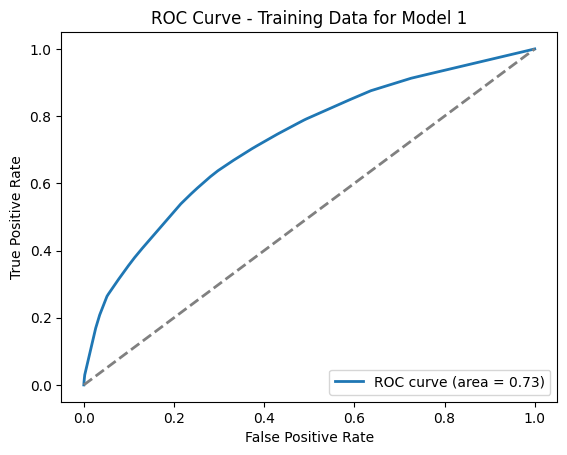


====== Metrics for Model 2 on Test Data ======
Test Accuracy: 0.6521151905612047
Test Log Loss: 0.61439805119243
Test ROC AUC: 0.7233021482581821
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7209221369280908
Class 1 Test Accuracy: 0.6117899905730727


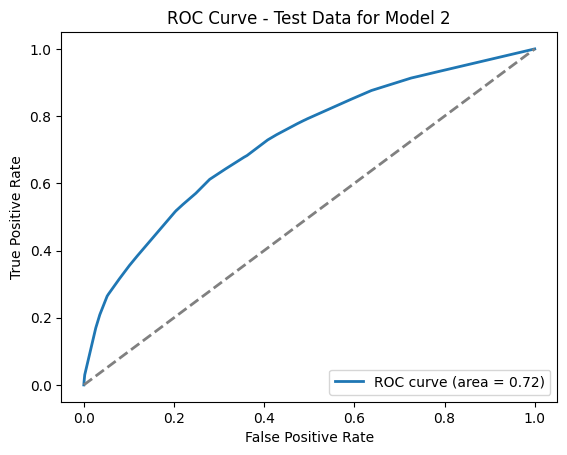


------ Metrics for Model 2 on Training Data ------
Train Accuracy: 0.6619048026392703
Train Log Loss: 0.6100184189502763
Train ROC AUC: 0.725637000278242
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.79      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7016948629370593
Class 1 Train Accuracy: 0.6385852933461572


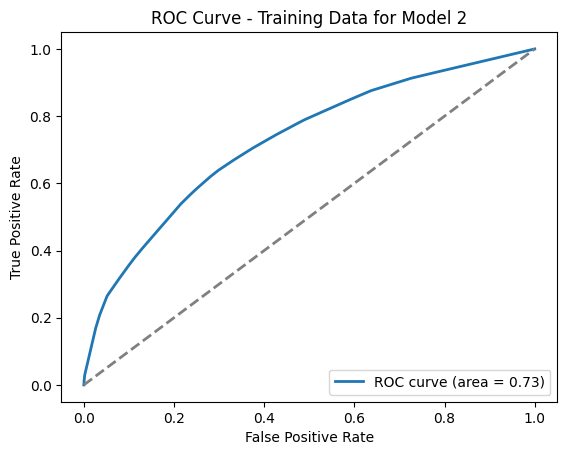


====== Metrics for Model 3 on Test Data ======
Test Accuracy: 0.6522349497122454
Test Log Loss: 0.6142647196890423
Test ROC AUC: 0.7231342819664113
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7205200074423964
Class 1 Test Accuracy: 0.6122156093031109


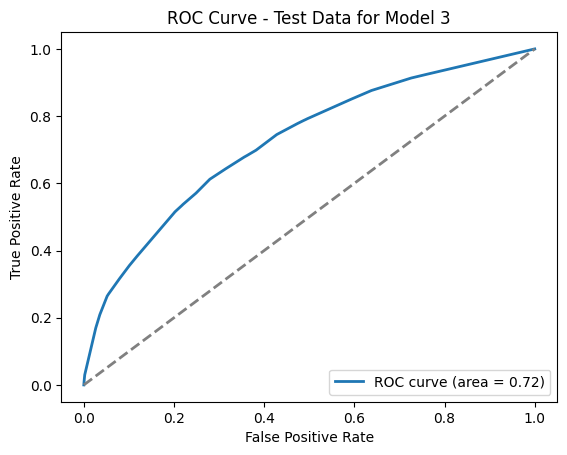


------ Metrics for Model 3 on Training Data ------
Train Accuracy: 0.6620739866306627
Train Log Loss: 0.6098747143387037
Train ROC AUC: 0.7256481811822147
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7008691670760849
Class 1 Train Accuracy: 0.6393375402881754


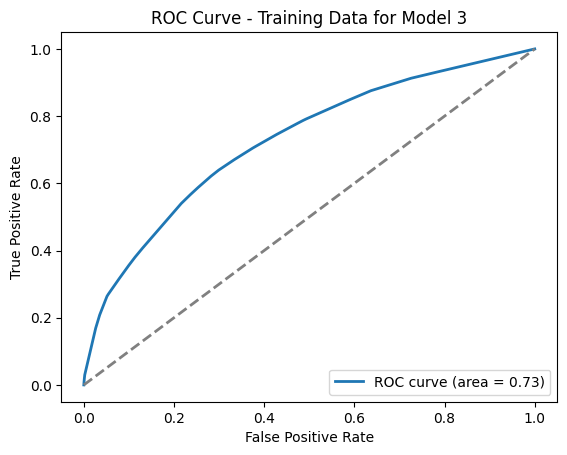


====== Metrics for Model 4 on Test Data ======
Test Accuracy: 0.6522482562845833
Test Log Loss: 0.6145592777244681
Test ROC AUC: 0.7228443219093907
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.65      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7188874817691296
Class 1 Test Accuracy: 0.613193477129149


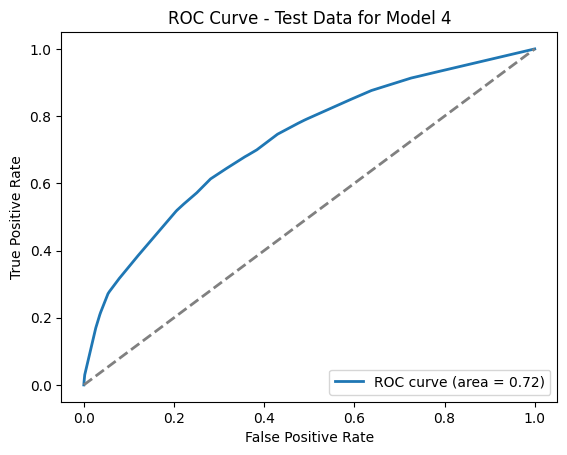


------ Metrics for Model 4 on Training Data ------
Train Accuracy: 0.662026463037575
Train Log Loss: 0.6100872660279613
Train ROC AUC: 0.7253421700515887
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.60    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.6991689023904024
Class 1 Train Accuracy: 0.6402586282271997


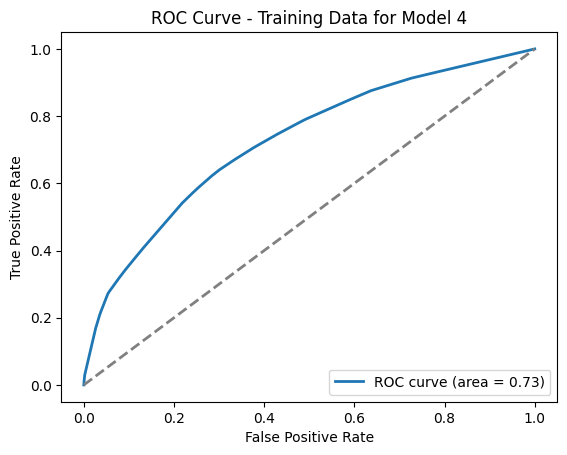


====== Metrics for Model 5 on Test Data ======
Test Accuracy: 0.652361362149455
Test Log Loss: 0.614427572542802
Test ROC AUC: 0.7228874220967979
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.65      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7184973561486798
Class 1 Test Accuracy: 0.613601508308359


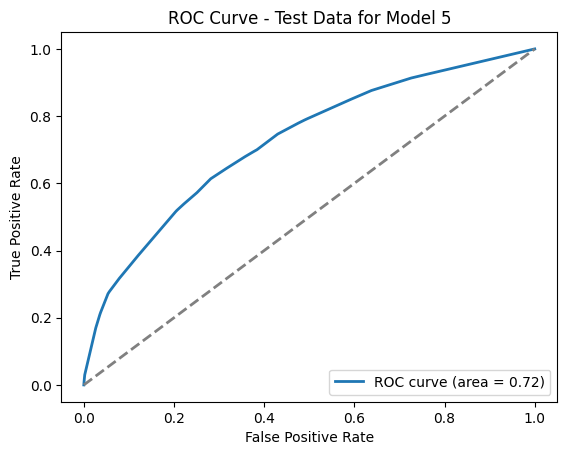


------ Metrics for Model 5 on Training Data ------
Train Accuracy: 0.6621196092800271
Train Log Loss: 0.6099859139364524
Train ROC AUC: 0.7253524525607105
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.60    388763
           1       0.78      0.64      0.71    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.6986493056180758
Class 1 Train Accuracy: 0.6407108808977517



====== Metrics for Model 6 on Test Data ======
Test Accuracy: 0.6521196260853173
Test Log Loss: 0.6143630819451887
Test ROC AUC: 0.7232933963370285
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.720688061555821
Class 1 Test Accuracy: 0.6119342084898626


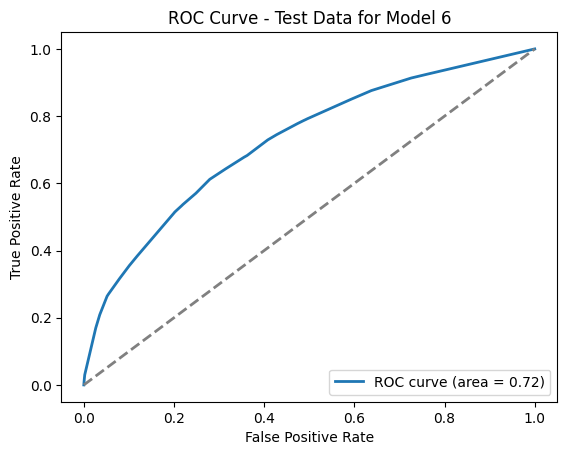


------ Metrics for Model 6 on Training Data ------
Train Accuracy: 0.6619456729293257
Train Log Loss: 0.6098725055269418
Train ROC AUC: 0.7256818831399152
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7014093419384047
Class 1 Train Accuracy: 0.6388174497170406



====== Metrics for Model 7 on Test Data ======
Test Accuracy: 0.6520220445548397
Test Log Loss: 0.6144591993429971
Test ROC AUC: 0.7231919486292897
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7210301717152924
Class 1 Test Accuracy: 0.6115789399631365



------ Metrics for Model 7 on Training Data ------
Train Accuracy: 0.6619304653795377
Train Log Loss: 0.6100941140933845
Train ROC AUC: 0.7256210227712521
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.79      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7017848920807793
Class 1 Train Accuracy: 0.6385732332749425


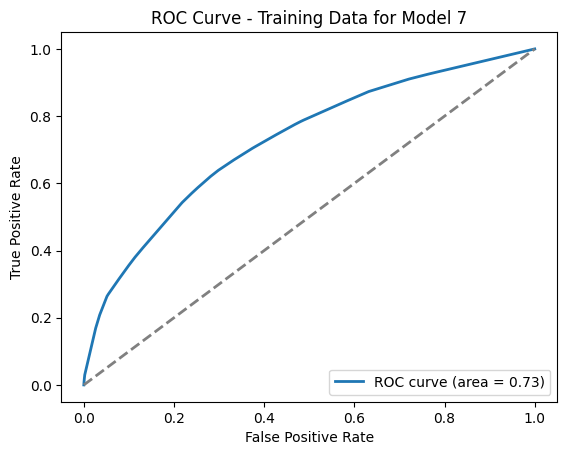

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, classification_report, 
    confusion_matrix, roc_curve
)

# Train Decision Tree models on each undersampled set
models = {}
for i in range(1, 8):
    model = DecisionTreeClassifier(random_state=42, max_depth=5)
    X_train_set, y_train_set = undersampled_sets[f"set_{i}"]
    model.fit(X_train_set, y_train_set)
    models[f"model_{i}"] = model

# Evaluate each model individually on test and training data
for i in range(1, 8):
    model = models[f"model_{i}"]
    
    # ----- Test Data Evaluation -----
    print(f"\n====== Metrics for Model {i} on Test Data ======")
    # Predictions on test data
    y_pred_test = model.predict(X_test)
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    
    # Compute test metrics
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_log_loss = log_loss(y_test, y_pred_proba_test)
    test_roc_auc = roc_auc_score(y_test, y_pred_proba_test)
    test_report = classification_report(y_test, y_pred_test)
    
    # Confusion Matrix & Class-Specific Accuracy
    test_conf_matrix = confusion_matrix(y_test, y_pred_test)
    class_0_accuracy_test = test_conf_matrix[0, 0] / test_conf_matrix[0].sum() if test_conf_matrix[0].sum() != 0 else 0
    class_1_accuracy_test = test_conf_matrix[1, 1] / test_conf_matrix[1].sum() if test_conf_matrix[1].sum() != 0 else 0
    
    # Print Test Metrics
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test Log Loss: {test_log_loss}")
    print(f"Test ROC AUC: {test_roc_auc}")
    print("Test Classification Report:")
    print(test_report)
    print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
    print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")
    
    # Plot ROC curve for test data
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {test_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Test Data for Model {i}')
    plt.legend(loc="lower right")
    plt.show()
    
    # ----- Training Data Evaluation -----
    print(f"\n------ Metrics for Model {i} on Training Data ------")
    # Predictions on training data
    y_pred_train = model.predict(X_train)
    y_pred_proba_train = model.predict_proba(X_train)[:, 1]
    
    # Compute training metrics
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_log_loss = log_loss(y_train, y_pred_proba_train)
    train_roc_auc = roc_auc_score(y_train, y_pred_proba_train)
    train_report = classification_report(y_train, y_pred_train)
    
    # Confusion Matrix & Class-Specific Accuracy for training data
    train_conf_matrix = confusion_matrix(y_train, y_pred_train)
    class_0_accuracy_train = train_conf_matrix[0, 0] / train_conf_matrix[0].sum() if train_conf_matrix[0].sum() != 0 else 0
    class_1_accuracy_train = train_conf_matrix[1, 1] / train_conf_matrix[1].sum() if train_conf_matrix[1].sum() != 0 else 0
    
    # Print Training Metrics
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Train Log Loss: {train_log_loss}")
    print(f"Train ROC AUC: {train_roc_auc}")
    print("Train Classification Report:")
    print(train_report)
    print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
    print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")
    
    # Plot ROC curve for training data
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train)
    plt.figure()
    plt.plot(fpr_train, tpr_train, lw=2, label=f'ROC curve (area = {train_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Training Data for Model {i}')
    plt.legend(loc="lower right")
    plt.show()



====== Metrics for Model 1 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6518601479247291
Test Log Loss: 0.6142614973875365
Test ROC AUC: 0.7233915620057213
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.61    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7219604712717494
Class 1 Test Accuracy: 0.6107769476453787

Optimal threshold (Sensitivity = Specificity) for Test Data: 0.45

Metrics using optimal threshold:
Test Accuracy: 0.6652509952207227
Test Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.65      0.59    166613
           1       0.77      0.68      0.72    284292

    accuracy                           0.67    45090

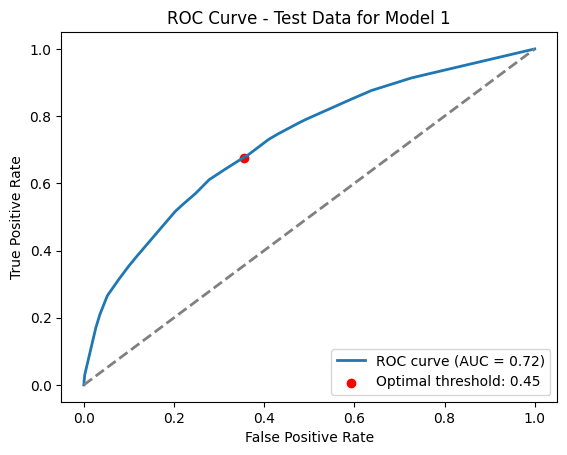


------ Metrics for Model 1 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6615493261629736
Train Log Loss: 0.6099366739174296
Train ROC AUC: 0.7256179876785607
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.79      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.702543709149276
Class 1 Train Accuracy: 0.6375240070792618

Optimal threshold (Sensitivity = Specificity) for Training Data: 0.48

Metrics using optimal threshold:
Train Accuracy: 0.6683898721520298
Train Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.67      0.60    388763
           1       0.77      0.67      0.72    663346

    accuracy                         

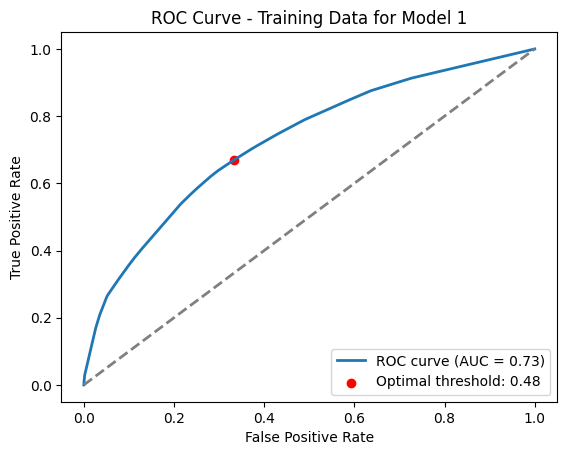


====== Metrics for Model 2 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6521151905612047
Test Log Loss: 0.61439805119243
Test ROC AUC: 0.7233021482581821
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7209221369280908
Class 1 Test Accuracy: 0.6117899905730727

Optimal threshold (Sensitivity = Specificity) for Test Data: 0.46

Metrics using optimal threshold:
Test Accuracy: 0.6655060378571983
Test Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.64      0.59    166613
           1       0.76      0.68      0.72    284292

    accuracy                           0.67    450905


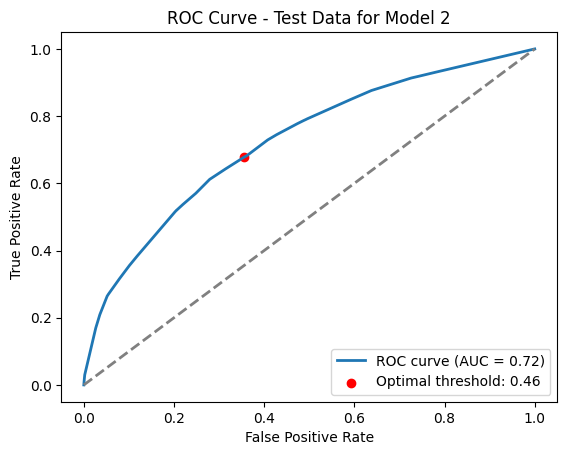


------ Metrics for Model 2 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6619048026392703
Train Log Loss: 0.6100184189502763
Train ROC AUC: 0.725637000278242
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.79      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7016948629370593
Class 1 Train Accuracy: 0.6385852933461572

Optimal threshold (Sensitivity = Specificity) for Training Data: 0.47

Metrics using optimal threshold:
Train Accuracy: 0.6687453486283266
Train Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.67      0.60    388763
           1       0.77      0.67      0.72    663346

    accuracy                         

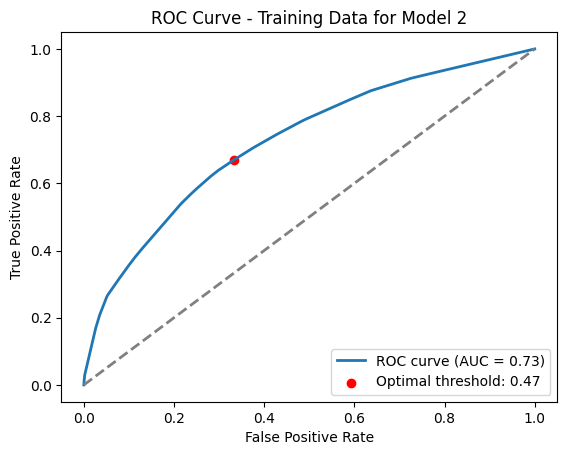


====== Metrics for Model 3 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6522349497122454
Test Log Loss: 0.6142647196890423
Test ROC AUC: 0.7231342819664113
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7205200074423964
Class 1 Test Accuracy: 0.6122156093031109

Optimal threshold (Sensitivity = Specificity) for Test Data: 0.46

Metrics using optimal threshold:
Test Accuracy: 0.665625797008239
Test Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.64      0.59    166613
           1       0.76      0.68      0.72    284292

    accuracy                           0.67    450905

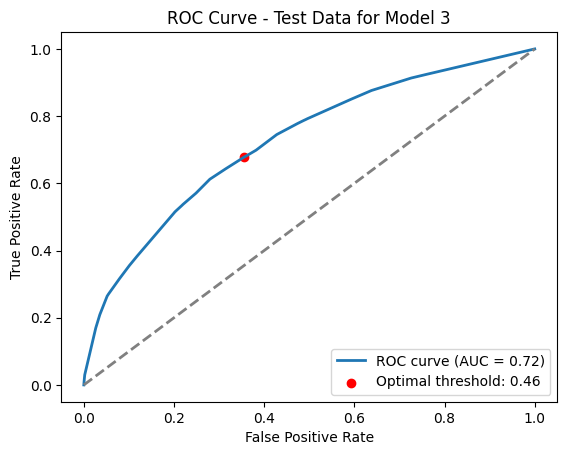


------ Metrics for Model 3 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6620739866306627
Train Log Loss: 0.6098747143387037
Train ROC AUC: 0.7256481811822147
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7008691670760849
Class 1 Train Accuracy: 0.6393375402881754

Optimal threshold (Sensitivity = Specificity) for Training Data: 0.47

Metrics using optimal threshold:
Train Accuracy: 0.668914532619719
Train Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.67      0.60    388763
           1       0.77      0.67      0.72    663346

    accuracy                         

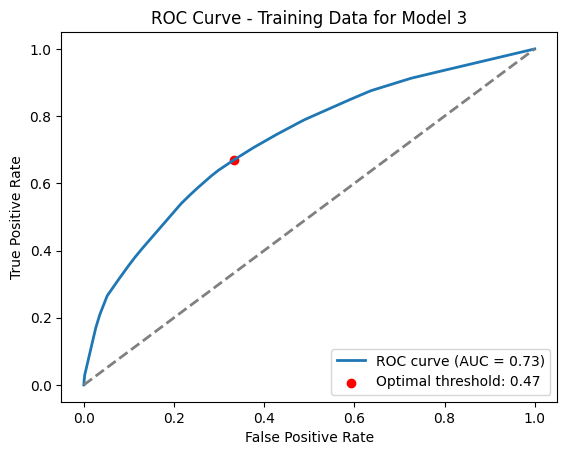


====== Metrics for Model 4 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6522482562845833
Test Log Loss: 0.6145592777244681
Test ROC AUC: 0.7228443219093907
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.65      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7188874817691296
Class 1 Test Accuracy: 0.613193477129149

Optimal threshold (Sensitivity = Specificity) for Test Data: 0.46

Metrics using optimal threshold:
Test Accuracy: 0.6656391035805769
Test Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.64      0.59    166613
           1       0.76      0.68      0.72    284292

    accuracy                           0.67    450905

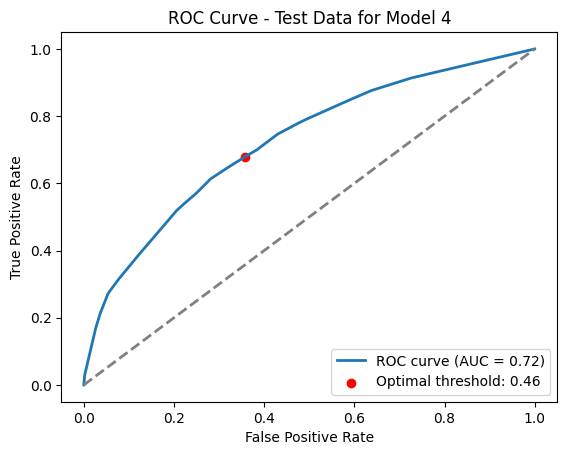


------ Metrics for Model 4 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.662026463037575
Train Log Loss: 0.6100872660279613
Train ROC AUC: 0.7253421700515887
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.60    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.6991689023904024
Class 1 Train Accuracy: 0.6402586282271997

Optimal threshold (Sensitivity = Specificity) for Training Data: 0.47

Metrics using optimal threshold:
Train Accuracy: 0.6688670090266313
Train Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.66      0.60    388763
           1       0.77      0.67      0.72    663346

    accuracy                         

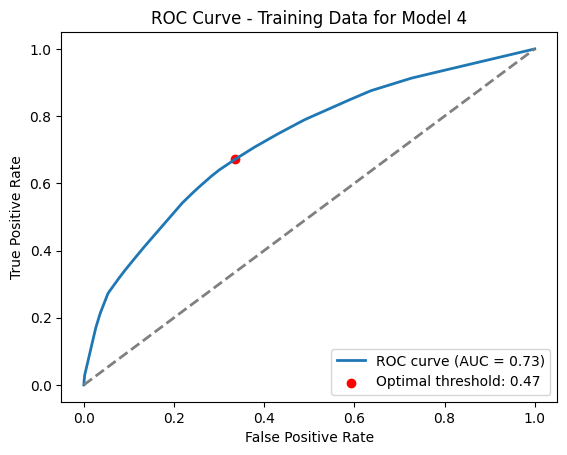


====== Metrics for Model 5 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.652361362149455
Test Log Loss: 0.614427572542802
Test ROC AUC: 0.7228874220967979
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.65      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7184973561486798
Class 1 Test Accuracy: 0.613601508308359

Optimal threshold (Sensitivity = Specificity) for Test Data: 0.46

Metrics using optimal threshold:
Test Accuracy: 0.6657522094454486
Test Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.64      0.59    166613
           1       0.76      0.68      0.72    284292

    accuracy                           0.67    450905
 

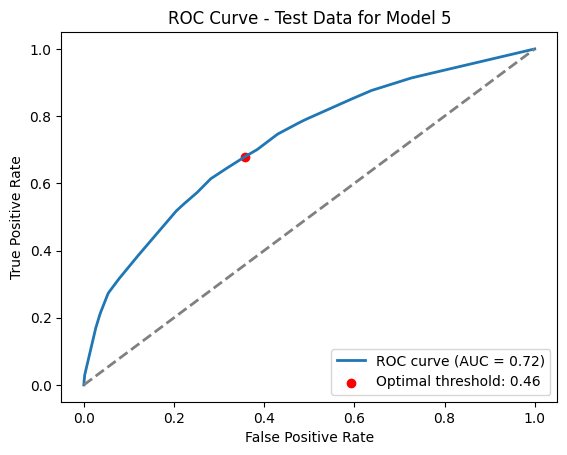


------ Metrics for Model 5 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6621196092800271
Train Log Loss: 0.6099859139364524
Train ROC AUC: 0.7253524525607105
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.60    388763
           1       0.78      0.64      0.71    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.6986493056180758
Class 1 Train Accuracy: 0.6407108808977517

Optimal threshold (Sensitivity = Specificity) for Training Data: 0.48

Metrics using optimal threshold:
Train Accuracy: 0.6689601552690834
Train Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.66      0.60    388763
           1       0.77      0.67      0.72    663346

    accuracy                        

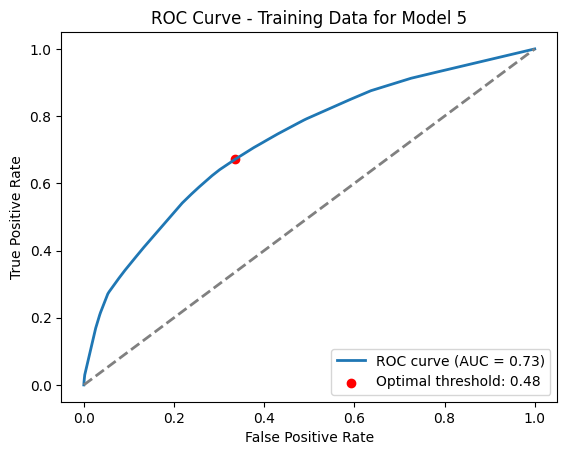


====== Metrics for Model 6 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6521196260853173
Test Log Loss: 0.6143630819451887
Test ROC AUC: 0.7232933963370285
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.720688061555821
Class 1 Test Accuracy: 0.6119342084898626

Optimal threshold (Sensitivity = Specificity) for Test Data: 0.46

Metrics using optimal threshold:
Test Accuracy: 0.6655215621915924
Test Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.64      0.59    166613
           1       0.76      0.68      0.72    284292

    accuracy                           0.67    450905

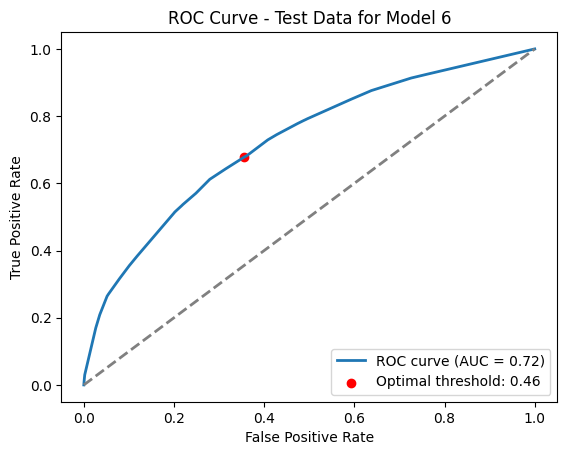


------ Metrics for Model 6 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6619456729293257
Train Log Loss: 0.6098725055269418
Train ROC AUC: 0.7256818831399152
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7014093419384047
Class 1 Train Accuracy: 0.6388174497170406

Optimal threshold (Sensitivity = Specificity) for Training Data: 0.47

Metrics using optimal threshold:
Train Accuracy: 0.6687947731651378
Train Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.67      0.60    388763
           1       0.77      0.67      0.72    663346

    accuracy                        

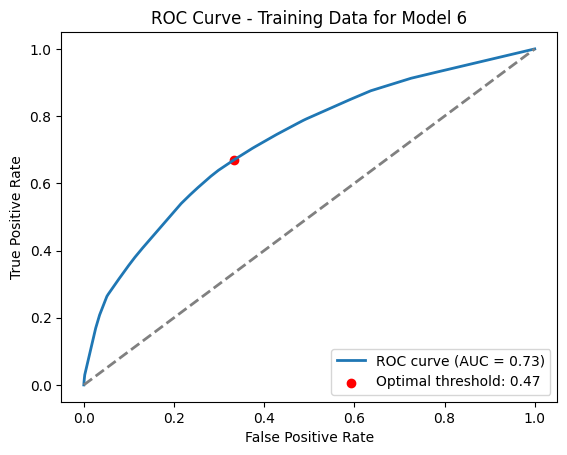


====== Metrics for Model 7 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6520220445548397
Test Log Loss: 0.6144591993429971
Test ROC AUC: 0.7231919486292897
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7210301717152924
Class 1 Test Accuracy: 0.6115789399631365

Optimal threshold (Sensitivity = Specificity) for Test Data: 0.46

Metrics using optimal threshold:
Test Accuracy: 0.6654128918508333
Test Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.64      0.59    166613
           1       0.76      0.68      0.72    284292

    accuracy                           0.67    45090

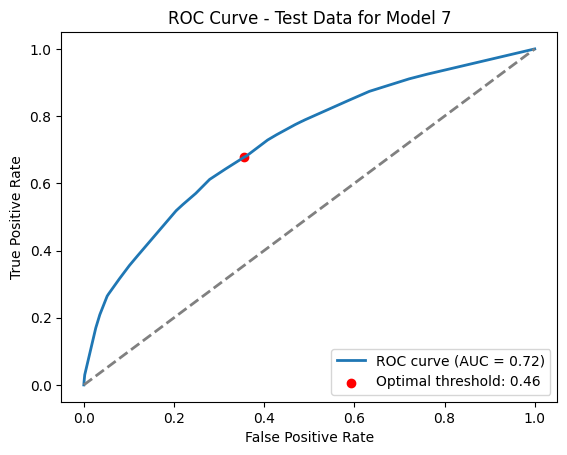


------ Metrics for Model 7 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6619304653795377
Train Log Loss: 0.6100941140933845
Train ROC AUC: 0.7256210227712521
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.79      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7017848920807793
Class 1 Train Accuracy: 0.6385732332749425

Optimal threshold (Sensitivity = Specificity) for Training Data: 0.47

Metrics using optimal threshold:
Train Accuracy: 0.668771011368594
Train Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.67      0.60    388763
           1       0.77      0.67      0.72    663346

    accuracy                         

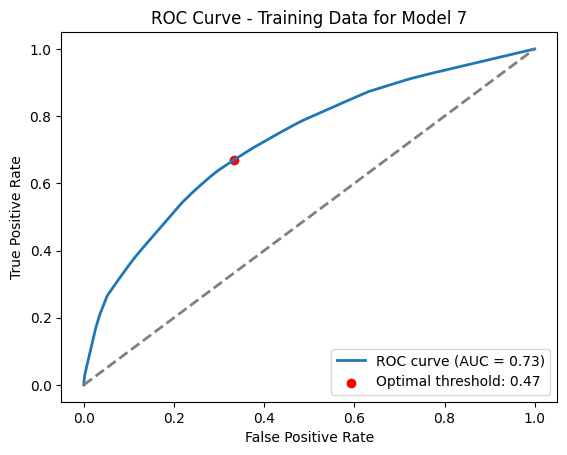

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, classification_report, 
    confusion_matrix, roc_curve
)

# Train Decision Tree models on each undersampled set
models = {}
for i in range(1, 8):
    model = DecisionTreeClassifier(random_state=42, max_depth=5)
    X_train_set, y_train_set = undersampled_sets[f"set_{i}"]
    model.fit(X_train_set, y_train_set)
    models[f"model_{i}"] = model

# Evaluate each model individually on test and training data
for i in range(1, 8):
    model = models[f"model_{i}"]
    
    # ===== Test Data Evaluation =====
    print(f"\n====== Metrics for Model {i} on Test Data ======")
    # Predictions on test data
    y_pred_test = model.predict(X_test)
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    
    # Compute default threshold metrics (0.5)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_log_loss = log_loss(y_test, y_pred_proba_test)
    test_roc_auc = roc_auc_score(y_test, y_pred_proba_test)
    test_report = classification_report(y_test, y_pred_test)
    test_conf_matrix = confusion_matrix(y_test, y_pred_test)
    class_0_accuracy_test = test_conf_matrix[0, 0] / test_conf_matrix[0].sum() if test_conf_matrix[0].sum() != 0 else 0
    class_1_accuracy_test = test_conf_matrix[1, 1] / test_conf_matrix[1].sum() if test_conf_matrix[1].sum() != 0 else 0
    
    print("Default threshold (0.5) metrics:")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test Log Loss: {test_log_loss}")
    print(f"Test ROC AUC: {test_roc_auc}")
    print("Test Classification Report:")
    print(test_report)
    print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
    print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")
    
    # Find optimal threshold where Sensitivity equals Specificity on test data
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
    diff = np.abs(tpr - (1 - fpr))
    idx = np.argmin(diff)
    optimal_threshold = thresholds[idx]
    print(f"\nOptimal threshold (Sensitivity = Specificity) for Test Data: {optimal_threshold:.2f}")
    
    # Make predictions using the optimal threshold
    y_pred_test_opt = (y_pred_proba_test >= optimal_threshold).astype(int)
    test_accuracy_opt = accuracy_score(y_test, y_pred_test_opt)
    test_report_opt = classification_report(y_test, y_pred_test_opt)
    test_conf_matrix_opt = confusion_matrix(y_test, y_pred_test_opt)
    class_0_accuracy_test_opt = test_conf_matrix_opt[0, 0] / test_conf_matrix_opt[0].sum() if test_conf_matrix_opt[0].sum() != 0 else 0
    class_1_accuracy_test_opt = test_conf_matrix_opt[1, 1] / test_conf_matrix_opt[1].sum() if test_conf_matrix_opt[1].sum() != 0 else 0
    
    print("\nMetrics using optimal threshold:")
    print(f"Test Accuracy: {test_accuracy_opt}")
    print("Test Classification Report:")
    print(test_report_opt)
    print(f"Class 0 Test Accuracy: {class_0_accuracy_test_opt}")
    print(f"Class 1 Test Accuracy: {class_1_accuracy_test_opt}")
    
    # Plot ROC curve for test data with the optimal threshold marked
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {test_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.scatter(fpr[idx], tpr[idx], color='red', label=f'Optimal threshold: {optimal_threshold:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Test Data for Model {i}')
    plt.legend(loc="lower right")
    plt.show()
    
    # ===== Training Data Evaluation =====
    print(f"\n------ Metrics for Model {i} on Training Data ------")
    # Predictions on training data
    y_pred_train = model.predict(X_train)
    y_pred_proba_train = model.predict_proba(X_train)[:, 1]
    
    # Compute default threshold metrics (0.5) for training data
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_log_loss = log_loss(y_train, y_pred_proba_train)
    train_roc_auc = roc_auc_score(y_train, y_pred_proba_train)
    train_report = classification_report(y_train, y_pred_train)
    train_conf_matrix = confusion_matrix(y_train, y_pred_train)
    class_0_accuracy_train = train_conf_matrix[0, 0] / train_conf_matrix[0].sum() if train_conf_matrix[0].sum() != 0 else 0
    class_1_accuracy_train = train_conf_matrix[1, 1] / train_conf_matrix[1].sum() if train_conf_matrix[1].sum() != 0 else 0
    
    print("Default threshold (0.5) metrics:")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Train Log Loss: {train_log_loss}")
    print(f"Train ROC AUC: {train_roc_auc}")
    print("Train Classification Report:")
    print(train_report)
    print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
    print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")
    
    # Find optimal threshold where Sensitivity equals Specificity on training data
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_proba_train)
    diff_train = np.abs(tpr_train - (1 - fpr_train))
    idx_train = np.argmin(diff_train)
    optimal_threshold_train = thresholds_train[idx_train]
    print(f"\nOptimal threshold (Sensitivity = Specificity) for Training Data: {optimal_threshold_train:.2f}")
    
    # Make predictions using the optimal threshold on training data
    y_pred_train_opt = (y_pred_proba_train >= optimal_threshold_train).astype(int)
    train_accuracy_opt = accuracy_score(y_train, y_pred_train_opt)
    train_report_opt = classification_report(y_train, y_pred_train_opt)
    train_conf_matrix_opt = confusion_matrix(y_train, y_pred_train_opt)
    class_0_accuracy_train_opt = train_conf_matrix_opt[0, 0] / train_conf_matrix_opt[0].sum() if train_conf_matrix_opt[0].sum() != 0 else 0
    class_1_accuracy_train_opt = train_conf_matrix_opt[1, 1] / train_conf_matrix_opt[1].sum() if train_conf_matrix_opt[1].sum() != 0 else 0
    
    print("\nMetrics using optimal threshold:")
    print(f"Train Accuracy: {train_accuracy_opt}")
    print("Train Classification Report:")
    print(train_report_opt)
    print(f"Class 0 Train Accuracy: {class_0_accuracy_train_opt}")
    print(f"Class 1 Train Accuracy: {class_1_accuracy_train_opt}")
    
    # Plot ROC curve for training data with the optimal threshold marked
    plt.figure()
    plt.plot(fpr_train, tpr_train, lw=2, label=f'ROC curve (AUC = {train_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.scatter(fpr_train[idx_train], tpr_train[idx_train], color='red', label=f'Optimal threshold: {optimal_threshold_train:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Training Data for Model {i}')
    plt.legend(loc="lower right")
    plt.show()


====== Metrics for Model 1 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6518601479247291
Test Log Loss: 0.6142614973875365
Test ROC AUC: 0.7233915620057213
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.61    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7219604712717494
Class 1 Test Accuracy: 0.6107769476453787


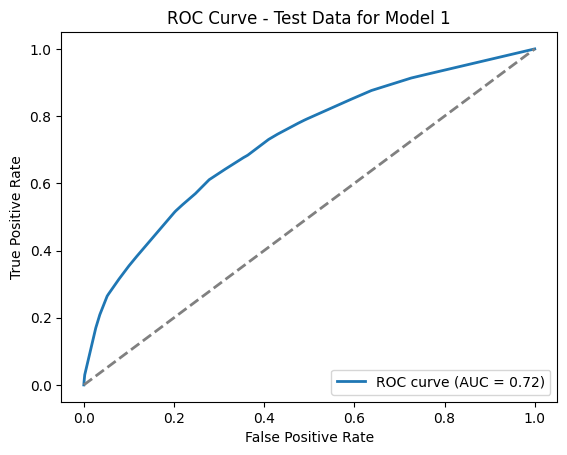


Optimal threshold (MaxSens+Spec) for Test Data: 0.52
Metrics using optimal threshold:
Test Accuracy: 0.6518601479247291
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.61    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7219604712717494
Class 1 Test Accuracy: 0.6107769476453787


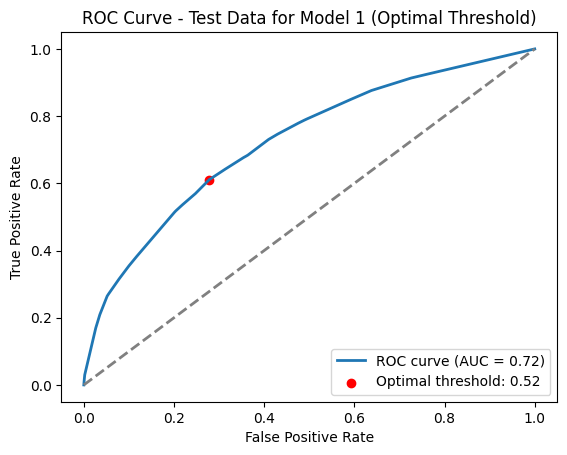


------ Metrics for Model 1 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6615493261629736
Train Log Loss: 0.6099366739174296
Train ROC AUC: 0.7256179876785607
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.79      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.702543709149276
Class 1 Train Accuracy: 0.6375240070792618


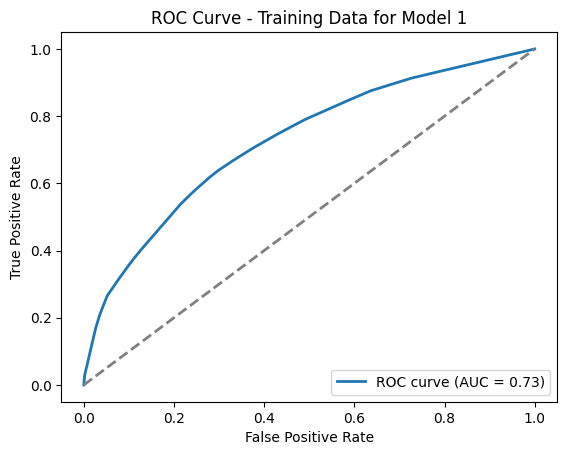


Optimal threshold (MaxSens+Spec) for Training Data: 0.52
Metrics using optimal threshold:
Train Accuracy: 0.6615493261629736
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.79      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.702543709149276
Class 1 Train Accuracy: 0.6375240070792618



====== Metrics for Model 2 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6521151905612047
Test Log Loss: 0.61439805119243
Test ROC AUC: 0.7233021482581821
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7209221369280908
Class 1 Test Accuracy: 0.6117899905730727


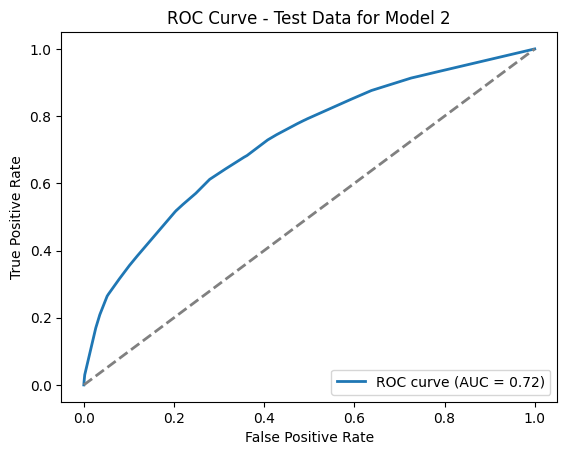


Optimal threshold (MaxSens+Spec) for Test Data: 0.51
Metrics using optimal threshold:
Test Accuracy: 0.6521151905612047
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7209221369280908
Class 1 Test Accuracy: 0.6117899905730727


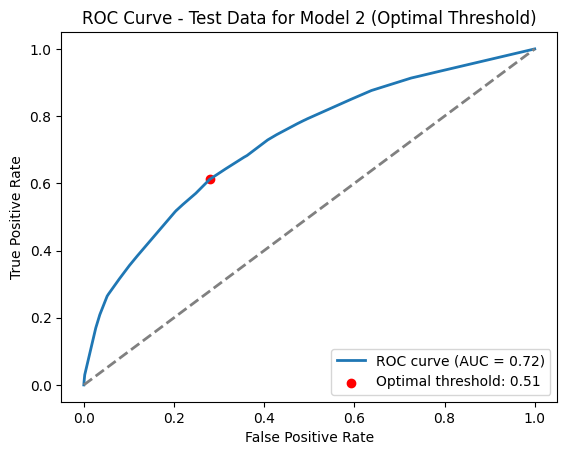


------ Metrics for Model 2 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6619048026392703
Train Log Loss: 0.6100184189502763
Train ROC AUC: 0.725637000278242
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.79      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7016948629370593
Class 1 Train Accuracy: 0.6385852933461572


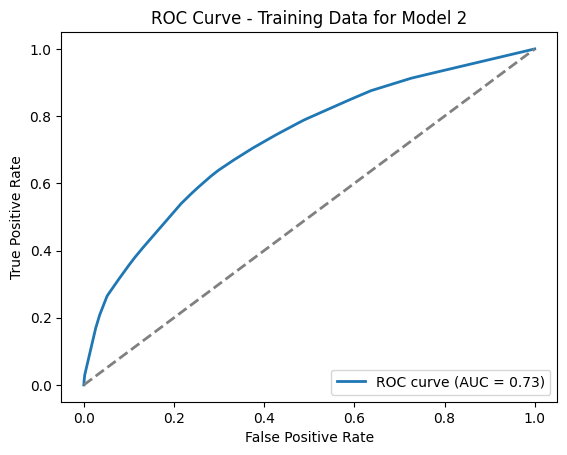


Optimal threshold (MaxSens+Spec) for Training Data: 0.51
Metrics using optimal threshold:
Train Accuracy: 0.6619048026392703
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.79      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7016948629370593
Class 1 Train Accuracy: 0.6385852933461572


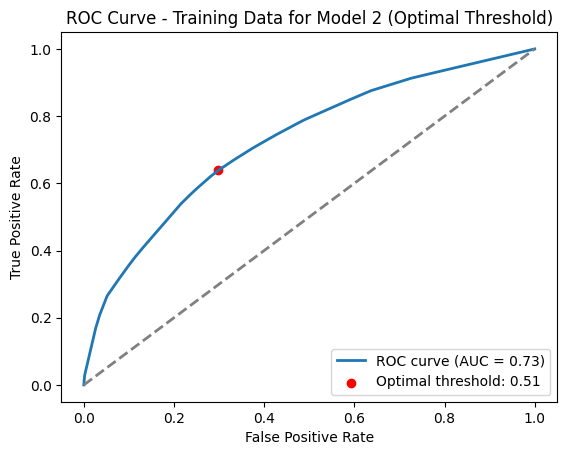


====== Metrics for Model 3 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6522349497122454
Test Log Loss: 0.6142647196890423
Test ROC AUC: 0.7231342819664113
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7205200074423964
Class 1 Test Accuracy: 0.6122156093031109


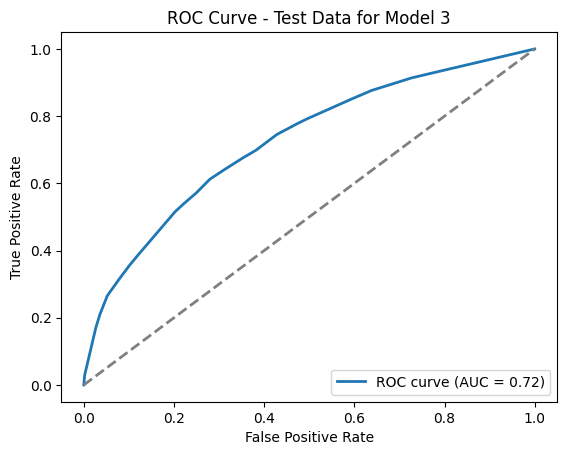


Optimal threshold (MaxSens+Spec) for Test Data: 0.52
Metrics using optimal threshold:
Test Accuracy: 0.6522349497122454
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7205200074423964
Class 1 Test Accuracy: 0.6122156093031109



------ Metrics for Model 3 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6620739866306627
Train Log Loss: 0.6098747143387037
Train ROC AUC: 0.7256481811822147
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7008691670760849
Class 1 Train Accuracy: 0.6393375402881754



Optimal threshold (MaxSens+Spec) for Training Data: 0.52
Metrics using optimal threshold:
Train Accuracy: 0.6620739866306627
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7008691670760849
Class 1 Train Accuracy: 0.6393375402881754



====== Metrics for Model 4 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6522482562845833
Test Log Loss: 0.6145592777244681
Test ROC AUC: 0.7228443219093907
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.65      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7188874817691296
Class 1 Test Accuracy: 0.613193477129149


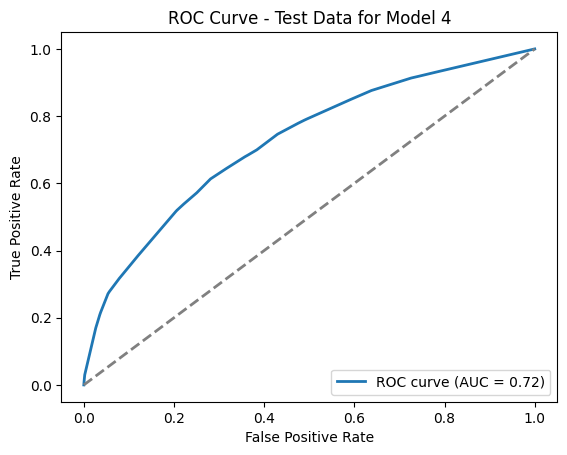


Optimal threshold (MaxSens+Spec) for Test Data: 0.51
Metrics using optimal threshold:
Test Accuracy: 0.6522482562845833
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.65      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7188874817691296
Class 1 Test Accuracy: 0.613193477129149


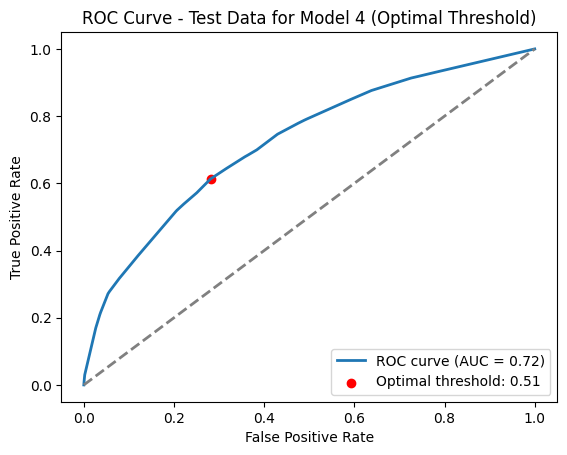


------ Metrics for Model 4 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.662026463037575
Train Log Loss: 0.6100872660279613
Train ROC AUC: 0.7253421700515887
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.60    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.6991689023904024
Class 1 Train Accuracy: 0.6402586282271997


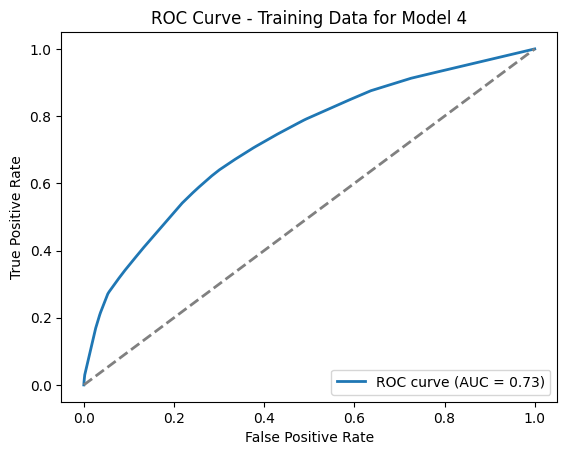


Optimal threshold (MaxSens+Spec) for Training Data: 0.51
Metrics using optimal threshold:
Train Accuracy: 0.662026463037575
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.60    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.6991689023904024
Class 1 Train Accuracy: 0.6402586282271997


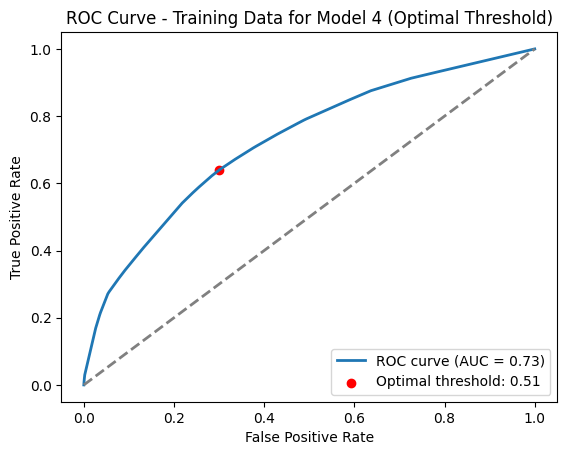


====== Metrics for Model 5 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.652361362149455
Test Log Loss: 0.614427572542802
Test ROC AUC: 0.7228874220967979
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.65      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7184973561486798
Class 1 Test Accuracy: 0.613601508308359



Optimal threshold (MaxSens+Spec) for Test Data: 0.51
Metrics using optimal threshold:
Test Accuracy: 0.652361362149455
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.65      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7184973561486798
Class 1 Test Accuracy: 0.613601508308359


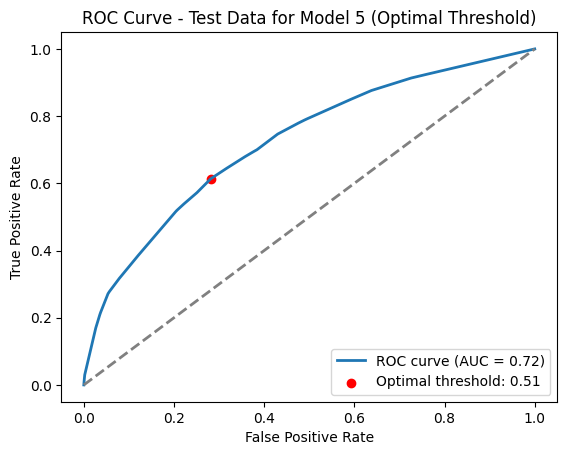


------ Metrics for Model 5 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6621196092800271
Train Log Loss: 0.6099859139364524
Train ROC AUC: 0.7253524525607105
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.60    388763
           1       0.78      0.64      0.71    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.6986493056180758
Class 1 Train Accuracy: 0.6407108808977517



Optimal threshold (MaxSens+Spec) for Training Data: 0.51
Metrics using optimal threshold:
Train Accuracy: 0.6621196092800271
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.60    388763
           1       0.78      0.64      0.71    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.6986493056180758
Class 1 Train Accuracy: 0.6407108808977517


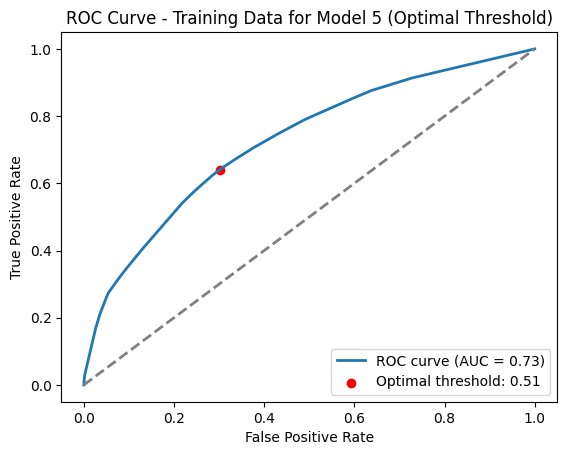


====== Metrics for Model 6 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6521196260853173
Test Log Loss: 0.6143630819451887
Test ROC AUC: 0.7232933963370285
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.720688061555821
Class 1 Test Accuracy: 0.6119342084898626


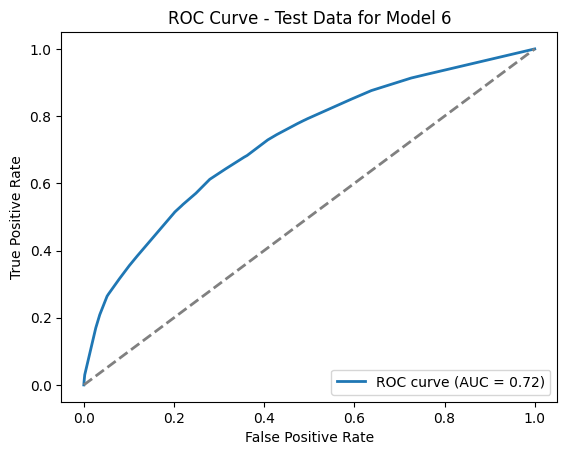


Optimal threshold (MaxSens+Spec) for Test Data: 0.51
Metrics using optimal threshold:
Test Accuracy: 0.6521196260853173
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.720688061555821
Class 1 Test Accuracy: 0.6119342084898626



------ Metrics for Model 6 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6619456729293257
Train Log Loss: 0.6098725055269418
Train ROC AUC: 0.7256818831399152
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7014093419384047
Class 1 Train Accuracy: 0.6388174497170406


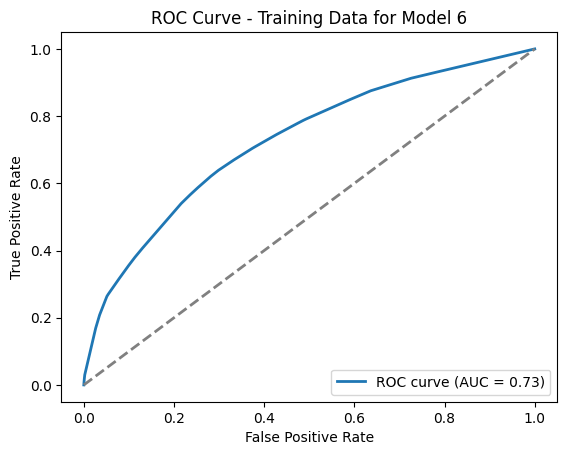


Optimal threshold (MaxSens+Spec) for Training Data: 0.51
Metrics using optimal threshold:
Train Accuracy: 0.6619456729293257
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7014093419384047
Class 1 Train Accuracy: 0.6388174497170406



====== Metrics for Model 7 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6520220445548397
Test Log Loss: 0.6144591993429971
Test ROC AUC: 0.7231919486292897
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7210301717152924
Class 1 Test Accuracy: 0.6115789399631365


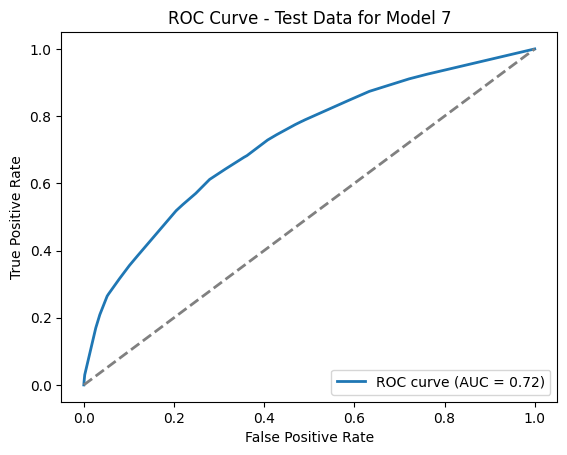


Optimal threshold (MaxSens+Spec) for Test Data: 0.52
Metrics using optimal threshold:
Test Accuracy: 0.6520220445548397
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7210301717152924
Class 1 Test Accuracy: 0.6115789399631365



------ Metrics for Model 7 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6619304653795377
Train Log Loss: 0.6100941140933845
Train ROC AUC: 0.7256210227712521
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.79      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7017848920807793
Class 1 Train Accuracy: 0.6385732332749425


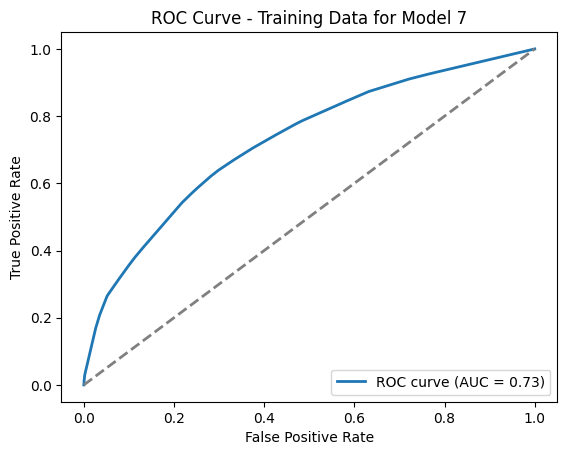


Optimal threshold (MaxSens+Spec) for Training Data: 0.52
Metrics using optimal threshold:
Train Accuracy: 0.6619304653795377
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.79      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7017848920807793
Class 1 Train Accuracy: 0.6385732332749425


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, classification_report, 
    confusion_matrix, roc_curve
)

# Train Decision Tree models on each undersampled set
models = {}
for i in range(1, 8):
    model = DecisionTreeClassifier(random_state=42, max_depth=5)
    X_train_set, y_train_set = undersampled_sets[f"set_{i}"]
    model.fit(X_train_set, y_train_set)
    models[f"model_{i}"] = model

# Evaluate each model individually on test and training data
for i in range(1, 8):
    model = models[f"model_{i}"]
    
    # ----- Test Data Evaluation -----
    print(f"\n====== Metrics for Model {i} on Test Data ======")
    # Predictions on test data
    y_pred_test = model.predict(X_test)
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    
    # Compute test metrics using default threshold 0.5
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_log_loss = log_loss(y_test, y_pred_proba_test)
    test_roc_auc = roc_auc_score(y_test, y_pred_proba_test)
    test_report = classification_report(y_test, y_pred_test)
    
    # Confusion Matrix & Class-Specific Accuracy
    test_conf_matrix = confusion_matrix(y_test, y_pred_test)
    class_0_accuracy_test = (test_conf_matrix[0, 0] / test_conf_matrix[0].sum()) if test_conf_matrix[0].sum() != 0 else 0
    class_1_accuracy_test = (test_conf_matrix[1, 1] / test_conf_matrix[1].sum()) if test_conf_matrix[1].sum() != 0 else 0
    
    print("Default threshold (0.5) metrics:")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test Log Loss: {test_log_loss}")
    print(f"Test ROC AUC: {test_roc_auc}")
    print("Test Classification Report:")
    print(test_report)
    print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
    print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")
    
    # Plot ROC curve for test data (baseline)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {test_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Test Data for Model {i}')
    plt.legend(loc="lower right")
    plt.show()
    
    # ---- Find Optimal Threshold (Maximizing Sensitivity + Specificity) ----
    # Specificity = 1 - FPR, so sum = TPR + (1-FPR)
    specificity = 1 - fpr
    sens_spec_sum = tpr + specificity
    idx = np.argmax(sens_spec_sum)  # index for maximum sum
    optimal_threshold = thresholds[idx]
    print(f"\nOptimal threshold (MaxSens+Spec) for Test Data: {optimal_threshold:.2f}")
    
    # Compute new predictions using the optimal threshold
    y_pred_test_opt = (y_pred_proba_test >= optimal_threshold).astype(int)
    test_accuracy_opt = accuracy_score(y_test, y_pred_test_opt)
    test_report_opt = classification_report(y_test, y_pred_test_opt)
    test_conf_matrix_opt = confusion_matrix(y_test, y_pred_test_opt)
    class_0_accuracy_test_opt = (test_conf_matrix_opt[0, 0] / test_conf_matrix_opt[0].sum()) if test_conf_matrix_opt[0].sum() != 0 else 0
    class_1_accuracy_test_opt = (test_conf_matrix_opt[1, 1] / test_conf_matrix_opt[1].sum()) if test_conf_matrix_opt[1].sum() != 0 else 0
    
    print("Metrics using optimal threshold:")
    print(f"Test Accuracy: {test_accuracy_opt}")
    print("Test Classification Report:")
    print(test_report_opt)
    print(f"Class 0 Test Accuracy: {class_0_accuracy_test_opt}")
    print(f"Class 1 Test Accuracy: {class_1_accuracy_test_opt}")
    
    # Plot ROC curve for test data and mark the optimal threshold point
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {test_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.scatter(fpr[idx], tpr[idx], color='red', label=f'Optimal threshold: {optimal_threshold:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Test Data for Model {i} (Optimal Threshold)')
    plt.legend(loc="lower right")
    plt.show()
    
    # ----- Training Data Evaluation -----
    print(f"\n------ Metrics for Model {i} on Training Data ------")
    # Predictions on training data
    y_pred_train = model.predict(X_train)
    y_pred_proba_train = model.predict_proba(X_train)[:, 1]
    
    # Compute training metrics using default threshold 0.5
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_log_loss = log_loss(y_train, y_pred_proba_train)
    train_roc_auc = roc_auc_score(y_train, y_pred_proba_train)
    train_report = classification_report(y_train, y_pred_train)
    train_conf_matrix = confusion_matrix(y_train, y_pred_train)
    class_0_accuracy_train = (train_conf_matrix[0, 0] / train_conf_matrix[0].sum()) if train_conf_matrix[0].sum() != 0 else 0
    class_1_accuracy_train = (train_conf_matrix[1, 1] / train_conf_matrix[1].sum()) if train_conf_matrix[1].sum() != 0 else 0
    
    print("Default threshold (0.5) metrics:")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Train Log Loss: {train_log_loss}")
    print(f"Train ROC AUC: {train_roc_auc}")
    print("Train Classification Report:")
    print(train_report)
    print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
    print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")
    
    # Plot ROC curve for training data (baseline)
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_proba_train)
    plt.figure()
    plt.plot(fpr_train, tpr_train, lw=2, label=f'ROC curve (AUC = {train_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Training Data for Model {i}')
    plt.legend(loc="lower right")
    plt.show()
    
    # ---- Find Optimal Threshold for Training Data ----
    specificity_train = 1 - fpr_train
    sens_spec_sum_train = tpr_train + specificity_train
    idx_train = np.argmax(sens_spec_sum_train)
    optimal_threshold_train = thresholds_train[idx_train]
    print(f"\nOptimal threshold (MaxSens+Spec) for Training Data: {optimal_threshold_train:.2f}")
    
    # Compute new predictions using the optimal threshold on training data
    y_pred_train_opt = (y_pred_proba_train >= optimal_threshold_train).astype(int)
    train_accuracy_opt = accuracy_score(y_train, y_pred_train_opt)
    train_report_opt = classification_report(y_train, y_pred_train_opt)
    train_conf_matrix_opt = confusion_matrix(y_train, y_pred_train_opt)
    class_0_accuracy_train_opt = (train_conf_matrix_opt[0, 0] / train_conf_matrix_opt[0].sum()) if train_conf_matrix_opt[0].sum() != 0 else 0
    class_1_accuracy_train_opt = (train_conf_matrix_opt[1, 1] / train_conf_matrix_opt[1].sum()) if train_conf_matrix_opt[1].sum() != 0 else 0
    
    print("Metrics using optimal threshold:")
    print(f"Train Accuracy: {train_accuracy_opt}")
    print("Train Classification Report:")
    print(train_report_opt)
    print(f"Class 0 Train Accuracy: {class_0_accuracy_train_opt}")
    print(f"Class 1 Train Accuracy: {class_1_accuracy_train_opt}")
    
    # Plot ROC curve for training data and mark the optimal threshold point
    plt.figure()
    plt.plot(fpr_train, tpr_train, lw=2, label=f'ROC curve (AUC = {train_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.scatter(fpr_train[idx_train], tpr_train[idx_train], color='red', label=f'Optimal threshold: {optimal_threshold_train:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Training Data for Model {i} (Optimal Threshold)')
    plt.legend(loc="lower right")
    plt.show()


====== Metrics for Model 1 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6518601479247291
Test Log Loss: 0.6142614973875365
Test ROC AUC: 0.7233915620057213
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.61    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7219604712717494
Class 1 Test Accuracy: 0.6107769476453787


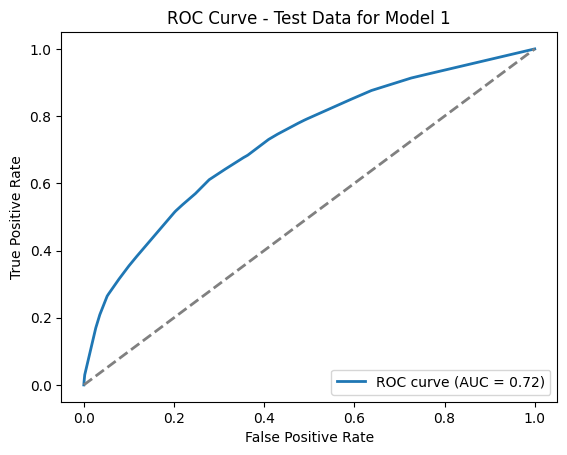


Optimal threshold (MaxPCC) for Test Data: 0.37
Metrics using optimal threshold (MaxPCC):
Test Accuracy: 0.6864838491478249
Test Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.41      0.49    166613
           1       0.71      0.85      0.77    284292

    accuracy                           0.69    450905
   macro avg       0.66      0.63      0.63    450905
weighted avg       0.67      0.69      0.67    450905

Class 0 Test Accuracy: 0.40738717867153224
Class 1 Test Accuracy: 0.8500520591504509



------ Metrics for Model 1 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6615493261629736
Train Log Loss: 0.6099366739174296
Train ROC AUC: 0.7256179876785607
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.79      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.702543709149276
Class 1 Train Accuracy: 0.6375240070792618


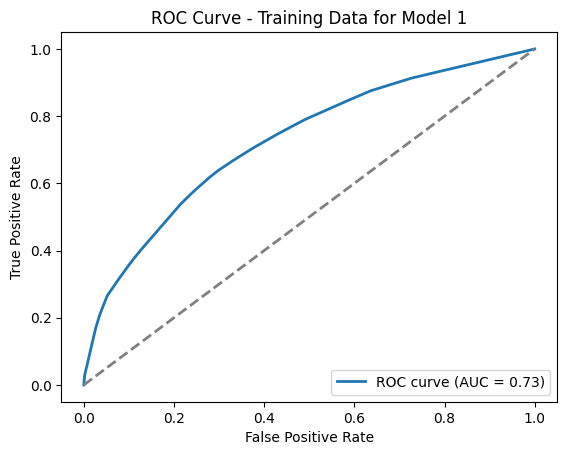


Optimal threshold (MaxPCC) for Training Data: 0.37
Metrics using optimal threshold (MaxPCC):
Train Accuracy: 0.6867681960709394
Train Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.41      0.49    388763
           1       0.71      0.85      0.77    663346

    accuracy                           0.69   1052109
   macro avg       0.66      0.63      0.63   1052109
weighted avg       0.67      0.69      0.67   1052109

Class 0 Train Accuracy: 0.40920046403592936
Class 1 Train Accuracy: 0.8494405634465272



====== Metrics for Model 2 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6521151905612047
Test Log Loss: 0.61439805119243
Test ROC AUC: 0.7233021482581821
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7209221369280908
Class 1 Test Accuracy: 0.6117899905730727


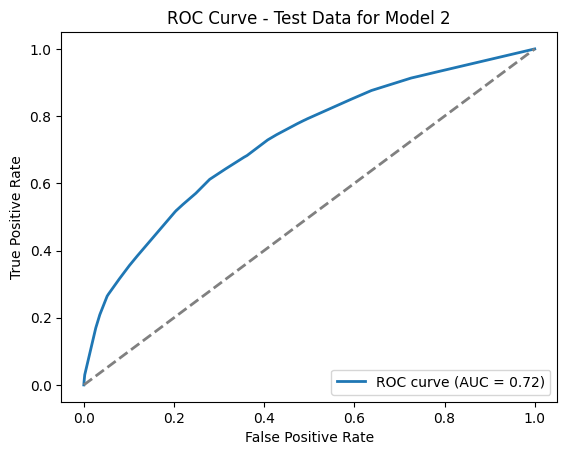


Optimal threshold (MaxPCC) for Test Data: 0.37
Metrics using optimal threshold (MaxPCC):
Test Accuracy: 0.6864838491478249
Test Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.41      0.49    166613
           1       0.71      0.85      0.77    284292

    accuracy                           0.69    450905
   macro avg       0.66      0.63      0.63    450905
weighted avg       0.67      0.69      0.67    450905

Class 0 Test Accuracy: 0.40738717867153224
Class 1 Test Accuracy: 0.8500520591504509



------ Metrics for Model 2 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6619048026392703
Train Log Loss: 0.6100184189502763
Train ROC AUC: 0.725637000278242
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.79      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7016948629370593
Class 1 Train Accuracy: 0.6385852933461572


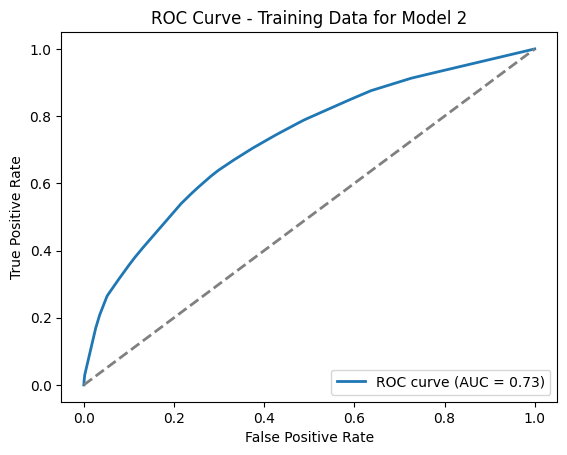


Optimal threshold (MaxPCC) for Training Data: 0.37
Metrics using optimal threshold (MaxPCC):
Train Accuracy: 0.6867681960709394
Train Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.41      0.49    388763
           1       0.71      0.85      0.77    663346

    accuracy                           0.69   1052109
   macro avg       0.66      0.63      0.63   1052109
weighted avg       0.67      0.69      0.67   1052109

Class 0 Train Accuracy: 0.40920303629717847
Class 1 Train Accuracy: 0.8494390559376254



====== Metrics for Model 3 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6522349497122454
Test Log Loss: 0.6142647196890423
Test ROC AUC: 0.7231342819664113
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7205200074423964
Class 1 Test Accuracy: 0.6122156093031109


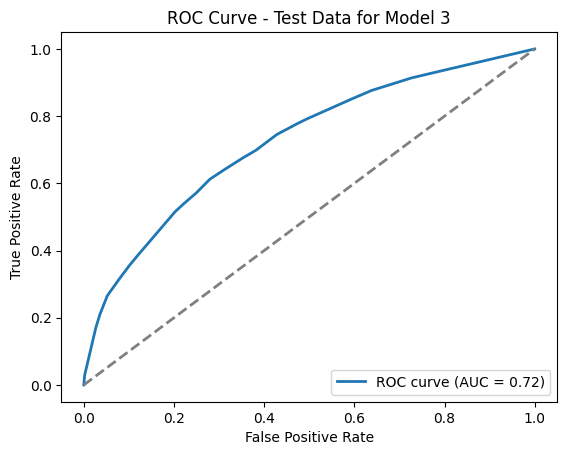


Optimal threshold (MaxPCC) for Test Data: 0.37
Metrics using optimal threshold (MaxPCC):
Test Accuracy: 0.6865570352956831
Test Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.41      0.49    166613
           1       0.71      0.85      0.77    284292

    accuracy                           0.69    450905
   macro avg       0.66      0.63      0.63    450905
weighted avg       0.67      0.69      0.67    450905

Class 0 Test Accuracy: 0.4069610414553486
Class 1 Test Accuracy: 0.8504178802076738


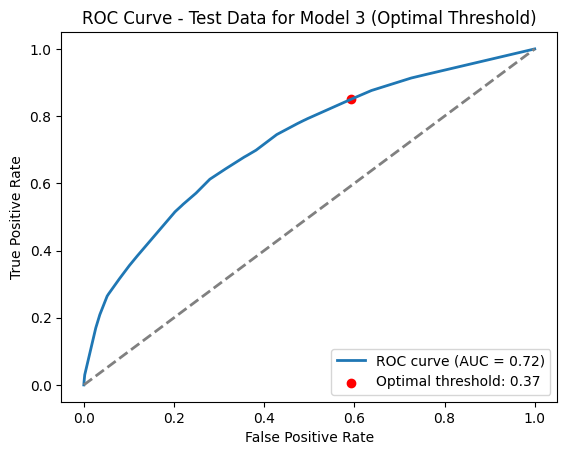


------ Metrics for Model 3 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6620739866306627
Train Log Loss: 0.6098747143387037
Train ROC AUC: 0.7256481811822147
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7008691670760849
Class 1 Train Accuracy: 0.6393375402881754


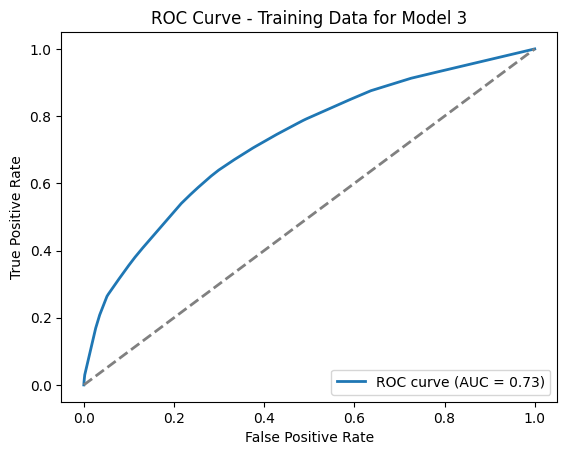


Optimal threshold (MaxPCC) for Training Data: 0.37
Metrics using optimal threshold (MaxPCC):
Train Accuracy: 0.6868451842917417
Train Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.41      0.49    388763
           1       0.71      0.85      0.77    663346

    accuracy                           0.69   1052109
   macro avg       0.66      0.63      0.63   1052109
weighted avg       0.68      0.69      0.67   1052109

Class 0 Train Accuracy: 0.40870144535359587
Class 1 Train Accuracy: 0.8498551283945331



====== Metrics for Model 4 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6522482562845833
Test Log Loss: 0.6145592777244681
Test ROC AUC: 0.7228443219093907
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.65      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7188874817691296
Class 1 Test Accuracy: 0.613193477129149


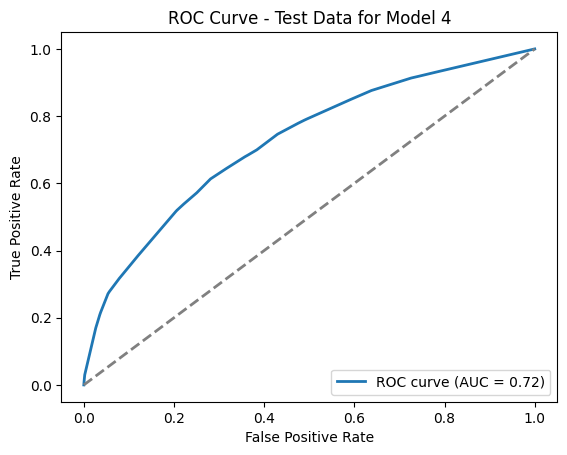


Optimal threshold (MaxPCC) for Test Data: 0.37
Metrics using optimal threshold (MaxPCC):
Test Accuracy: 0.6864838491478249
Test Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.41      0.49    166613
           1       0.71      0.85      0.77    284292

    accuracy                           0.69    450905
   macro avg       0.66      0.63      0.63    450905
weighted avg       0.67      0.69      0.67    450905

Class 0 Test Accuracy: 0.40738717867153224
Class 1 Test Accuracy: 0.8500520591504509



------ Metrics for Model 4 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.662026463037575
Train Log Loss: 0.6100872660279613
Train ROC AUC: 0.7253421700515887
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.60    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.6991689023904024
Class 1 Train Accuracy: 0.6402586282271997


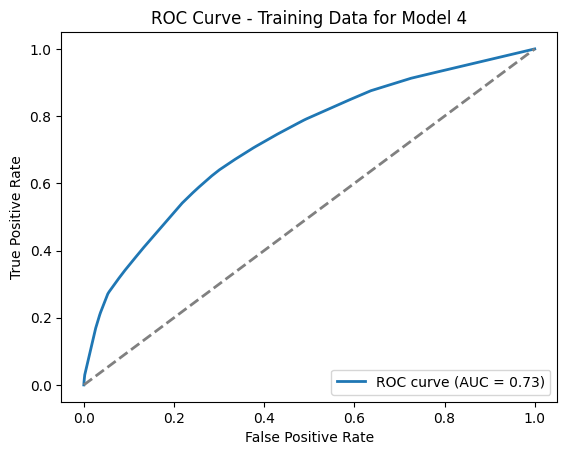


Optimal threshold (MaxPCC) for Training Data: 0.37
Metrics using optimal threshold (MaxPCC):
Train Accuracy: 0.6867681960709394
Train Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.41      0.49    388763
           1       0.71      0.85      0.77    663346

    accuracy                           0.69   1052109
   macro avg       0.66      0.63      0.63   1052109
weighted avg       0.67      0.69      0.67   1052109

Class 0 Train Accuracy: 0.40920046403592936
Class 1 Train Accuracy: 0.8494405634465272



====== Metrics for Model 5 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.652361362149455
Test Log Loss: 0.614427572542802
Test ROC AUC: 0.7228874220967979
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.65      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7184973561486798
Class 1 Test Accuracy: 0.613601508308359


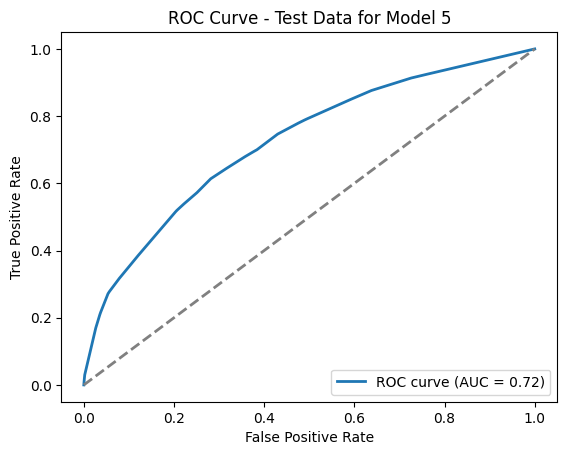


Optimal threshold (MaxPCC) for Test Data: 0.37
Metrics using optimal threshold (MaxPCC):
Test Accuracy: 0.6865681241059647
Test Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.41      0.49    166613
           1       0.71      0.85      0.77    284292

    accuracy                           0.69    450905
   macro avg       0.66      0.63      0.63    450905
weighted avg       0.67      0.69      0.67    450905

Class 0 Test Accuracy: 0.40700305498370476
Class 1 Test Accuracy: 0.8504108451873426



------ Metrics for Model 5 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6621196092800271
Train Log Loss: 0.6099859139364524
Train ROC AUC: 0.7253524525607105
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.60    388763
           1       0.78      0.64      0.71    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.6986493056180758
Class 1 Train Accuracy: 0.6407108808977517



Optimal threshold (MaxPCC) for Training Data: 0.37
Metrics using optimal threshold (MaxPCC):
Train Accuracy: 0.6868489861791887
Train Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.41      0.49    388763
           1       0.71      0.85      0.77    663346

    accuracy                           0.69   1052109
   macro avg       0.66      0.63      0.63   1052109
weighted avg       0.68      0.69      0.67   1052109

Class 0 Train Accuracy: 0.40871687892109076
Class 1 Train Accuracy: 0.8498521133767295


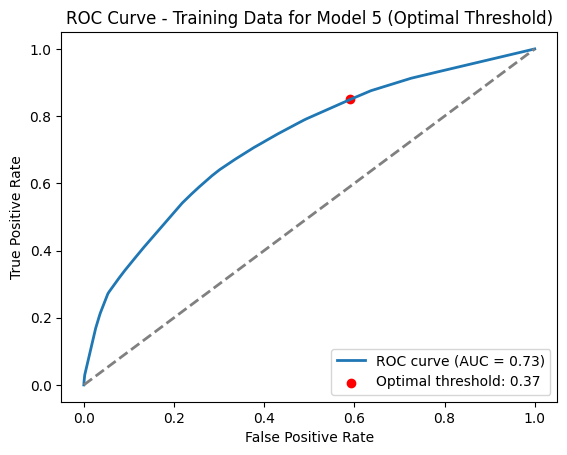


====== Metrics for Model 6 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6521196260853173
Test Log Loss: 0.6143630819451887
Test ROC AUC: 0.7232933963370285
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.720688061555821
Class 1 Test Accuracy: 0.6119342084898626


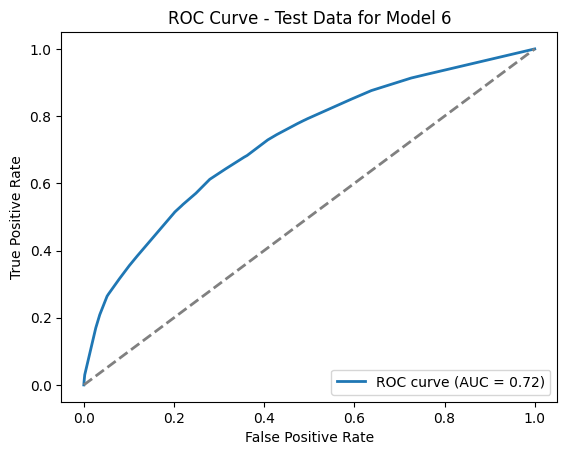


Optimal threshold (MaxPCC) for Test Data: 0.37
Metrics using optimal threshold (MaxPCC):
Test Accuracy: 0.6865082445304443
Test Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.41      0.49    166613
           1       0.71      0.85      0.77    284292

    accuracy                           0.69    450905
   macro avg       0.66      0.63      0.63    450905
weighted avg       0.67      0.69      0.67    450905

Class 0 Test Accuracy: 0.4071410994340178
Class 1 Test Accuracy: 0.8502349696790624


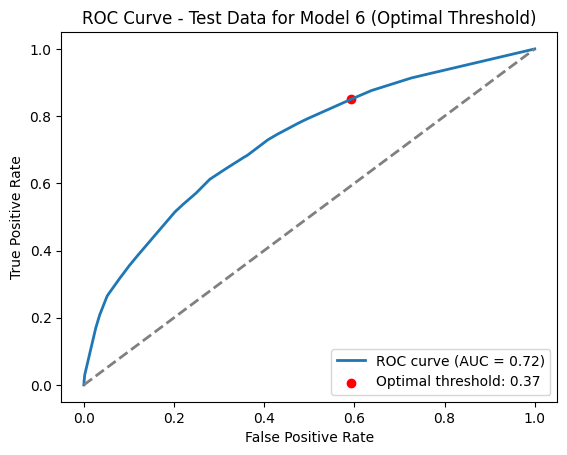


------ Metrics for Model 6 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6619456729293257
Train Log Loss: 0.6098725055269418
Train ROC AUC: 0.7256818831399152
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7014093419384047
Class 1 Train Accuracy: 0.6388174497170406


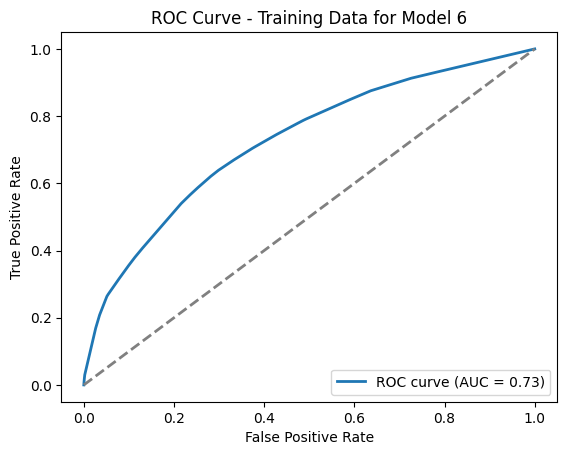


Optimal threshold (MaxPCC) for Training Data: 0.37
Metrics using optimal threshold (MaxPCC):
Train Accuracy: 0.6868271253263682
Train Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.41      0.49    388763
           1       0.71      0.85      0.77    663346

    accuracy                           0.69   1052109
   macro avg       0.66      0.63      0.63   1052109
weighted avg       0.67      0.69      0.67   1052109

Class 0 Train Accuracy: 0.40889950946977976
Class 1 Train Accuracy: 0.8497104075399565


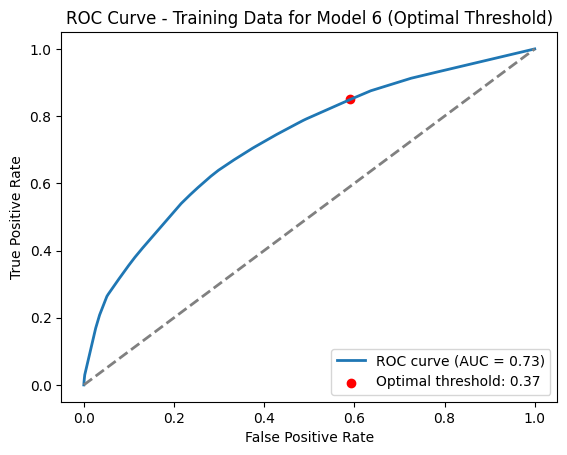


====== Metrics for Model 7 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6520220445548397
Test Log Loss: 0.6144591993429971
Test ROC AUC: 0.7231919486292897
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7210301717152924
Class 1 Test Accuracy: 0.6115789399631365


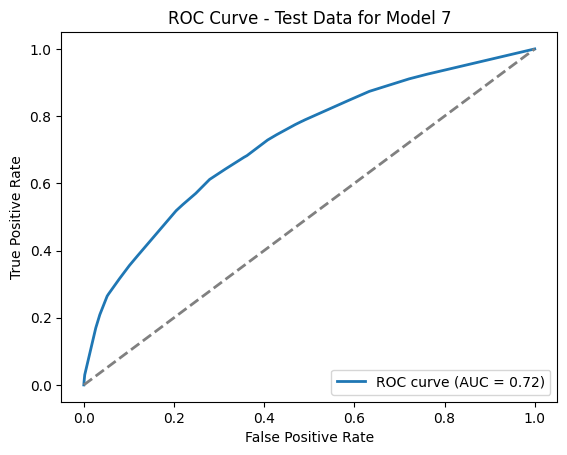


Optimal threshold (MaxPCC) for Test Data: 0.37
Metrics using optimal threshold (MaxPCC):
Test Accuracy: 0.6864284050964172
Test Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.41      0.49    166613
           1       0.71      0.85      0.77    284292

    accuracy                           0.69    450905
   macro avg       0.66      0.63      0.63    450905
weighted avg       0.67      0.69      0.67    450905

Class 0 Test Accuracy: 0.41272889870538315
Class 1 Test Accuracy: 0.846833537348923


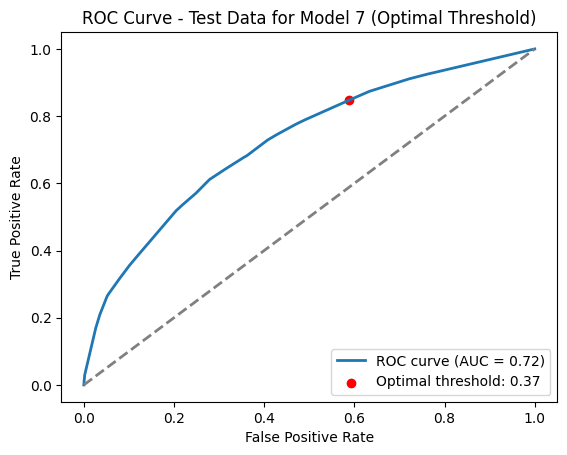


------ Metrics for Model 7 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6619304653795377
Train Log Loss: 0.6100941140933845
Train ROC AUC: 0.7256210227712521
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.79      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7017848920807793
Class 1 Train Accuracy: 0.6385732332749425


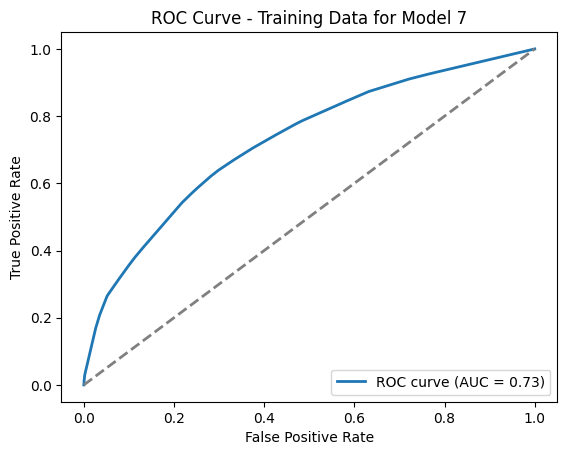


Optimal threshold (MaxPCC) for Training Data: 0.37
Metrics using optimal threshold (MaxPCC):
Train Accuracy: 0.6868157196640272
Train Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.41      0.49    388763
           1       0.71      0.85      0.77    663346

    accuracy                           0.69   1052109
   macro avg       0.66      0.63      0.63   1052109
weighted avg       0.68      0.69      0.67   1052109

Class 0 Train Accuracy: 0.4149031672252761
Class 1 Train Accuracy: 0.8461737916562397


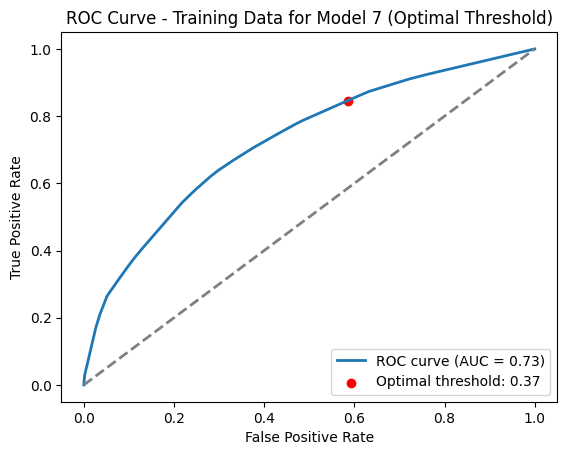

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, classification_report, 
    confusion_matrix, roc_curve
)

# Train Decision Tree models on each undersampled set
models = {}
for i in range(1, 8):
    model = DecisionTreeClassifier(random_state=42, max_depth=5)
    X_train_set, y_train_set = undersampled_sets[f"set_{i}"]
    model.fit(X_train_set, y_train_set)
    models[f"model_{i}"] = model

# Evaluate each model individually on test and training data
for i in range(1, 8):
    model = models[f"model_{i}"]
    
    # ----- Test Data Evaluation -----
    print(f"\n====== Metrics for Model {i} on Test Data ======")
    # Predictions on test data
    y_pred_test = model.predict(X_test)
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    
    # Compute test metrics using the default threshold (0.5)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_log_loss = log_loss(y_test, y_pred_proba_test)
    test_roc_auc = roc_auc_score(y_test, y_pred_proba_test)
    test_report = classification_report(y_test, y_pred_test)
    
    # Confusion Matrix & Class-Specific Accuracy
    test_conf_matrix = confusion_matrix(y_test, y_pred_test)
    class_0_accuracy_test = (test_conf_matrix[0, 0] / test_conf_matrix[0].sum()) if test_conf_matrix[0].sum() != 0 else 0
    class_1_accuracy_test = (test_conf_matrix[1, 1] / test_conf_matrix[1].sum()) if test_conf_matrix[1].sum() != 0 else 0
    
    print("Default threshold (0.5) metrics:")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test Log Loss: {test_log_loss}")
    print(f"Test ROC AUC: {test_roc_auc}")
    print("Test Classification Report:")
    print(test_report)
    print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
    print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")
    
    # Plot baseline ROC curve for test data
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {test_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Test Data for Model {i}')
    plt.legend(loc="lower right")
    plt.show()
    
    # ---- Find Optimal Threshold (MaxPCC: Maximizing Overall Accuracy) ----
    # We'll loop through candidate thresholds (from roc_curve) and compute accuracy for each.
    acc_values = []
    for thresh in thresholds:
        y_pred_thresh = (y_pred_proba_test >= thresh).astype(int)
        acc = accuracy_score(y_test, y_pred_thresh)
        acc_values.append(acc)
    acc_values = np.array(acc_values)
    idx = np.argmax(acc_values)
    optimal_threshold = thresholds[idx]
    print(f"\nOptimal threshold (MaxPCC) for Test Data: {optimal_threshold:.2f}")
    
    # Compute new predictions using the optimal threshold and recalc metrics
    y_pred_test_opt = (y_pred_proba_test >= optimal_threshold).astype(int)
    test_accuracy_opt = accuracy_score(y_test, y_pred_test_opt)
    test_report_opt = classification_report(y_test, y_pred_test_opt)
    test_conf_matrix_opt = confusion_matrix(y_test, y_pred_test_opt)
    class_0_accuracy_test_opt = (test_conf_matrix_opt[0, 0] / test_conf_matrix_opt[0].sum()) if test_conf_matrix_opt[0].sum() != 0 else 0
    class_1_accuracy_test_opt = (test_conf_matrix_opt[1, 1] / test_conf_matrix_opt[1].sum()) if test_conf_matrix_opt[1].sum() != 0 else 0
    
    print("Metrics using optimal threshold (MaxPCC):")
    print(f"Test Accuracy: {test_accuracy_opt}")
    print("Test Classification Report:")
    print(test_report_opt)
    print(f"Class 0 Test Accuracy: {class_0_accuracy_test_opt}")
    print(f"Class 1 Test Accuracy: {class_1_accuracy_test_opt}")
    
    # Plot ROC curve and mark the optimal threshold point
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {test_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.scatter(fpr[idx], tpr[idx], color='red', label=f'Optimal threshold: {optimal_threshold:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Test Data for Model {i} (Optimal Threshold)')
    plt.legend(loc="lower right")
    plt.show()
    
    # ----- Training Data Evaluation -----
    print(f"\n------ Metrics for Model {i} on Training Data ------")
    # Predictions on training data
    y_pred_train = model.predict(X_train)
    y_pred_proba_train = model.predict_proba(X_train)[:, 1]
    
    # Compute training metrics using default threshold (0.5)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_log_loss = log_loss(y_train, y_pred_proba_train)
    train_roc_auc = roc_auc_score(y_train, y_pred_proba_train)
    train_report = classification_report(y_train, y_pred_train)
    train_conf_matrix = confusion_matrix(y_train, y_pred_train)
    class_0_accuracy_train = (train_conf_matrix[0, 0] / train_conf_matrix[0].sum()) if train_conf_matrix[0].sum() != 0 else 0
    class_1_accuracy_train = (train_conf_matrix[1, 1] / train_conf_matrix[1].sum()) if train_conf_matrix[1].sum() != 0 else 0
    
    print("Default threshold (0.5) metrics:")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Train Log Loss: {train_log_loss}")
    print(f"Train ROC AUC: {train_roc_auc}")
    print("Train Classification Report:")
    print(train_report)
    print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
    print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")
    
    # Plot baseline ROC curve for training data
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_proba_train)
    plt.figure()
    plt.plot(fpr_train, tpr_train, lw=2, label=f'ROC curve (AUC = {train_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Training Data for Model {i}')
    plt.legend(loc="lower right")
    plt.show()
    
    # ---- Find Optimal Threshold for Training Data (MaxPCC) ----
    acc_values_train = []
    for thresh in thresholds_train:
        y_pred_thresh_train = (y_pred_proba_train >= thresh).astype(int)
        acc_train = accuracy_score(y_train, y_pred_thresh_train)
        acc_values_train.append(acc_train)
    acc_values_train = np.array(acc_values_train)
    idx_train = np.argmax(acc_values_train)
    optimal_threshold_train = thresholds_train[idx_train]
    print(f"\nOptimal threshold (MaxPCC) for Training Data: {optimal_threshold_train:.2f}")
    
    # Compute new predictions using the optimal threshold on training data
    y_pred_train_opt = (y_pred_proba_train >= optimal_threshold_train).astype(int)
    train_accuracy_opt = accuracy_score(y_train, y_pred_train_opt)
    train_report_opt = classification_report(y_train, y_pred_train_opt)
    train_conf_matrix_opt = confusion_matrix(y_train, y_pred_train_opt)
    class_0_accuracy_train_opt = (train_conf_matrix_opt[0, 0] / train_conf_matrix_opt[0].sum()) if train_conf_matrix_opt[0].sum() != 0 else 0
    class_1_accuracy_train_opt = (train_conf_matrix_opt[1, 1] / train_conf_matrix_opt[1].sum()) if train_conf_matrix_opt[1].sum() != 0 else 0
    
    print("Metrics using optimal threshold (MaxPCC):")
    print(f"Train Accuracy: {train_accuracy_opt}")
    print("Train Classification Report:")
    print(train_report_opt)
    print(f"Class 0 Train Accuracy: {class_0_accuracy_train_opt}")
    print(f"Class 1 Train Accuracy: {class_1_accuracy_train_opt}")
    
    # Plot ROC curve for training data and mark the optimal threshold point
    plt.figure()
    plt.plot(fpr_train, tpr_train, lw=2, label=f'ROC curve (AUC = {train_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.scatter(fpr_train[idx_train], tpr_train[idx_train], color='red', label=f'Optimal threshold: {optimal_threshold_train:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Training Data for Model {i} (Optimal Threshold)')
    plt.legend(loc="lower right")
    plt.show()
    


====== Metrics for Model 1 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6518601479247291
Test Log Loss: 0.6142614973875365
Test ROC AUC: 0.7233915620057213
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.61    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7219604712717494
Class 1 Test Accuracy: 0.6107769476453787

Observed churn prevalence in Test Data: 0.63
Optimal threshold (PredPrev = ObsPrev) for Test Data: 0.42
Metrics using PredPrev threshold:
Test Accuracy: 0.6849181091360708
Test Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.52      0.55    166613
           1       0.74      0.78      0.76    284292

    accuracy  

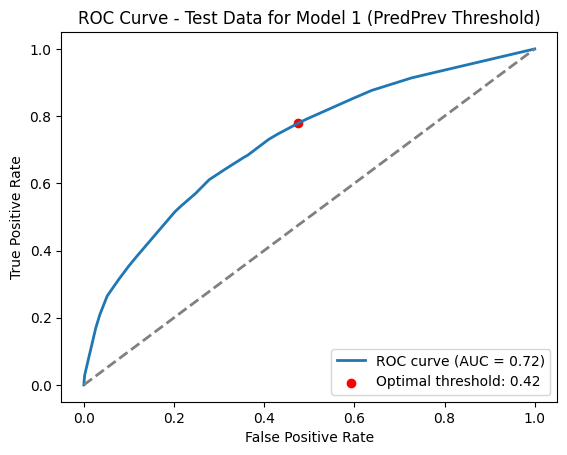


------ Metrics for Model 1 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6615493261629736
Train Log Loss: 0.6099366739174296
Train ROC AUC: 0.7256179876785607
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.79      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.702543709149276
Class 1 Train Accuracy: 0.6375240070792618

Observed churn prevalence in Training Data: 0.63
Optimal threshold (PredPrev = ObsPrev) for Training Data: 0.42
Metrics using PredPrev threshold:
Train Accuracy: 0.6851457406029223
Train Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.52      0.55    388763
           1       0.74      0.78      0.76    663

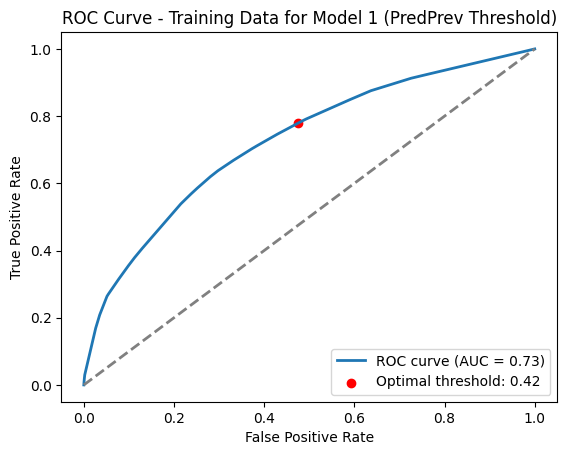


====== Metrics for Model 2 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6521151905612047
Test Log Loss: 0.61439805119243
Test ROC AUC: 0.7233021482581821
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7209221369280908
Class 1 Test Accuracy: 0.6117899905730727

Observed churn prevalence in Test Data: 0.63
Optimal threshold (PredPrev = ObsPrev) for Test Data: 0.42
Metrics using PredPrev threshold:
Test Accuracy: 0.6847517769818476
Test Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.53      0.55    166613
           1       0.74      0.78      0.76    284292

    accuracy    

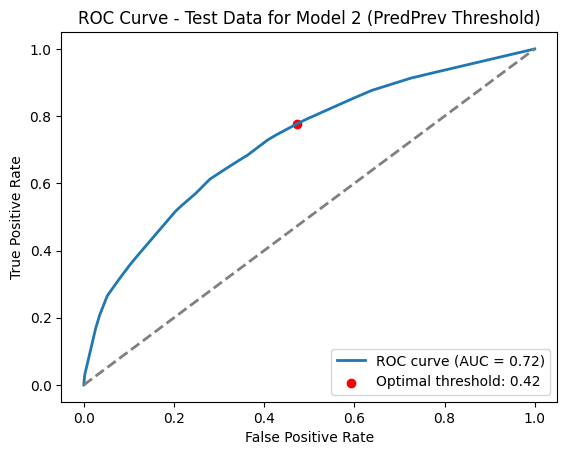


------ Metrics for Model 2 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6619048026392703
Train Log Loss: 0.6100184189502763
Train ROC AUC: 0.725637000278242
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.79      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7016948629370593
Class 1 Train Accuracy: 0.6385852933461572

Observed churn prevalence in Training Data: 0.63
Optimal threshold (PredPrev = ObsPrev) for Training Data: 0.42
Metrics using PredPrev threshold:
Train Accuracy: 0.6850830094600464
Train Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.53      0.55    388763
           1       0.74      0.78      0.76    663

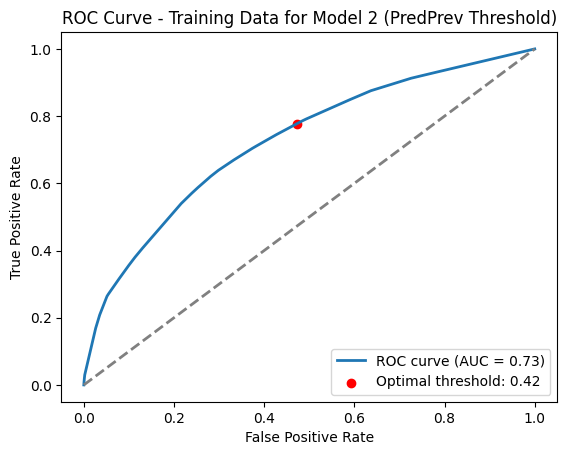


====== Metrics for Model 3 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6522349497122454
Test Log Loss: 0.6142647196890423
Test ROC AUC: 0.7231342819664113
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7205200074423964
Class 1 Test Accuracy: 0.6122156093031109

Observed churn prevalence in Test Data: 0.63
Optimal threshold (PredPrev = ObsPrev) for Test Data: 0.42
Metrics using PredPrev threshold:
Test Accuracy: 0.6848715361328883
Test Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.53      0.55    166613
           1       0.74      0.78      0.76    284292

    accuracy  

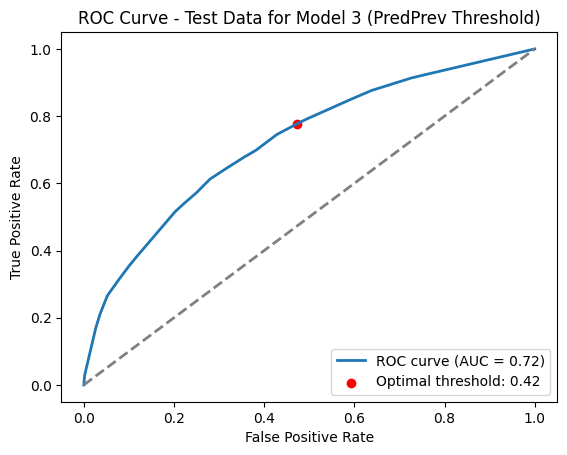


------ Metrics for Model 3 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6620739866306627
Train Log Loss: 0.6098747143387037
Train ROC AUC: 0.7256481811822147
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7008691670760849
Class 1 Train Accuracy: 0.6393375402881754

Observed churn prevalence in Training Data: 0.63
Optimal threshold (PredPrev = ObsPrev) for Training Data: 0.42
Metrics using PredPrev threshold:
Train Accuracy: 0.6851752052306368
Train Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.53      0.55    388763
           1       0.74      0.78      0.76    66

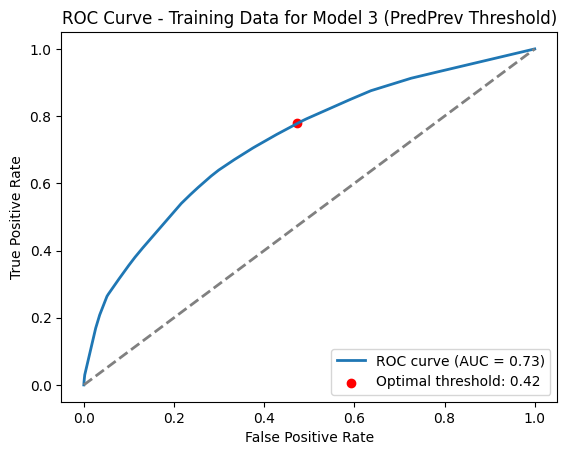


====== Metrics for Model 4 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6522482562845833
Test Log Loss: 0.6145592777244681
Test ROC AUC: 0.7228443219093907
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.65      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7188874817691296
Class 1 Test Accuracy: 0.613193477129149

Observed churn prevalence in Test Data: 0.63
Optimal threshold (PredPrev = ObsPrev) for Test Data: 0.42
Metrics using PredPrev threshold:
Test Accuracy: 0.6848848427052262
Test Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.52      0.55    166613
           1       0.74      0.78      0.76    284292

    accuracy   


------ Metrics for Model 4 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.662026463037575
Train Log Loss: 0.6100872660279613
Train ROC AUC: 0.7253421700515887
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.60    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.6991689023904024
Class 1 Train Accuracy: 0.6402586282271997

Observed churn prevalence in Training Data: 0.63
Optimal threshold (PredPrev = ObsPrev) for Training Data: 0.42
Metrics using PredPrev threshold:
Train Accuracy: 0.6851343349405813
Train Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.52      0.55    388763
           1       0.74      0.78      0.76    663


====== Metrics for Model 5 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.652361362149455
Test Log Loss: 0.614427572542802
Test ROC AUC: 0.7228874220967979
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.65      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7184973561486798
Class 1 Test Accuracy: 0.613601508308359

Observed churn prevalence in Test Data: 0.63
Optimal threshold (PredPrev = ObsPrev) for Test Data: 0.42
Metrics using PredPrev threshold:
Test Accuracy: 0.6850023840942105
Test Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.52      0.55    166613
           1       0.74      0.78      0.76    284292

    accuracy     

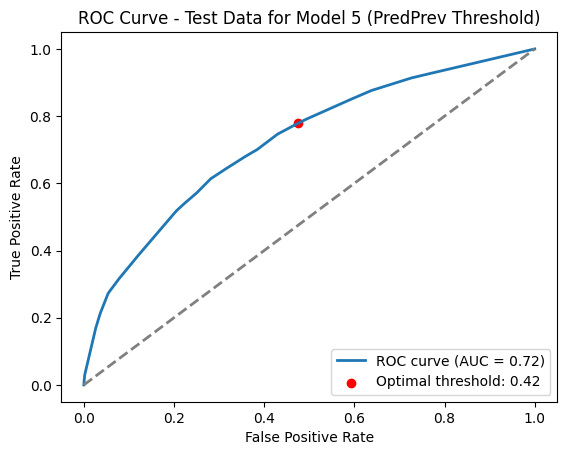


------ Metrics for Model 5 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6621196092800271
Train Log Loss: 0.6099859139364524
Train ROC AUC: 0.7253524525607105
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.60    388763
           1       0.78      0.64      0.71    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.6986493056180758
Class 1 Train Accuracy: 0.6407108808977517

Observed churn prevalence in Training Data: 0.63
Optimal threshold (PredPrev = ObsPrev) for Training Data: 0.42
Metrics using PredPrev threshold:
Train Accuracy: 0.6852265307111716
Train Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.52      0.55    388763
           1       0.74      0.78      0.76    66


====== Metrics for Model 6 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6521196260853173
Test Log Loss: 0.6143630819451887
Test ROC AUC: 0.7232933963370285
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.720688061555821
Class 1 Test Accuracy: 0.6119342084898626

Observed churn prevalence in Test Data: 0.63
Optimal threshold (PredPrev = ObsPrev) for Test Data: 0.42
Metrics using PredPrev threshold:
Test Accuracy: 0.6847673013162417
Test Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.53      0.55    166613
           1       0.74      0.78      0.76    284292

    accuracy   

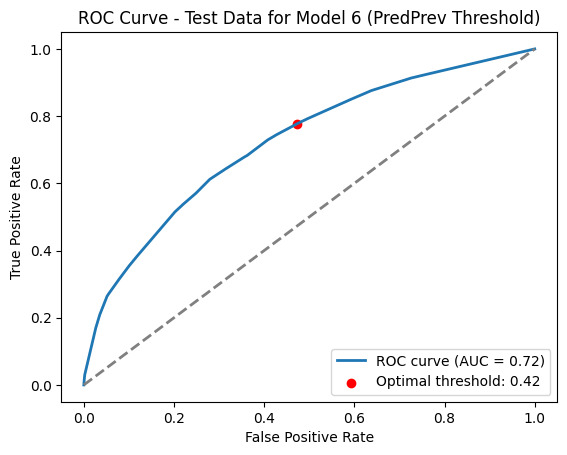


------ Metrics for Model 6 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6619456729293257
Train Log Loss: 0.6098725055269418
Train ROC AUC: 0.7256818831399152
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7014093419384047
Class 1 Train Accuracy: 0.6388174497170406

Observed churn prevalence in Training Data: 0.63
Optimal threshold (PredPrev = ObsPrev) for Training Data: 0.42
Metrics using PredPrev threshold:
Train Accuracy: 0.6851324339968577
Train Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.53      0.55    388763
           1       0.74      0.78      0.76    66


====== Metrics for Model 7 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6520220445548397
Test Log Loss: 0.6144591993429971
Test ROC AUC: 0.7231919486292897
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7210301717152924
Class 1 Test Accuracy: 0.6115789399631365

Observed churn prevalence in Test Data: 0.63
Optimal threshold (PredPrev = ObsPrev) for Test Data: 0.42
Metrics using PredPrev threshold:
Test Accuracy: 0.6847939144609175
Test Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.53      0.55    166613
           1       0.74      0.77      0.76    284292

    accuracy  


------ Metrics for Model 7 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6619304653795377
Train Log Loss: 0.6100941140933845
Train ROC AUC: 0.7256210227712521
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.79      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7017848920807793
Class 1 Train Accuracy: 0.6385732332749425

Observed churn prevalence in Training Data: 0.63
Optimal threshold (PredPrev = ObsPrev) for Training Data: 0.42
Metrics using PredPrev threshold:
Train Accuracy: 0.685271202888674
Train Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.53      0.56    388763
           1       0.74      0.77      0.76    663

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, classification_report, 
    confusion_matrix, roc_curve
)

# Train Decision Tree models on each undersampled set
models = {}
for i in range(1, 8):
    model = DecisionTreeClassifier(random_state=42, max_depth=5)
    X_train_set, y_train_set = undersampled_sets[f"set_{i}"]
    model.fit(X_train_set, y_train_set)
    models[f"model_{i}"] = model

# Evaluate each model individually on test and training data
for i in range(1, 8):
    model = models[f"model_{i}"]
    
    # ----- Test Data Evaluation -----
    print(f"\n====== Metrics for Model {i} on Test Data ======")
    # Get predictions and predicted probabilities on test data
    y_pred_test = model.predict(X_test)
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    
    # Default threshold (0.5) metrics
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_log_loss = log_loss(y_test, y_pred_proba_test)
    test_roc_auc = roc_auc_score(y_test, y_pred_proba_test)
    test_report = classification_report(y_test, y_pred_test)
    test_conf_matrix = confusion_matrix(y_test, y_pred_test)
    class_0_accuracy_test = (test_conf_matrix[0, 0] / test_conf_matrix[0].sum()) if test_conf_matrix[0].sum() != 0 else 0
    class_1_accuracy_test = (test_conf_matrix[1, 1] / test_conf_matrix[1].sum()) if test_conf_matrix[1].sum() != 0 else 0
    
    print("Default threshold (0.5) metrics:")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test Log Loss: {test_log_loss}")
    print(f"Test ROC AUC: {test_roc_auc}")
    print("Test Classification Report:")
    print(test_report)
    print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
    print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")
    
    # --- PredPrev Threshold: Matching Predicted & Observed Prevalence ---
    # Observed prevalence in test data
    obs_prev_test = np.mean(y_test)
    # Choose the threshold so that predicted churn fraction equals the observed churn rate.
    # Since predictions are made as: y_pred = (y_pred_proba >= threshold),
    # the threshold is chosen as the percentile corresponding to 100*(1 - obs_prev).
    optimal_threshold_test = np.percentile(y_pred_proba_test, 100 * (1 - obs_prev_test))
    
    print(f"\nObserved churn prevalence in Test Data: {obs_prev_test:.2f}")
    print(f"Optimal threshold (PredPrev = ObsPrev) for Test Data: {optimal_threshold_test:.2f}")
    
    # Apply the new threshold and recalc metrics
    y_pred_test_opt = (y_pred_proba_test >= optimal_threshold_test).astype(int)
    test_accuracy_opt = accuracy_score(y_test, y_pred_test_opt)
    test_report_opt = classification_report(y_test, y_pred_test_opt)
    test_conf_matrix_opt = confusion_matrix(y_test, y_pred_test_opt)
    class_0_accuracy_test_opt = (test_conf_matrix_opt[0, 0] / test_conf_matrix_opt[0].sum()) if test_conf_matrix_opt[0].sum() != 0 else 0
    class_1_accuracy_test_opt = (test_conf_matrix_opt[1, 1] / test_conf_matrix_opt[1].sum()) if test_conf_matrix_opt[1].sum() != 0 else 0
    
    print("Metrics using PredPrev threshold:")
    print(f"Test Accuracy: {test_accuracy_opt}")
    print("Test Classification Report:")
    print(test_report_opt)
    print(f"Class 0 Test Accuracy: {class_0_accuracy_test_opt}")
    print(f"Class 1 Test Accuracy: {class_1_accuracy_test_opt}")
    
    # Plot ROC curve for test data with the PredPrev threshold marked
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
    # Find the index of the threshold closest to our chosen threshold for plotting
    idx_test = np.argmin(np.abs(thresholds - optimal_threshold_test))
    
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {test_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.scatter(fpr[idx_test], tpr[idx_test], color='red', label=f'Optimal threshold: {optimal_threshold_test:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Test Data for Model {i} (PredPrev Threshold)')
    plt.legend(loc="lower right")
    plt.show()
    
    # ----- Training Data Evaluation -----
    print(f"\n------ Metrics for Model {i} on Training Data ------")
    # Get predictions and predicted probabilities on training data
    y_pred_train = model.predict(X_train)
    y_pred_proba_train = model.predict_proba(X_train)[:, 1]
    
    # Default threshold (0.5) metrics for training data
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_log_loss = log_loss(y_train, y_pred_proba_train)
    train_roc_auc = roc_auc_score(y_train, y_pred_proba_train)
    train_report = classification_report(y_train, y_pred_train)
    train_conf_matrix = confusion_matrix(y_train, y_pred_train)
    class_0_accuracy_train = (train_conf_matrix[0, 0] / train_conf_matrix[0].sum()) if train_conf_matrix[0].sum() != 0 else 0
    class_1_accuracy_train = (train_conf_matrix[1, 1] / train_conf_matrix[1].sum()) if train_conf_matrix[1].sum() != 0 else 0
    
    print("Default threshold (0.5) metrics:")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Train Log Loss: {train_log_loss}")
    print(f"Train ROC AUC: {train_roc_auc}")
    print("Train Classification Report:")
    print(train_report)
    print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
    print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")
    
    # --- PredPrev Threshold for Training Data ---
    obs_prev_train = np.mean(y_train)
    optimal_threshold_train = np.percentile(y_pred_proba_train, 100 * (1 - obs_prev_train))
    
    print(f"\nObserved churn prevalence in Training Data: {obs_prev_train:.2f}")
    print(f"Optimal threshold (PredPrev = ObsPrev) for Training Data: {optimal_threshold_train:.2f}")
    
    y_pred_train_opt = (y_pred_proba_train >= optimal_threshold_train).astype(int)
    train_accuracy_opt = accuracy_score(y_train, y_pred_train_opt)
    train_report_opt = classification_report(y_train, y_pred_train_opt)
    train_conf_matrix_opt = confusion_matrix(y_train, y_pred_train_opt)
    class_0_accuracy_train_opt = (train_conf_matrix_opt[0, 0] / train_conf_matrix_opt[0].sum()) if train_conf_matrix_opt[0].sum() != 0 else 0
    class_1_accuracy_train_opt = (train_conf_matrix_opt[1, 1] / train_conf_matrix_opt[1].sum()) if train_conf_matrix_opt[1].sum() != 0 else 0
    
    print("Metrics using PredPrev threshold:")
    print(f"Train Accuracy: {train_accuracy_opt}")
    print("Train Classification Report:")
    print(train_report_opt)
    print(f"Class 0 Train Accuracy: {class_0_accuracy_train_opt}")
    print(f"Class 1 Train Accuracy: {class_1_accuracy_train_opt}")
    
    # Plot ROC curve for training data with the PredPrev threshold marked
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_proba_train)
    idx_train = np.argmin(np.abs(thresholds_train - optimal_threshold_train))
    
    plt.figure()
    plt.plot(fpr_train, tpr_train, lw=2, label=f'ROC curve (AUC = {train_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.scatter(fpr_train[idx_train], tpr_train[idx_train], color='red', label=f'Optimal threshold: {optimal_threshold_train:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Training Data for Model {i} (PredPrev Threshold)')
    plt.legend(loc="lower right")
    plt.show()


====== Metrics for Model 1 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6518601479247291
Test Log Loss: 0.6142614973875365
Test ROC AUC: 0.7233915620057213
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.61    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7219604712717494
Class 1 Test Accuracy: 0.6107769476453787


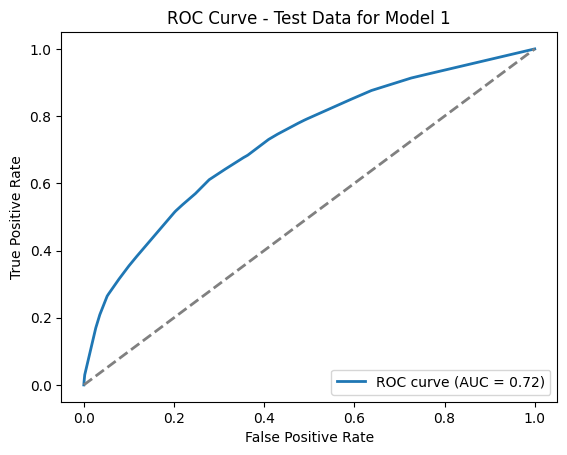


Optimal threshold (MinROCdist) for Test Data: 0.48
Metrics using optimal threshold (MinROCdist):
Test Accuracy: 0.6584934742351493
Test Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.69      0.60    166613
           1       0.78      0.64      0.70    284292

    accuracy                           0.66    450905
   macro avg       0.65      0.66      0.65    450905
weighted avg       0.69      0.66      0.66    450905

Class 0 Test Accuracy: 0.6864890494739306
Class 1 Test Accuracy: 0.6420863056294233


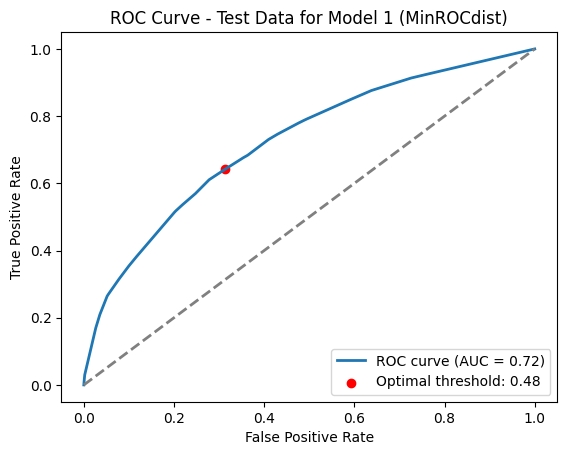


------ Metrics for Model 1 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6615493261629736
Train Log Loss: 0.6099366739174296
Train ROC AUC: 0.7256179876785607
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.79      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.702543709149276
Class 1 Train Accuracy: 0.6375240070792618


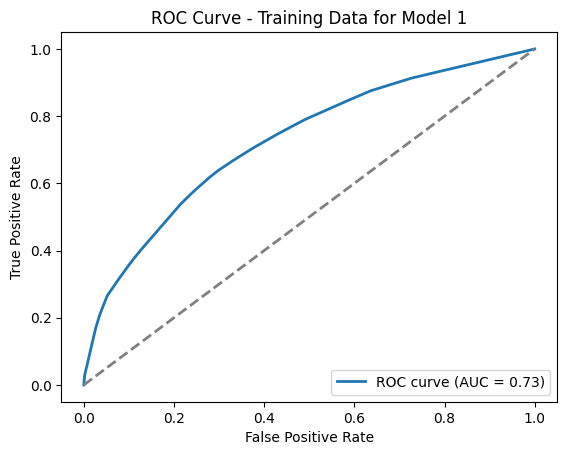


Optimal threshold (MinROCdist) for Training Data: 0.52
Metrics using optimal threshold (MinROCdist):
Train Accuracy: 0.6615493261629736
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.79      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.702543709149276
Class 1 Train Accuracy: 0.6375240070792618



====== Metrics for Model 2 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6521151905612047
Test Log Loss: 0.61439805119243
Test ROC AUC: 0.7233021482581821
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7209221369280908
Class 1 Test Accuracy: 0.6117899905730727


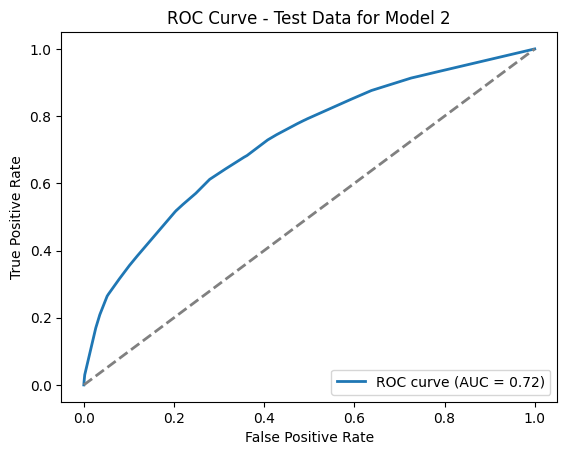


Optimal threshold (MinROCdist) for Test Data: 0.47
Metrics using optimal threshold (MinROCdist):
Test Accuracy: 0.6587485168716248
Test Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.69      0.60    166613
           1       0.78      0.64      0.70    284292

    accuracy                           0.66    450905
   macro avg       0.65      0.66      0.65    450905
weighted avg       0.69      0.66      0.66    450905

Class 0 Test Accuracy: 0.6854507151302719
Class 1 Test Accuracy: 0.6430993485571174



------ Metrics for Model 2 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6619048026392703
Train Log Loss: 0.6100184189502763
Train ROC AUC: 0.725637000278242
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.79      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7016948629370593
Class 1 Train Accuracy: 0.6385852933461572


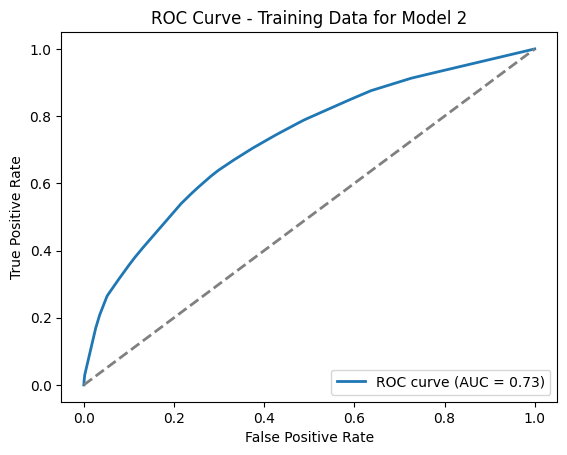


Optimal threshold (MinROCdist) for Training Data: 0.51
Metrics using optimal threshold (MinROCdist):
Train Accuracy: 0.6619048026392703
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.79      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7016948629370593
Class 1 Train Accuracy: 0.6385852933461572


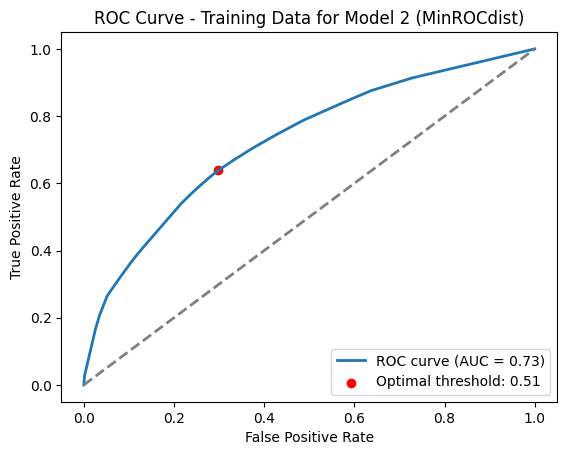


====== Metrics for Model 3 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6522349497122454
Test Log Loss: 0.6142647196890423
Test ROC AUC: 0.7231342819664113
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7205200074423964
Class 1 Test Accuracy: 0.6122156093031109


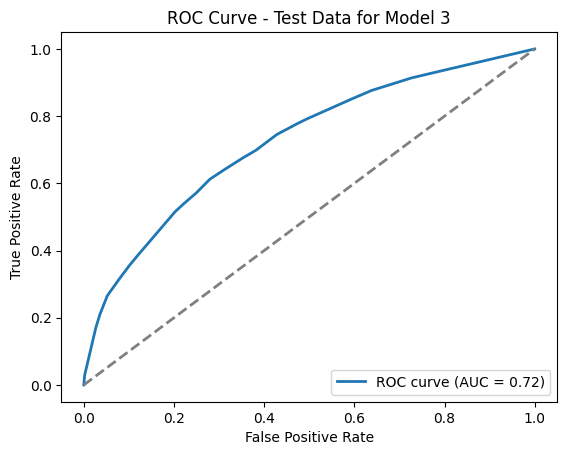


Optimal threshold (MinROCdist) for Test Data: 0.47
Metrics using optimal threshold (MinROCdist):
Test Accuracy: 0.6588682760226655
Test Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.69      0.60    166613
           1       0.78      0.64      0.70    284292

    accuracy                           0.66    450905
   macro avg       0.65      0.66      0.65    450905
weighted avg       0.69      0.66      0.66    450905

Class 0 Test Accuracy: 0.6850485856445776
Class 1 Test Accuracy: 0.6435249672871555


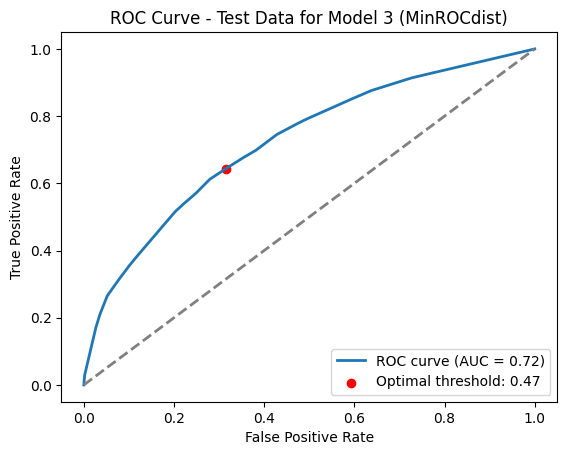


------ Metrics for Model 3 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6620739866306627
Train Log Loss: 0.6098747143387037
Train ROC AUC: 0.7256481811822147
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7008691670760849
Class 1 Train Accuracy: 0.6393375402881754


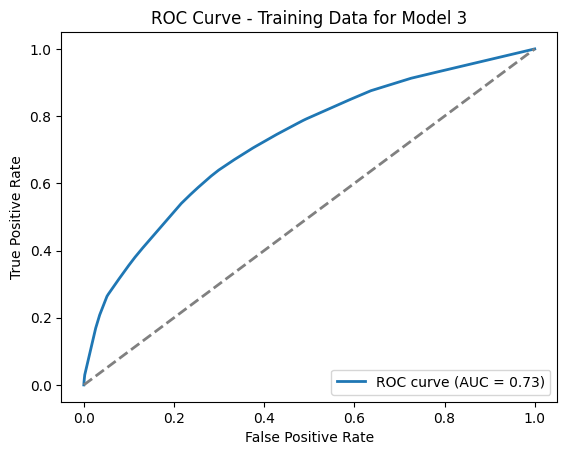


Optimal threshold (MinROCdist) for Training Data: 0.52
Metrics using optimal threshold (MinROCdist):
Train Accuracy: 0.6620739866306627
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7008691670760849
Class 1 Train Accuracy: 0.6393375402881754


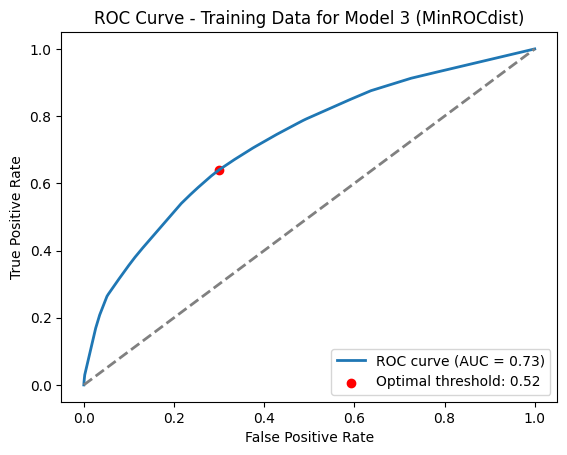


====== Metrics for Model 4 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6522482562845833
Test Log Loss: 0.6145592777244681
Test ROC AUC: 0.7228443219093907
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.65      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7188874817691296
Class 1 Test Accuracy: 0.613193477129149


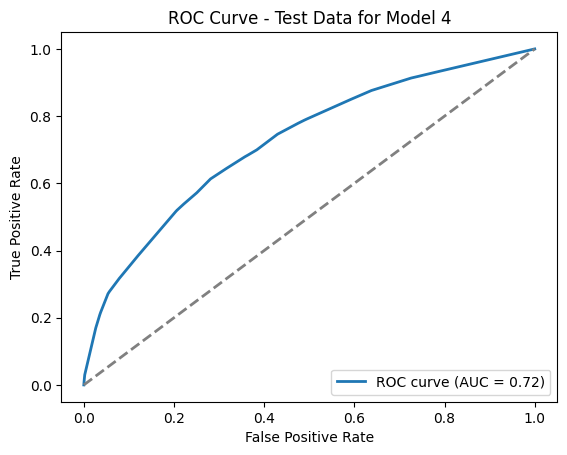


Optimal threshold (MinROCdist) for Test Data: 0.47
Metrics using optimal threshold (MinROCdist):
Test Accuracy: 0.6588815825950034
Test Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.68      0.60    166613
           1       0.78      0.64      0.70    284292

    accuracy                           0.66    450905
   macro avg       0.65      0.66      0.65    450905
weighted avg       0.69      0.66      0.66    450905

Class 0 Test Accuracy: 0.6834160599713107
Class 1 Test Accuracy: 0.6445028351131935


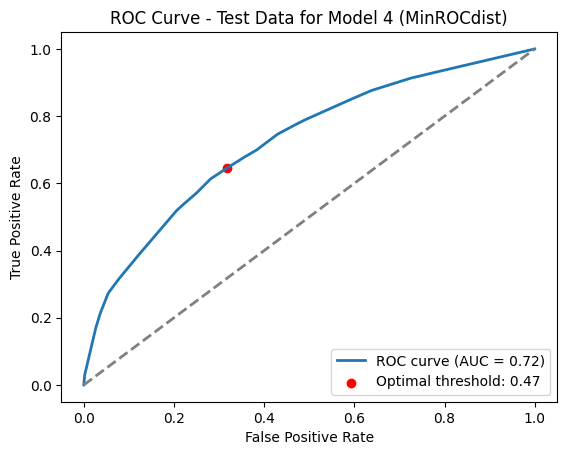


------ Metrics for Model 4 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.662026463037575
Train Log Loss: 0.6100872660279613
Train ROC AUC: 0.7253421700515887
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.60    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.6991689023904024
Class 1 Train Accuracy: 0.6402586282271997


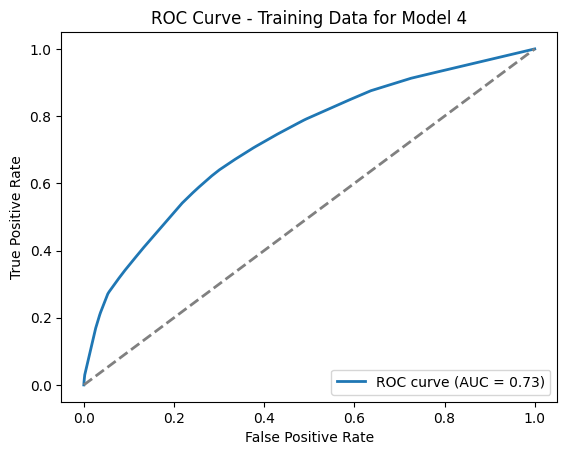


Optimal threshold (MinROCdist) for Training Data: 0.51
Metrics using optimal threshold (MinROCdist):
Train Accuracy: 0.662026463037575
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.60    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.6991689023904024
Class 1 Train Accuracy: 0.6402586282271997


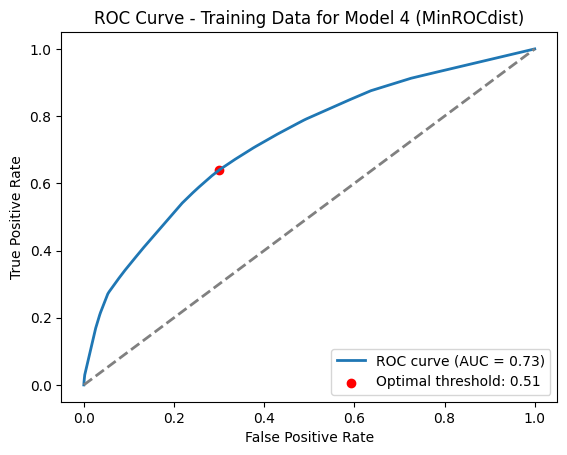


====== Metrics for Model 5 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.652361362149455
Test Log Loss: 0.614427572542802
Test ROC AUC: 0.7228874220967979
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.65      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7184973561486798
Class 1 Test Accuracy: 0.613601508308359


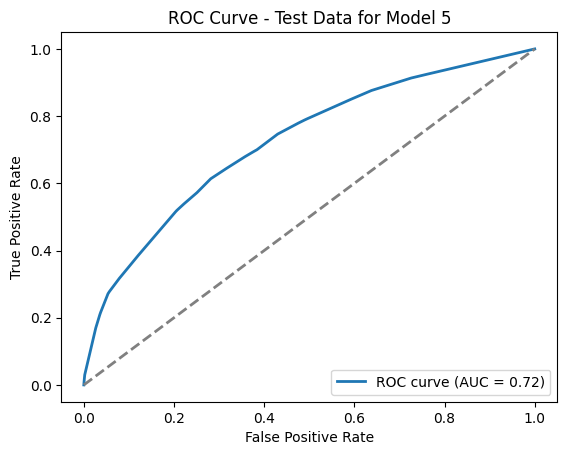


Optimal threshold (MinROCdist) for Test Data: 0.48
Metrics using optimal threshold (MinROCdist):
Test Accuracy: 0.6589946884598752
Test Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.68      0.60    166613
           1       0.78      0.64      0.70    284292

    accuracy                           0.66    450905
   macro avg       0.65      0.66      0.65    450905
weighted avg       0.69      0.66      0.66    450905

Class 0 Test Accuracy: 0.683025934350861
Class 1 Test Accuracy: 0.6449108662924036


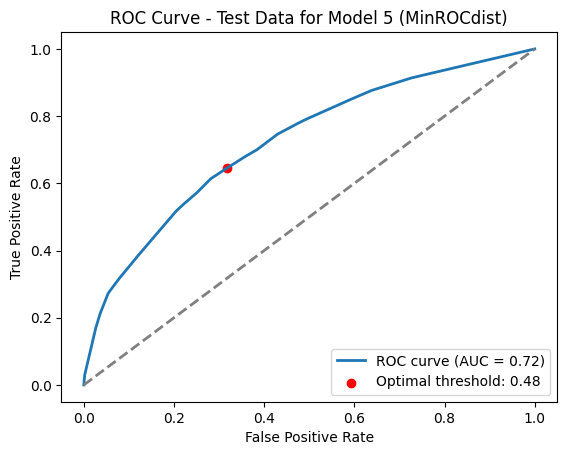


------ Metrics for Model 5 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6621196092800271
Train Log Loss: 0.6099859139364524
Train ROC AUC: 0.7253524525607105
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.60    388763
           1       0.78      0.64      0.71    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.6986493056180758
Class 1 Train Accuracy: 0.6407108808977517


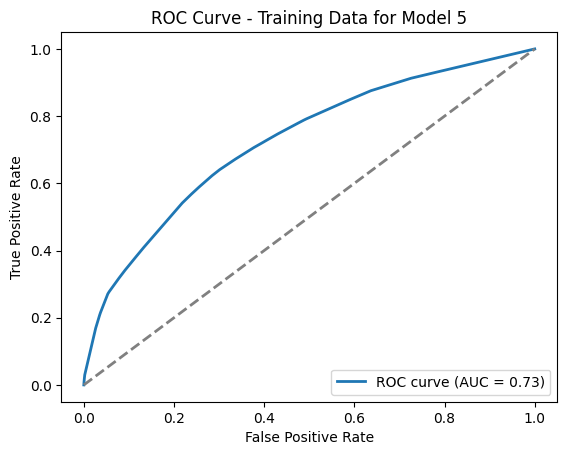


Optimal threshold (MinROCdist) for Training Data: 0.51
Metrics using optimal threshold (MinROCdist):
Train Accuracy: 0.6621196092800271
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.60    388763
           1       0.78      0.64      0.71    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.6986493056180758
Class 1 Train Accuracy: 0.6407108808977517


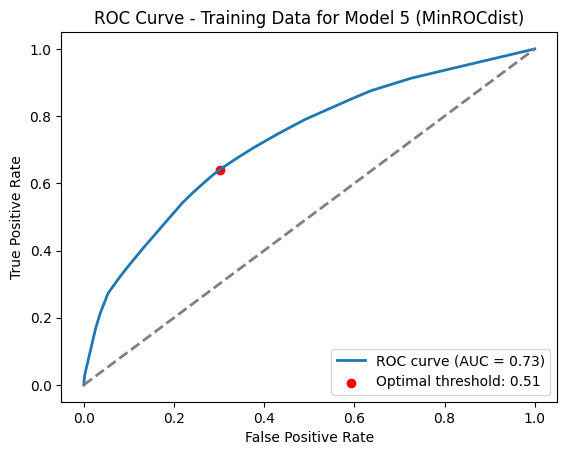


====== Metrics for Model 6 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6521196260853173
Test Log Loss: 0.6143630819451887
Test ROC AUC: 0.7232933963370285
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.720688061555821
Class 1 Test Accuracy: 0.6119342084898626


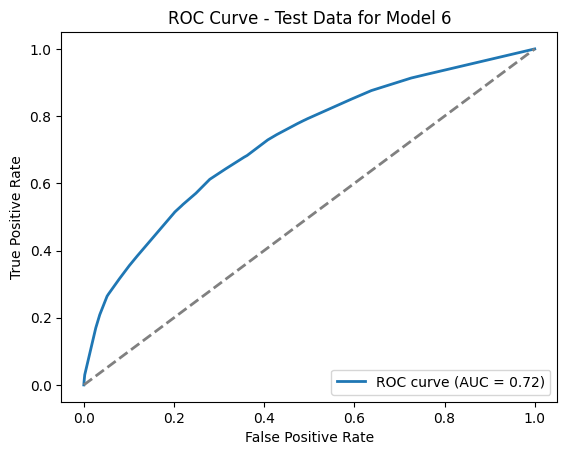


Optimal threshold (MinROCdist) for Test Data: 0.47
Metrics using optimal threshold (MinROCdist):
Test Accuracy: 0.6587640412060191
Test Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.69      0.60    166613
           1       0.78      0.64      0.70    284292

    accuracy                           0.66    450905
   macro avg       0.65      0.66      0.65    450905
weighted avg       0.69      0.66      0.66    450905

Class 0 Test Accuracy: 0.6852106378253797
Class 1 Test Accuracy: 0.6432646715349007


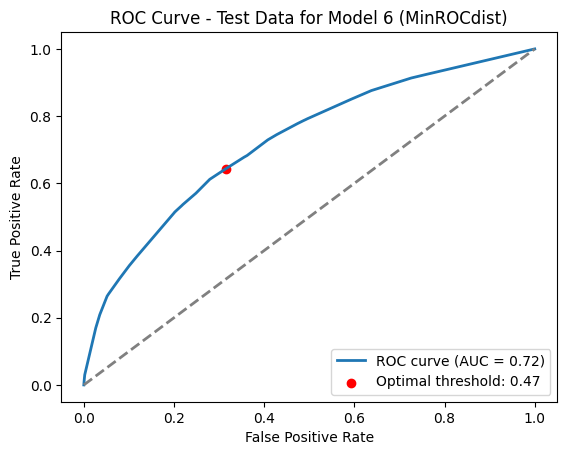


------ Metrics for Model 6 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6619456729293257
Train Log Loss: 0.6098725055269418
Train ROC AUC: 0.7256818831399152
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7014093419384047
Class 1 Train Accuracy: 0.6388174497170406


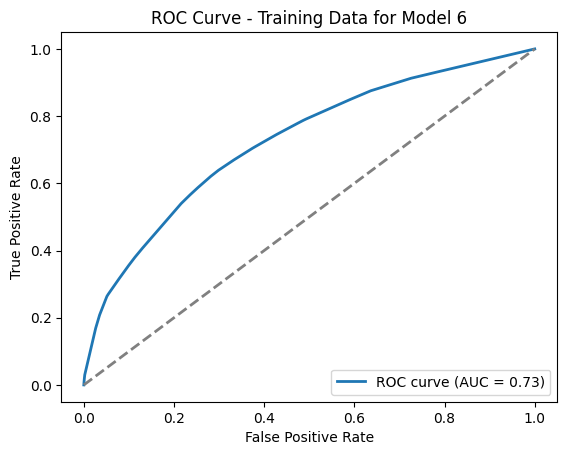


Optimal threshold (MinROCdist) for Training Data: 0.51
Metrics using optimal threshold (MinROCdist):
Train Accuracy: 0.6619456729293257
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7014093419384047
Class 1 Train Accuracy: 0.6388174497170406


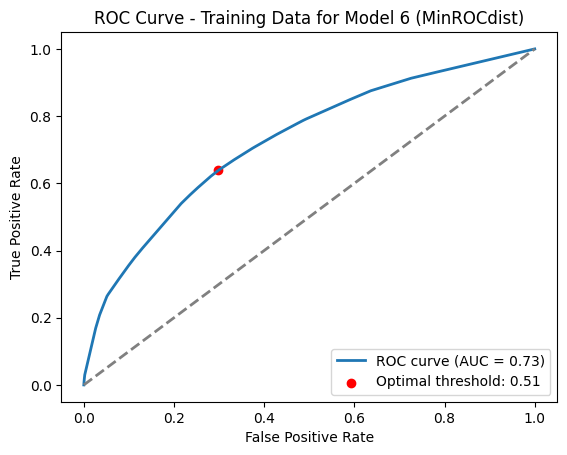


====== Metrics for Model 7 on Test Data ======
Default threshold (0.5) metrics:
Test Accuracy: 0.6520220445548397
Test Log Loss: 0.6144591993429971
Test ROC AUC: 0.7231919486292897
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7210301717152924
Class 1 Test Accuracy: 0.6115789399631365


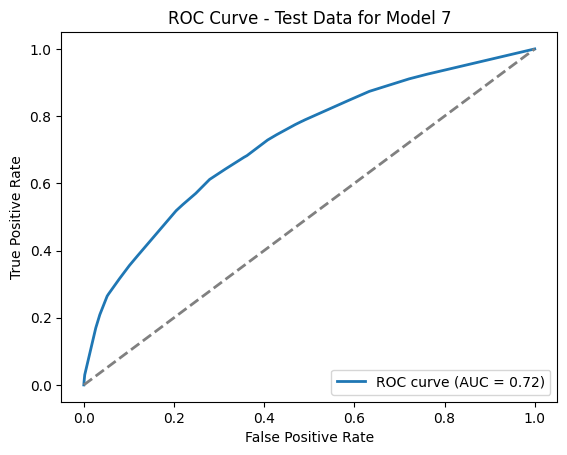


Optimal threshold (MinROCdist) for Test Data: 0.47
Metrics using optimal threshold (MinROCdist):
Test Accuracy: 0.6586553708652598
Test Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.69      0.60    166613
           1       0.78      0.64      0.70    284292

    accuracy                           0.66    450905
   macro avg       0.65      0.66      0.65    450905
weighted avg       0.69      0.66      0.66    450905

Class 0 Test Accuracy: 0.6855587499174735
Class 1 Test Accuracy: 0.642888297947181


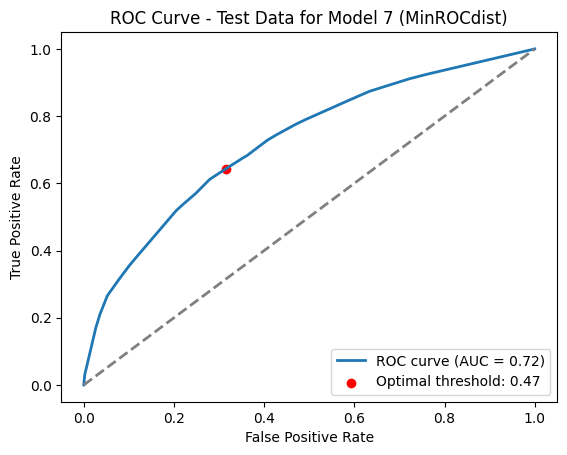


------ Metrics for Model 7 on Training Data ------
Default threshold (0.5) metrics:
Train Accuracy: 0.6619304653795377
Train Log Loss: 0.6100941140933845
Train ROC AUC: 0.7256210227712521
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.79      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7017848920807793
Class 1 Train Accuracy: 0.6385732332749425


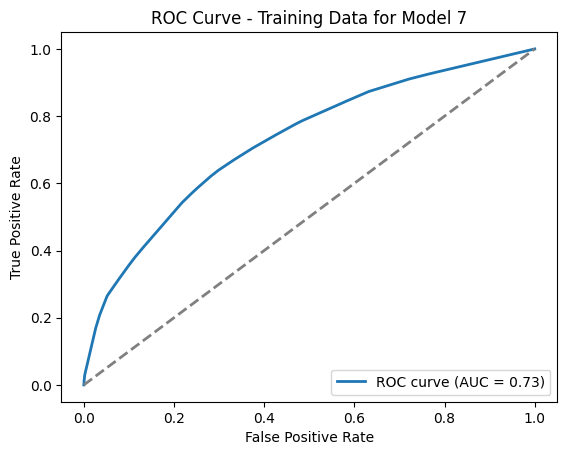


Optimal threshold (MinROCdist) for Training Data: 0.52
Metrics using optimal threshold (MinROCdist):
Train Accuracy: 0.6619304653795377
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.79      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7017848920807793
Class 1 Train Accuracy: 0.6385732332749425


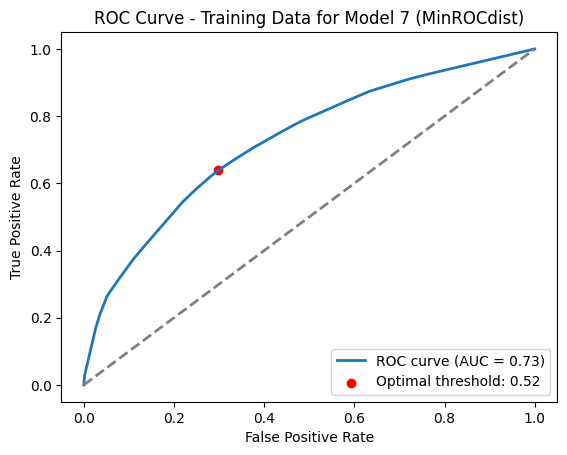

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, classification_report, 
    confusion_matrix, roc_curve
)

# Train Decision Tree models on each undersampled set
models = {}
for i in range(1, 8):
    model = DecisionTreeClassifier(random_state=42, max_depth=5)
    X_train_set, y_train_set = undersampled_sets[f"set_{i}"]
    model.fit(X_train_set, y_train_set)
    models[f"model_{i}"] = model

# Evaluate each model individually on test and training data
for i in range(1, 8):
    model = models[f"model_{i}"]
    
    # ----- Test Data Evaluation -----
    print(f"\n====== Metrics for Model {i} on Test Data ======")
    # Get predictions and predicted probabilities on test data
    y_pred_test = model.predict(X_test)
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    
    # Compute default threshold (0.5) metrics
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_log_loss = log_loss(y_test, y_pred_proba_test)
    test_roc_auc = roc_auc_score(y_test, y_pred_proba_test)
    test_report = classification_report(y_test, y_pred_test)
    test_conf_matrix = confusion_matrix(y_test, y_pred_test)
    class_0_accuracy_test = (test_conf_matrix[0, 0] / test_conf_matrix[0].sum()) if test_conf_matrix[0].sum() != 0 else 0
    class_1_accuracy_test = (test_conf_matrix[1, 1] / test_conf_matrix[1].sum()) if test_conf_matrix[1].sum() != 0 else 0
    
    print("Default threshold (0.5) metrics:")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test Log Loss: {test_log_loss}")
    print(f"Test ROC AUC: {test_roc_auc}")
    print("Test Classification Report:")
    print(test_report)
    print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
    print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")
    
    # Plot baseline ROC curve for test data
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {test_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Test Data for Model {i}')
    plt.legend(loc="lower right")
    plt.show()
    
    # ---- Find Optimal Threshold (MinROCdist) for Test Data ----
    # Compute the Euclidean distance from each ROC point to (0,1)
    distances = np.sqrt(fpr**2 + (1 - tpr)**2)
    idx = np.argmin(distances)
    optimal_threshold = thresholds[idx]
    print(f"\nOptimal threshold (MinROCdist) for Test Data: {optimal_threshold:.2f}")
    
    # Compute predictions using the optimal threshold and recalc metrics
    y_pred_test_opt = (y_pred_proba_test >= optimal_threshold).astype(int)
    test_accuracy_opt = accuracy_score(y_test, y_pred_test_opt)
    test_report_opt = classification_report(y_test, y_pred_test_opt)
    test_conf_matrix_opt = confusion_matrix(y_test, y_pred_test_opt)
    class_0_accuracy_test_opt = (test_conf_matrix_opt[0, 0] / test_conf_matrix_opt[0].sum()) if test_conf_matrix_opt[0].sum() != 0 else 0
    class_1_accuracy_test_opt = (test_conf_matrix_opt[1, 1] / test_conf_matrix_opt[1].sum()) if test_conf_matrix_opt[1].sum() != 0 else 0
    
    print("Metrics using optimal threshold (MinROCdist):")
    print(f"Test Accuracy: {test_accuracy_opt}")
    print("Test Classification Report:")
    print(test_report_opt)
    print(f"Class 0 Test Accuracy: {class_0_accuracy_test_opt}")
    print(f"Class 1 Test Accuracy: {class_1_accuracy_test_opt}")
    
    # Plot ROC curve and mark the optimal threshold point for test data
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {test_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.scatter(fpr[idx], tpr[idx], color='red', label=f'Optimal threshold: {optimal_threshold:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Test Data for Model {i} (MinROCdist)')
    plt.legend(loc="lower right")
    plt.show()
    
    # ----- Training Data Evaluation -----
    print(f"\n------ Metrics for Model {i} on Training Data ------")
    # Get predictions and predicted probabilities on training data
    y_pred_train = model.predict(X_train)
    y_pred_proba_train = model.predict_proba(X_train)[:, 1]
    
    # Compute default threshold (0.5) metrics for training data
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_log_loss = log_loss(y_train, y_pred_proba_train)
    train_roc_auc = roc_auc_score(y_train, y_pred_proba_train)
    train_report = classification_report(y_train, y_pred_train)
    train_conf_matrix = confusion_matrix(y_train, y_pred_train)
    class_0_accuracy_train = (train_conf_matrix[0, 0] / train_conf_matrix[0].sum()) if train_conf_matrix[0].sum() != 0 else 0
    class_1_accuracy_train = (train_conf_matrix[1, 1] / train_conf_matrix[1].sum()) if train_conf_matrix[1].sum() != 0 else 0
    
    print("Default threshold (0.5) metrics:")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Train Log Loss: {train_log_loss}")
    print(f"Train ROC AUC: {train_roc_auc}")
    print("Train Classification Report:")
    print(train_report)
    print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
    print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")
    
    # Plot baseline ROC curve for training data
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_proba_train)
    plt.figure()
    plt.plot(fpr_train, tpr_train, lw=2, label=f'ROC curve (AUC = {train_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Training Data for Model {i}')
    plt.legend(loc="lower right")
    plt.show()
    
    # ---- Find Optimal Threshold (MinROCdist) for Training Data ----
    distances_train = np.sqrt(fpr_train**2 + (1 - tpr_train)**2)
    idx_train = np.argmin(distances_train)
    optimal_threshold_train = thresholds_train[idx_train]
    print(f"\nOptimal threshold (MinROCdist) for Training Data: {optimal_threshold_train:.2f}")
    
    # Compute predictions using the optimal threshold on training data
    y_pred_train_opt = (y_pred_proba_train >= optimal_threshold_train).astype(int)
    train_accuracy_opt = accuracy_score(y_train, y_pred_train_opt)
    train_report_opt = classification_report(y_train, y_pred_train_opt)
    train_conf_matrix_opt = confusion_matrix(y_train, y_pred_train_opt)
    class_0_accuracy_train_opt = (train_conf_matrix_opt[0, 0] / train_conf_matrix_opt[0].sum()) if train_conf_matrix_opt[0].sum() != 0 else 0
    class_1_accuracy_train_opt = (train_conf_matrix_opt[1, 1] / train_conf_matrix_opt[1].sum()) if train_conf_matrix_opt[1].sum() != 0 else 0
    
    print("Metrics using optimal threshold (MinROCdist):")
    print(f"Train Accuracy: {train_accuracy_opt}")
    print("Train Classification Report:")
    print(train_report_opt)
    print(f"Class 0 Train Accuracy: {class_0_accuracy_train_opt}")
    print(f"Class 1 Train Accuracy: {class_1_accuracy_train_opt}")
    
    # Plot ROC curve for training data and mark the optimal threshold point
    plt.figure()
    plt.plot(fpr_train, tpr_train, lw=2, label=f'ROC curve (AUC = {train_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.scatter(fpr_train[idx_train], tpr_train[idx_train], color='red', label=f'Optimal threshold: {optimal_threshold_train:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Training Data for Model {i} (MinROCdist)')
    plt.legend(loc="lower right")
    plt.show()

Voting Classifier (Ensemble) Test Data - Default threshold (0.5) metrics:
Test Accuracy: 0.6522948292877657
Test Log Loss: 0.6142075288417621
Test ROC AUC: 0.7234366146389619
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.61    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7208141021408894
Class 1 Test Accuracy: 0.6121382240794676


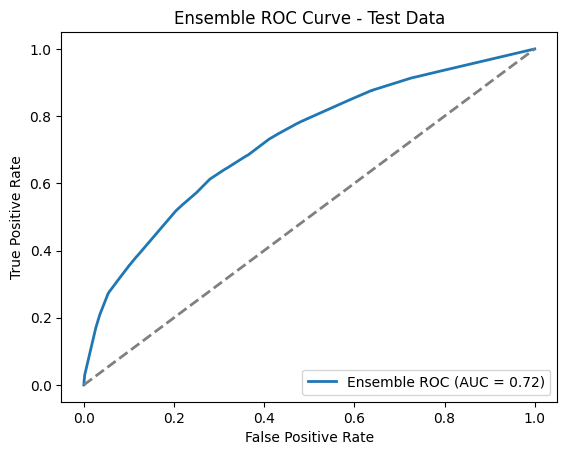


Optimal threshold (MinROCdist) for Ensemble Test Data: 0.47
Ensemble Test Data - Metrics using optimal threshold (MinROCdist):
Test Accuracy: 0.6589414621705237
Test Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.69      0.60    166613
           1       0.78      0.64      0.70    284292

    accuracy                           0.66    450905
   macro avg       0.65      0.66      0.65    450905
weighted avg       0.69      0.66      0.66    450905

Class 0 Test Accuracy: 0.6853246745452035
Class 1 Test Accuracy: 0.6434792396550026


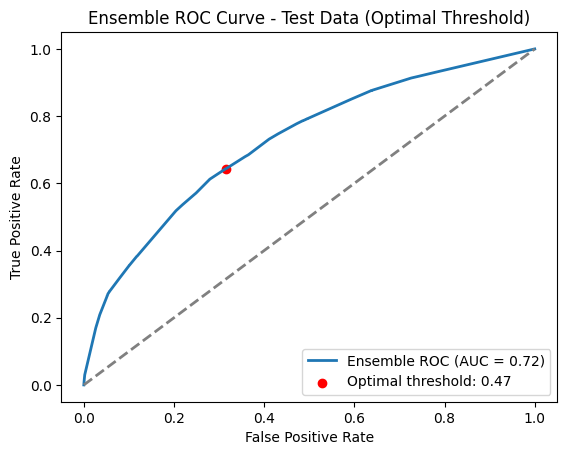


Voting Classifier (Ensemble) Training Data - Default threshold (0.5) metrics:
Train Accuracy: 0.6621129559769948
Train Log Loss: 0.6097903653897697
Train ROC AUC: 0.725821522034914
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7012935901821933
Class 1 Train Accuracy: 0.6391506091843472


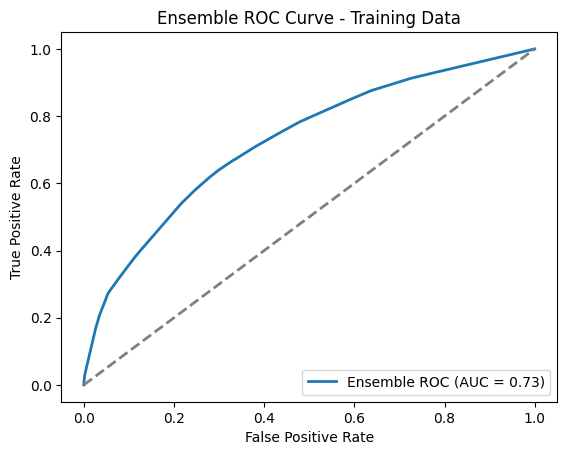


Optimal threshold (MinROCdist) for Ensemble Training Data: 0.47
Ensemble Training Data - Metrics using optimal threshold (MinROCdist):
Train Accuracy: 0.6621310149423681
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7012421449572105
Class 1 Train Accuracy: 0.639209402031519


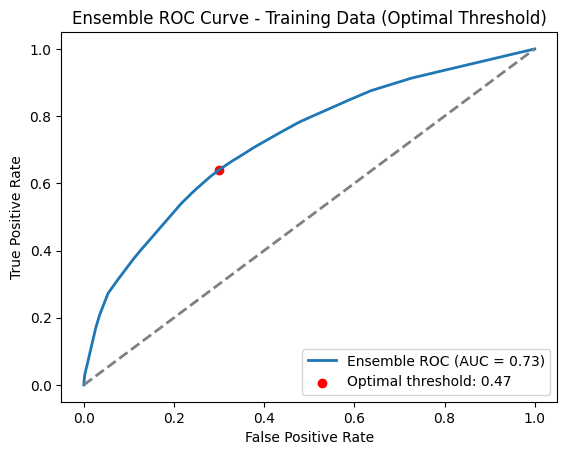

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, classification_report, 
    confusion_matrix, roc_curve
)

# -------------------------------
# Train 7 Decision Tree models on each undersampled set
# -------------------------------
models = {}
for i in range(1, 8):
    model = DecisionTreeClassifier(random_state=42, max_depth=5)
    X_train_set, y_train_set = undersampled_sets[f"set_{i}"]
    model.fit(X_train_set, y_train_set)
    models[f"model_{i}"] = model

# -------------------------------
# Voting Classifier (Ensemble) - Test Data Evaluation
# -------------------------------

# Get predicted probabilities for test data from each model and average them.
ensemble_pred_proba_test = np.mean([model.predict_proba(X_test)[:, 1] for model in models.values()], axis=0)
# Default ensemble predictions with threshold 0.5
ensemble_pred_test_default = (ensemble_pred_proba_test >= 0.5).astype(int)

# Compute metrics with default threshold (0.5)
test_accuracy_default = accuracy_score(y_test, ensemble_pred_test_default)
test_log_loss_default = log_loss(y_test, ensemble_pred_proba_test)
test_roc_auc_default = roc_auc_score(y_test, ensemble_pred_proba_test)
test_report_default = classification_report(y_test, ensemble_pred_test_default)
test_conf_matrix_default = confusion_matrix(y_test, ensemble_pred_test_default)
class_0_accuracy_default = (test_conf_matrix_default[0, 0] / test_conf_matrix_default[0].sum()) if test_conf_matrix_default[0].sum() != 0 else 0
class_1_accuracy_default = (test_conf_matrix_default[1, 1] / test_conf_matrix_default[1].sum()) if test_conf_matrix_default[1].sum() != 0 else 0

print("Voting Classifier (Ensemble) Test Data - Default threshold (0.5) metrics:")
print(f"Test Accuracy: {test_accuracy_default}")
print(f"Test Log Loss: {test_log_loss_default}")
print(f"Test ROC AUC: {test_roc_auc_default}")
print("Test Classification Report:")
print(test_report_default)
print(f"Class 0 Test Accuracy: {class_0_accuracy_default}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_default}")

# Plot baseline ROC curve for ensemble test data
fpr, tpr, thresholds = roc_curve(y_test, ensemble_pred_proba_test)
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'Ensemble ROC (AUC = {test_roc_auc_default:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ensemble ROC Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# ---- Find Optimal Threshold (MinROCdist) for Ensemble Test Data ----
# Compute Euclidean distances from each ROC point to the ideal point (0,1)
distances = np.sqrt(fpr**2 + (1 - tpr)**2)
idx = np.argmin(distances)
optimal_threshold_test = thresholds[idx]
print(f"\nOptimal threshold (MinROCdist) for Ensemble Test Data: {optimal_threshold_test:.2f}")

# Ensemble predictions using the optimal threshold
ensemble_pred_test_opt = (ensemble_pred_proba_test >= optimal_threshold_test).astype(int)
test_accuracy_opt = accuracy_score(y_test, ensemble_pred_test_opt)
test_report_opt = classification_report(y_test, ensemble_pred_test_opt)
test_conf_matrix_opt = confusion_matrix(y_test, ensemble_pred_test_opt)
class_0_accuracy_opt = (test_conf_matrix_opt[0, 0] / test_conf_matrix_opt[0].sum()) if test_conf_matrix_opt[0].sum() != 0 else 0
class_1_accuracy_opt = (test_conf_matrix_opt[1, 1] / test_conf_matrix_opt[1].sum()) if test_conf_matrix_opt[1].sum() != 0 else 0

print("Ensemble Test Data - Metrics using optimal threshold (MinROCdist):")
print(f"Test Accuracy: {test_accuracy_opt}")
print("Test Classification Report:")
print(test_report_opt)
print(f"Class 0 Test Accuracy: {class_0_accuracy_opt}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_opt}")

plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'Ensemble ROC (AUC = {test_roc_auc_default:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.scatter(fpr[idx], tpr[idx], color='red', label=f'Optimal threshold: {optimal_threshold_test:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ensemble ROC Curve - Test Data (Optimal Threshold)')
plt.legend(loc="lower right")
plt.show()

# -------------------------------
# Voting Classifier (Ensemble) - Training Data Evaluation
# -------------------------------

# Get predicted probabilities for training data from each model and average them.
ensemble_pred_proba_train = np.mean([model.predict_proba(X_train)[:, 1] for model in models.values()], axis=0)
# Default ensemble predictions with threshold 0.5
ensemble_pred_train_default = (ensemble_pred_proba_train >= 0.5).astype(int)

# Compute metrics with default threshold (0.5)
train_accuracy_default = accuracy_score(y_train, ensemble_pred_train_default)
train_log_loss_default = log_loss(y_train, ensemble_pred_proba_train)
train_roc_auc_default = roc_auc_score(y_train, ensemble_pred_proba_train)
train_report_default = classification_report(y_train, ensemble_pred_train_default)
train_conf_matrix_default = confusion_matrix(y_train, ensemble_pred_train_default)
class_0_accuracy_train_default = (train_conf_matrix_default[0, 0] / train_conf_matrix_default[0].sum()) if train_conf_matrix_default[0].sum() != 0 else 0
class_1_accuracy_train_default = (train_conf_matrix_default[1, 1] / train_conf_matrix_default[1].sum()) if train_conf_matrix_default[1].sum() != 0 else 0

print("\nVoting Classifier (Ensemble) Training Data - Default threshold (0.5) metrics:")
print(f"Train Accuracy: {train_accuracy_default}")
print(f"Train Log Loss: {train_log_loss_default}")
print(f"Train ROC AUC: {train_roc_auc_default}")
print("Train Classification Report:")
print(train_report_default)
print(f"Class 0 Train Accuracy: {class_0_accuracy_train_default}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train_default}")

# Plot ROC curve for ensemble training data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, ensemble_pred_proba_train)
plt.figure()
plt.plot(fpr_train, tpr_train, lw=2, label=f'Ensemble ROC (AUC = {train_roc_auc_default:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ensemble ROC Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

# ---- Find Optimal Threshold (MinROCdist) for Ensemble Training Data ----
distances_train = np.sqrt(fpr_train**2 + (1 - tpr_train)**2)
idx_train = np.argmin(distances_train)
optimal_threshold_train = thresholds_train[idx_train]
print(f"\nOptimal threshold (MinROCdist) for Ensemble Training Data: {optimal_threshold_train:.2f}")

# Ensemble predictions using the optimal threshold for training data
ensemble_pred_train_opt = (ensemble_pred_proba_train >= optimal_threshold_train).astype(int)
train_accuracy_opt = accuracy_score(y_train, ensemble_pred_train_opt)
train_report_opt = classification_report(y_train, ensemble_pred_train_opt)
train_conf_matrix_opt = confusion_matrix(y_train, ensemble_pred_train_opt)
class_0_accuracy_train_opt = (train_conf_matrix_opt[0, 0] / train_conf_matrix_opt[0].sum()) if train_conf_matrix_opt[0].sum() != 0 else 0
class_1_accuracy_train_opt = (train_conf_matrix_opt[1, 1] / train_conf_matrix_opt[1].sum()) if train_conf_matrix_opt[1].sum() != 0 else 0

print("Ensemble Training Data - Metrics using optimal threshold (MinROCdist):")
print(f"Train Accuracy: {train_accuracy_opt}")
print("Train Classification Report:")
print(train_report_opt)
print(f"Class 0 Train Accuracy: {class_0_accuracy_train_opt}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train_opt}")

plt.figure()
plt.plot(fpr_train, tpr_train, lw=2, label=f'Ensemble ROC (AUC = {train_roc_auc_default:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.scatter(fpr_train[idx_train], tpr_train[idx_train], color='red', label=f'Optimal threshold: {optimal_threshold_train:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ensemble ROC Curve - Training Data (Optimal Threshold)')
plt.legend(loc="lower right")
plt.show()

Model weights based on training ROC AUC:
Model 1: 0.143
Model 2: 0.143
Model 3: 0.143
Model 4: 0.143
Model 5: 0.143
Model 6: 0.143
Model 7: 0.143

Weighted Ensemble Test Data - Default threshold (0.5) metrics:
Test Accuracy: 0.6522948292877657
Test Log Loss: 0.6142075272845806
Test ROC AUC: 0.7234366146389619
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.61    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7208141021408894
Class 1 Test Accuracy: 0.6121382240794676


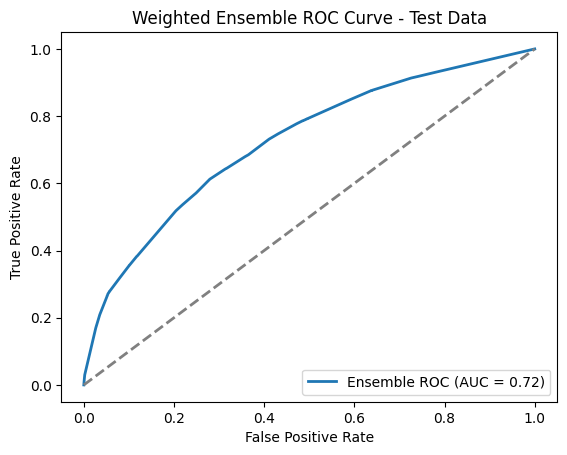


Optimal threshold (MinROCdist) for Weighted Ensemble Test Data: 0.47
Weighted Ensemble Test Data - Metrics using optimal threshold (MinROCdist):
Test Accuracy: 0.6589414621705237
Test Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.69      0.60    166613
           1       0.78      0.64      0.70    284292

    accuracy                           0.66    450905
   macro avg       0.65      0.66      0.65    450905
weighted avg       0.69      0.66      0.66    450905

Class 0 Test Accuracy: 0.6853246745452035
Class 1 Test Accuracy: 0.6434792396550026


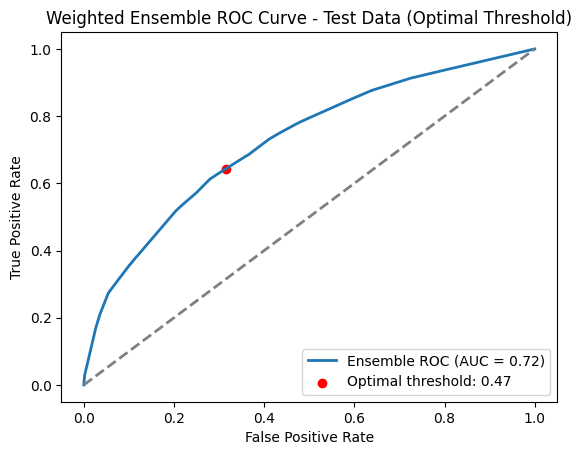


Weighted Ensemble Training Data - Default threshold (0.5) metrics:
Train Accuracy: 0.6621129559769948
Train Log Loss: 0.6097903682169955
Train ROC AUC: 0.725821522034914
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7012935901821933
Class 1 Train Accuracy: 0.6391506091843472


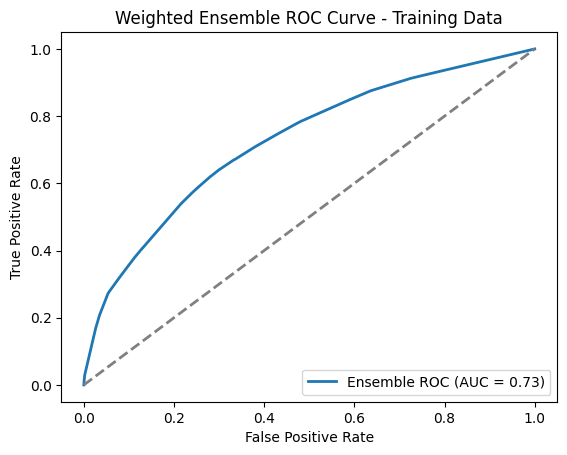


Optimal threshold (MinROCdist) for Weighted Ensemble Training Data: 0.47
Weighted Ensemble Training Data - Metrics using optimal threshold (MinROCdist):
Train Accuracy: 0.6621310149423681
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7012421449572105
Class 1 Train Accuracy: 0.639209402031519


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, classification_report, 
    confusion_matrix, roc_curve
)

# -------------------------------
# Train 7 Decision Tree models on each undersampled set
# -------------------------------
models = {}
for i in range(1, 8):
    model = DecisionTreeClassifier(random_state=42, max_depth=5)
    X_train_set, y_train_set = undersampled_sets[f"set_{i}"]
    model.fit(X_train_set, y_train_set)
    models[f"model_{i}"] = model

# -------------------------------
# Compute model weights based on training ROC AUC
# -------------------------------
weights = []
for model in models.values():
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    roc_auc = roc_auc_score(y_train, y_train_pred_proba)
    weights.append(roc_auc)
weights = np.array(weights)
weights = weights / np.sum(weights)  # Normalize weights to sum to 1
print("Model weights based on training ROC AUC:")
for i, w in enumerate(weights, start=1):
    print(f"Model {i}: {w:.3f}")

# -------------------------------
# Weighted Ensemble - Test Data Evaluation
# -------------------------------

# Compute weighted predicted probabilities for test data
ensemble_pred_proba_test = np.sum(
    [w * model.predict_proba(X_test)[:, 1] for w, model in zip(weights, models.values())],
    axis=0
)
# Default ensemble predictions with threshold 0.5
ensemble_pred_test_default = (ensemble_pred_proba_test >= 0.5).astype(int)

# Compute metrics with default threshold (0.5)
test_accuracy_default = accuracy_score(y_test, ensemble_pred_test_default)
test_log_loss_default = log_loss(y_test, ensemble_pred_proba_test)
test_roc_auc_default = roc_auc_score(y_test, ensemble_pred_proba_test)
test_report_default = classification_report(y_test, ensemble_pred_test_default)
test_conf_matrix_default = confusion_matrix(y_test, ensemble_pred_test_default)
class_0_accuracy_default = (test_conf_matrix_default[0, 0] / test_conf_matrix_default[0].sum()) if test_conf_matrix_default[0].sum() != 0 else 0
class_1_accuracy_default = (test_conf_matrix_default[1, 1] / test_conf_matrix_default[1].sum()) if test_conf_matrix_default[1].sum() != 0 else 0

print("\nWeighted Ensemble Test Data - Default threshold (0.5) metrics:")
print(f"Test Accuracy: {test_accuracy_default}")
print(f"Test Log Loss: {test_log_loss_default}")
print(f"Test ROC AUC: {test_roc_auc_default}")
print("Test Classification Report:")
print(test_report_default)
print(f"Class 0 Test Accuracy: {class_0_accuracy_default}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_default}")

# Plot baseline ROC curve for ensemble test data
fpr, tpr, thresholds = roc_curve(y_test, ensemble_pred_proba_test)
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'Ensemble ROC (AUC = {test_roc_auc_default:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Weighted Ensemble ROC Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# ---- Find Optimal Threshold (MinROCdist) for Ensemble Test Data ----
# Compute Euclidean distances from each ROC point to the ideal point (0,1)
distances = np.sqrt(fpr**2 + (1 - tpr)**2)
idx = np.argmin(distances)
optimal_threshold_test = thresholds[idx]
print(f"\nOptimal threshold (MinROCdist) for Weighted Ensemble Test Data: {optimal_threshold_test:.2f}")

# Ensemble predictions using the optimal threshold
ensemble_pred_test_opt = (ensemble_pred_proba_test >= optimal_threshold_test).astype(int)
test_accuracy_opt = accuracy_score(y_test, ensemble_pred_test_opt)
test_report_opt = classification_report(y_test, ensemble_pred_test_opt)
test_conf_matrix_opt = confusion_matrix(y_test, ensemble_pred_test_opt)
class_0_accuracy_opt = (test_conf_matrix_opt[0, 0] / test_conf_matrix_opt[0].sum()) if test_conf_matrix_opt[0].sum() != 0 else 0
class_1_accuracy_opt = (test_conf_matrix_opt[1, 1] / test_conf_matrix_opt[1].sum()) if test_conf_matrix_opt[1].sum() != 0 else 0

print("Weighted Ensemble Test Data - Metrics using optimal threshold (MinROCdist):")
print(f"Test Accuracy: {test_accuracy_opt}")
print("Test Classification Report:")
print(test_report_opt)
print(f"Class 0 Test Accuracy: {class_0_accuracy_opt}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_opt}")

plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'Ensemble ROC (AUC = {test_roc_auc_default:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.scatter(fpr[idx], tpr[idx], color='red', label=f'Optimal threshold: {optimal_threshold_test:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Weighted Ensemble ROC Curve - Test Data (Optimal Threshold)')
plt.legend(loc="lower right")
plt.show()

# -------------------------------
# Weighted Ensemble - Training Data Evaluation
# -------------------------------

# Compute weighted predicted probabilities for training data
ensemble_pred_proba_train = np.sum(
    [w * model.predict_proba(X_train)[:, 1] for w, model in zip(weights, models.values())],
    axis=0
)
# Default ensemble predictions with threshold 0.5
ensemble_pred_train_default = (ensemble_pred_proba_train >= 0.5).astype(int)

# Compute metrics with default threshold (0.5)
train_accuracy_default = accuracy_score(y_train, ensemble_pred_train_default)
train_log_loss_default = log_loss(y_train, ensemble_pred_proba_train)
train_roc_auc_default = roc_auc_score(y_train, ensemble_pred_proba_train)
train_report_default = classification_report(y_train, ensemble_pred_train_default)
train_conf_matrix_default = confusion_matrix(y_train, ensemble_pred_train_default)
class_0_accuracy_train_default = (train_conf_matrix_default[0, 0] / train_conf_matrix_default[0].sum()) if train_conf_matrix_default[0].sum() != 0 else 0
class_1_accuracy_train_default = (train_conf_matrix_default[1, 1] / train_conf_matrix_default[1].sum()) if train_conf_matrix_default[1].sum() != 0 else 0

print("\nWeighted Ensemble Training Data - Default threshold (0.5) metrics:")
print(f"Train Accuracy: {train_accuracy_default}")
print(f"Train Log Loss: {train_log_loss_default}")
print(f"Train ROC AUC: {train_roc_auc_default}")
print("Train Classification Report:")
print(train_report_default)
print(f"Class 0 Train Accuracy: {class_0_accuracy_train_default}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train_default}")

# Plot ROC curve for ensemble training data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, ensemble_pred_proba_train)
plt.figure()
plt.plot(fpr_train, tpr_train, lw=2, label=f'Ensemble ROC (AUC = {train_roc_auc_default:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Weighted Ensemble ROC Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

# ---- Find Optimal Threshold (MinROCdist) for Ensemble Training Data ----
distances_train = np.sqrt(fpr_train**2 + (1 - tpr_train)**2)
idx_train = np.argmin(distances_train)
optimal_threshold_train = thresholds_train[idx_train]
print(f"\nOptimal threshold (MinROCdist) for Weighted Ensemble Training Data: {optimal_threshold_train:.2f}")

# Ensemble predictions using the optimal threshold for training data
ensemble_pred_train_opt = (ensemble_pred_proba_train >= optimal_threshold_train).astype(int)
train_accuracy_opt = accuracy_score(y_train, ensemble_pred_train_opt)
train_report_opt = classification_report(y_train, ensemble_pred_train_opt)
train_conf_matrix_opt = confusion_matrix(y_train, ensemble_pred_train_opt)
class_0_accuracy_train_opt = (train_conf_matrix_opt[0, 0] / train_conf_matrix_opt[0].sum()) if train_conf_matrix_opt[0].sum() != 0 else 0
class_1_accuracy_train_opt = (train_conf_matrix_opt[1, 1] / train_conf_matrix_opt[1].sum()) if train_conf_matrix_opt[1].sum() != 0 else 0

print("Weighted Ensemble Training Data - Metrics using optimal threshold (MinROCdist):")
print(f"Train Accuracy: {train_accuracy_opt}")
print("Train Classification Report:")
print(train_report_opt)
print(f"Class 0 Train Accuracy: {class_0_accuracy_train_opt}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train_opt}")

plt.figure()
plt.plot(fpr_train, tpr_train, lw=2, label=f'Ensemble ROC (AUC = {train_roc_auc_default:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.scatter(fpr_train[idx_train], tpr_train[idx_train], color='red', label=f'Optimal threshold: {optimal_threshold_train:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Weighted Ensemble ROC Curve - Training Data (Optimal Threshold)')
plt.legend(loc="lower right")
plt.show()

Stacking Classifier Test Data - Default threshold (0.5) metrics:
Test Accuracy: 0.6867521983566384
Test Log Loss: 0.5837431773752128
Test ROC AUC: 0.7233490611312117
Test Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.41      0.49    166613
           1       0.71      0.85      0.77    284292

    accuracy                           0.69    450905
   macro avg       0.66      0.63      0.63    450905
weighted avg       0.67      0.69      0.67    450905

Test Confusion Matrix:
[[ 67643  98970]
 [ 42275 242017]]
Class 0 Test Accuracy: 0.406
Class 1 Test Accuracy: 0.851


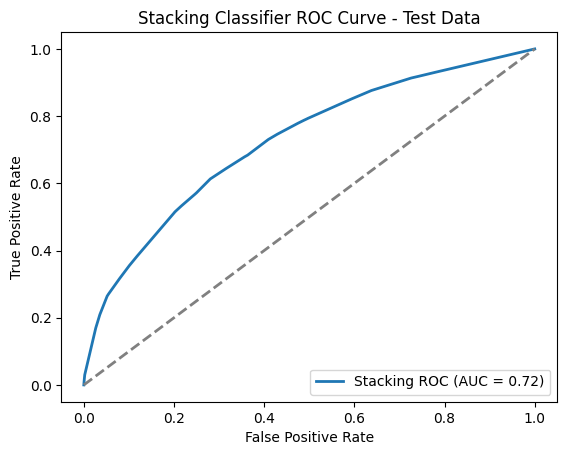


Optimal threshold (MinROCdist) for Stacking Classifier Test Data: 0.62
Stacking Classifier Test Data - Metrics using optimal threshold (MinROCdist):
Test Accuracy: 0.6590456969871702
Test Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.68      0.60    166613
           1       0.78      0.64      0.70    284292

    accuracy                           0.66    450905
   macro avg       0.65      0.66      0.65    450905
weighted avg       0.69      0.66      0.66    450905

Test Confusion Matrix:
[[113971  52642]
 [101096 183196]]
Class 0 Test Accuracy: 0.684
Class 1 Test Accuracy: 0.644


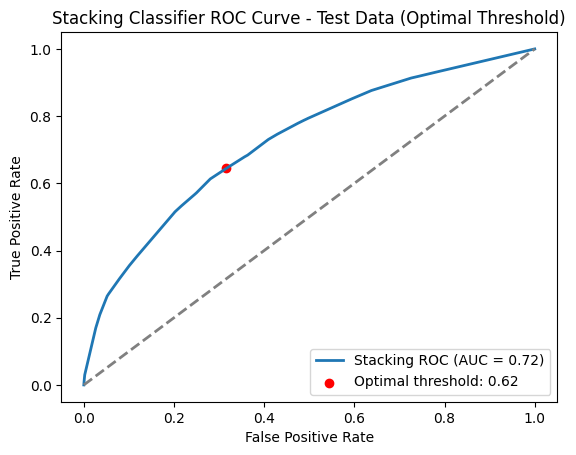


Stacking Classifier Training Data - Default threshold (0.5) metrics:
Train Accuracy: 0.686991556958452
Train Log Loss: 0.5825414533587404
Train ROC AUC: 0.7256743972832979
Train Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.41      0.49    388763
           1       0.71      0.85      0.77    663346

    accuracy                           0.69   1052109
   macro avg       0.66      0.63      0.63   1052109
weighted avg       0.68      0.69      0.67   1052109

Train Confusion Matrix:
[[158522 230241]
 [ 99078 564268]]
Class 0 Train Accuracy: 0.408
Class 1 Train Accuracy: 0.851



Optimal threshold (MinROCdist) for Stacking Classifier Training Data: 0.67
Stacking Classifier Training Data - Metrics using optimal threshold (MinROCdist):
Train Accuracy: 0.6621405196609857
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.60    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Train Confusion Matrix:
[[272219 116544]
 [238921 424425]]
Class 0 Train Accuracy: 0.700
Class 1 Train Accuracy: 0.640


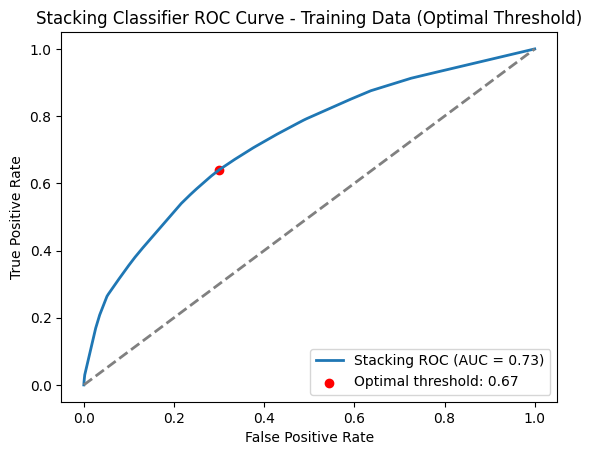

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, classification_report, 
    confusion_matrix, roc_curve
)

# -------------------------------
# Create base estimators for stacking: 7 Decision Trees
# -------------------------------
estimators = [(f"model_{i}", DecisionTreeClassifier(random_state=42, max_depth=5))
              for i in range(1, 8)]

# -------------------------------
# Create and train the StackingClassifier
# -------------------------------
stacking_clf = StackingClassifier(estimators=estimators, 
                                  final_estimator=LogisticRegression(),
                                  cv=5)
stacking_clf.fit(X_train, y_train)

# -------------------------------
# Evaluate StackingClassifier on Test Data
# -------------------------------
# Get predicted probabilities for the positive class on test data
y_pred_proba_test = stacking_clf.predict_proba(X_test)[:, 1]
# Default predictions using threshold = 0.5
y_pred_test_default = (y_pred_proba_test >= 0.5).astype(int)

# Compute metrics with the default threshold
test_accuracy_default = accuracy_score(y_test, y_pred_test_default)
test_log_loss_default = log_loss(y_test, y_pred_proba_test)
test_roc_auc_default = roc_auc_score(y_test, y_pred_proba_test)
test_report_default = classification_report(y_test, y_pred_test_default)
test_conf_matrix_default = confusion_matrix(y_test, y_pred_test_default)

# Calculate class-specific accuracies for default threshold (Test)
test_class0_accuracy_default = (test_conf_matrix_default[0, 0] / np.sum(test_conf_matrix_default[0, :])
                                if np.sum(test_conf_matrix_default[0, :]) != 0 else 0)
test_class1_accuracy_default = (test_conf_matrix_default[1, 1] / np.sum(test_conf_matrix_default[1, :])
                                if np.sum(test_conf_matrix_default[1, :]) != 0 else 0)

print("Stacking Classifier Test Data - Default threshold (0.5) metrics:")
print(f"Test Accuracy: {test_accuracy_default}")
print(f"Test Log Loss: {test_log_loss_default}")
print(f"Test ROC AUC: {test_roc_auc_default}")
print("Test Classification Report:")
print(test_report_default)
print("Test Confusion Matrix:")
print(test_conf_matrix_default)
print(f"Class 0 Test Accuracy: {test_class0_accuracy_default:.3f}")
print(f"Class 1 Test Accuracy: {test_class1_accuracy_default:.3f}")

# Plot ROC curve for test data
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'Stacking ROC (AUC = {test_roc_auc_default:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Stacking Classifier ROC Curve - Test Data")
plt.legend(loc="lower right")
plt.show()

# ---- Find Optimal Threshold (MinROCdist) for Test Data ----
distances = np.sqrt(fpr**2 + (1 - tpr)**2)
idx = np.argmin(distances)
optimal_threshold_test = thresholds[idx]
print(f"\nOptimal threshold (MinROCdist) for Stacking Classifier Test Data: {optimal_threshold_test:.2f}")

# Compute predictions using the optimal threshold
y_pred_test_opt = (y_pred_proba_test >= optimal_threshold_test).astype(int)
test_accuracy_opt = accuracy_score(y_test, y_pred_test_opt)
test_report_opt = classification_report(y_test, y_pred_test_opt)
test_conf_matrix_opt = confusion_matrix(y_test, y_pred_test_opt)

# Calculate class-specific accuracies for optimal threshold (Test)
test_class0_accuracy_opt = (test_conf_matrix_opt[0, 0] / np.sum(test_conf_matrix_opt[0, :])
                            if np.sum(test_conf_matrix_opt[0, :]) != 0 else 0)
test_class1_accuracy_opt = (test_conf_matrix_opt[1, 1] / np.sum(test_conf_matrix_opt[1, :])
                            if np.sum(test_conf_matrix_opt[1, :]) != 0 else 0)

print("Stacking Classifier Test Data - Metrics using optimal threshold (MinROCdist):")
print(f"Test Accuracy: {test_accuracy_opt}")
print("Test Classification Report:")
print(test_report_opt)
print("Test Confusion Matrix:")
print(test_conf_matrix_opt)
print(f"Class 0 Test Accuracy: {test_class0_accuracy_opt:.3f}")
print(f"Class 1 Test Accuracy: {test_class1_accuracy_opt:.3f}")

plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'Stacking ROC (AUC = {test_roc_auc_default:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.scatter(fpr[idx], tpr[idx], color='red', label=f'Optimal threshold: {optimal_threshold_test:.2f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Stacking Classifier ROC Curve - Test Data (Optimal Threshold)")
plt.legend(loc="lower right")
plt.show()

# -------------------------------
# Evaluate StackingClassifier on Training Data
# -------------------------------
y_pred_proba_train = stacking_clf.predict_proba(X_train)[:, 1]
y_pred_train_default = (y_pred_proba_train >= 0.5).astype(int)

train_accuracy_default = accuracy_score(y_train, y_pred_train_default)
train_log_loss_default = log_loss(y_train, y_pred_proba_train)
train_roc_auc_default = roc_auc_score(y_train, y_pred_proba_train)
train_report_default = classification_report(y_train, y_pred_train_default)
train_conf_matrix_default = confusion_matrix(y_train, y_pred_train_default)

# Calculate class-specific accuracies for default threshold (Train)
train_class0_accuracy_default = (train_conf_matrix_default[0, 0] / np.sum(train_conf_matrix_default[0, :])
                                 if np.sum(train_conf_matrix_default[0, :]) != 0 else 0)
train_class1_accuracy_default = (train_conf_matrix_default[1, 1] / np.sum(train_conf_matrix_default[1, :])
                                 if np.sum(train_conf_matrix_default[1, :]) != 0 else 0)

print("\nStacking Classifier Training Data - Default threshold (0.5) metrics:")
print(f"Train Accuracy: {train_accuracy_default}")
print(f"Train Log Loss: {train_log_loss_default}")
print(f"Train ROC AUC: {train_roc_auc_default}")
print("Train Classification Report:")
print(train_report_default)
print("Train Confusion Matrix:")
print(train_conf_matrix_default)
print(f"Class 0 Train Accuracy: {train_class0_accuracy_default:.3f}")
print(f"Class 1 Train Accuracy: {train_class1_accuracy_default:.3f}")

# Plot ROC curve for training data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_proba_train)
plt.figure()
plt.plot(fpr_train, tpr_train, lw=2, label=f'Stacking ROC (AUC = {train_roc_auc_default:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Stacking Classifier ROC Curve - Training Data")
plt.legend(loc="lower right")
plt.show()

# ---- Find Optimal Threshold (MinROCdist) for Training Data ----
distances_train = np.sqrt(fpr_train**2 + (1 - tpr_train)**2)
idx_train = np.argmin(distances_train)
optimal_threshold_train = thresholds_train[idx_train]
print(f"\nOptimal threshold (MinROCdist) for Stacking Classifier Training Data: {optimal_threshold_train:.2f}")

y_pred_train_opt = (y_pred_proba_train >= optimal_threshold_train).astype(int)
train_accuracy_opt = accuracy_score(y_train, y_pred_train_opt)
train_report_opt = classification_report(y_train, y_pred_train_opt)
train_conf_matrix_opt = confusion_matrix(y_train, y_pred_train_opt)

# Calculate class-specific accuracies for optimal threshold (Train)
train_class0_accuracy_opt = (train_conf_matrix_opt[0, 0] / np.sum(train_conf_matrix_opt[0, :])
                             if np.sum(train_conf_matrix_opt[0, :]) != 0 else 0)
train_class1_accuracy_opt = (train_conf_matrix_opt[1, 1] / np.sum(train_conf_matrix_opt[1, :])
                             if np.sum(train_conf_matrix_opt[1, :]) != 0 else 0)

print("Stacking Classifier Training Data - Metrics using optimal threshold (MinROCdist):")
print(f"Train Accuracy: {train_accuracy_opt}")
print("Train Classification Report:")
print(train_report_opt)
print("Train Confusion Matrix:")
print(train_conf_matrix_opt)
print(f"Class 0 Train Accuracy: {train_class0_accuracy_opt:.3f}")
print(f"Class 1 Train Accuracy: {train_class1_accuracy_opt:.3f}")

plt.figure()
plt.plot(fpr_train, tpr_train, lw=2, label=f'Stacking ROC (AUC = {train_roc_auc_default:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.scatter(fpr_train[idx_train], tpr_train[idx_train], color='red', label=f'Optimal threshold: {optimal_threshold_train:.2f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Stacking Classifier ROC Curve - Training Data (Optimal Threshold)")
plt.legend(loc="lower right")
plt.show()

Custom uneven model weights:
Model 1: 0.050
Model 2: 0.100
Model 3: 0.200
Model 4: 0.300
Model 5: 0.150
Model 6: 0.100
Model 7: 0.100

Weighted Ensemble Test Data - Default threshold (0.5) metrics:
Test Accuracy: 0.6522948292877657
Test Log Loss: 0.6142380654273741
Test ROC AUC: 0.7234216626715011
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.61    166613
           1       0.79      0.61      0.69    284292

    accuracy                           0.65    450905
   macro avg       0.66      0.67      0.65    450905
weighted avg       0.69      0.65      0.66    450905

Class 0 Test Accuracy: 0.7208141021408894
Class 1 Test Accuracy: 0.6121382240794676



Optimal threshold (MinROCdist) for Weighted Ensemble Test Data: 0.46
Weighted Ensemble Test Data - Metrics using optimal threshold (MinROCdist):
Test Accuracy: 0.6589170667879043
Test Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.68      0.60    166613
           1       0.78      0.64      0.70    284292

    accuracy                           0.66    450905
   macro avg       0.65      0.66      0.65    450905
weighted avg       0.69      0.66      0.66    450905

Class 0 Test Accuracy: 0.6833980541734439
Class 1 Test Accuracy: 0.64456966780634


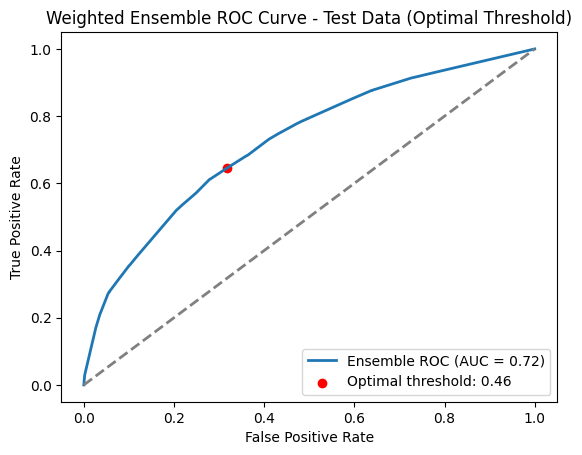


Weighted Ensemble Training Data - Default threshold (0.5) metrics:
Train Accuracy: 0.6621262625830594
Train Log Loss: 0.6098050791536646
Train ROC AUC: 0.7257849863286274
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7012550062634562
Class 1 Train Accuracy: 0.6391943269425006


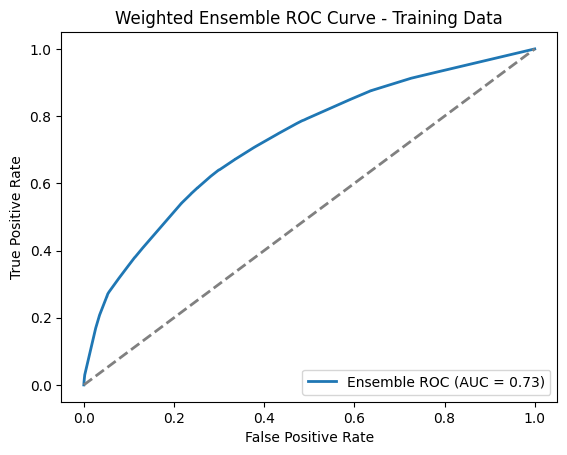


Optimal threshold (MinROCdist) for Weighted Ensemble Training Data: 0.51
Weighted Ensemble Training Data - Metrics using optimal threshold (MinROCdist):
Train Accuracy: 0.6621262625830594
Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.70      0.61    388763
           1       0.78      0.64      0.70    663346

    accuracy                           0.66   1052109
   macro avg       0.66      0.67      0.65   1052109
weighted avg       0.69      0.66      0.67   1052109

Class 0 Train Accuracy: 0.7012550062634562
Class 1 Train Accuracy: 0.6391943269425006


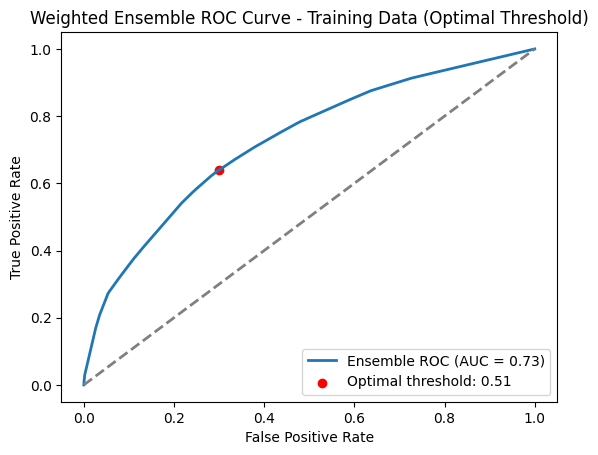

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, classification_report, 
    confusion_matrix, roc_curve
)

# -------------------------------
# Train 7 Decision Tree models on each undersampled set
# -------------------------------
models = {}
for i in range(1, 8):
    model = DecisionTreeClassifier(random_state=42, max_depth=5)
    X_train_set, y_train_set = undersampled_sets[f"set_{i}"]
    model.fit(X_train_set, y_train_set)
    models[f"model_{i}"] = model

# -------------------------------
# Set custom uneven weights for each model manually (sum to 1)
# For example, we assign:
# Model 1: 0.05, Model 2: 0.10, Model 3: 0.20, Model 4: 0.30, Model 5: 0.15, Model 6: 0.10, Model 7: 0.10
# Total = 1.00
weights = np.array([0.05, 0.10, 0.20, 0.30, 0.15, 0.10, 0.10])
print("Custom uneven model weights:")
for i, w in enumerate(weights, start=1):
    print(f"Model {i}: {w:.3f}")

# -------------------------------
# Weighted Ensemble - Test Data Evaluation
# -------------------------------

# Compute weighted predicted probabilities for test data
ensemble_pred_proba_test = np.sum(
    [w * model.predict_proba(X_test)[:, 1] for w, model in zip(weights, models.values())],
    axis=0
)
# Default ensemble predictions with threshold 0.5
ensemble_pred_test_default = (ensemble_pred_proba_test >= 0.5).astype(int)

# Compute metrics with default threshold (0.5)
test_accuracy_default = accuracy_score(y_test, ensemble_pred_test_default)
test_log_loss_default = log_loss(y_test, ensemble_pred_proba_test)
test_roc_auc_default = roc_auc_score(y_test, ensemble_pred_proba_test)
test_report_default = classification_report(y_test, ensemble_pred_test_default)
test_conf_matrix_default = confusion_matrix(y_test, ensemble_pred_test_default)
class_0_accuracy_default = (test_conf_matrix_default[0, 0] / test_conf_matrix_default[0].sum()) if test_conf_matrix_default[0].sum() != 0 else 0
class_1_accuracy_default = (test_conf_matrix_default[1, 1] / test_conf_matrix_default[1].sum()) if test_conf_matrix_default[1].sum() != 0 else 0

print("\nWeighted Ensemble Test Data - Default threshold (0.5) metrics:")
print(f"Test Accuracy: {test_accuracy_default}")
print(f"Test Log Loss: {test_log_loss_default}")
print(f"Test ROC AUC: {test_roc_auc_default}")
print("Test Classification Report:")
print(test_report_default)
print(f"Class 0 Test Accuracy: {class_0_accuracy_default}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_default}")

# Plot baseline ROC curve for ensemble test data
fpr, tpr, thresholds = roc_curve(y_test, ensemble_pred_proba_test)
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'Ensemble ROC (AUC = {test_roc_auc_default:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Weighted Ensemble ROC Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# ---- Find Optimal Threshold (MinROCdist) for Ensemble Test Data ----
# Compute Euclidean distances from each ROC point to the ideal point (0,1)
distances = np.sqrt(fpr**2 + (1 - tpr)**2)
idx = np.argmin(distances)
optimal_threshold_test = thresholds[idx]
print(f"\nOptimal threshold (MinROCdist) for Weighted Ensemble Test Data: {optimal_threshold_test:.2f}")

# Ensemble predictions using the optimal threshold
ensemble_pred_test_opt = (ensemble_pred_proba_test >= optimal_threshold_test).astype(int)
test_accuracy_opt = accuracy_score(y_test, ensemble_pred_test_opt)
test_report_opt = classification_report(y_test, ensemble_pred_test_opt)
test_conf_matrix_opt = confusion_matrix(y_test, ensemble_pred_test_opt)
class_0_accuracy_opt = (test_conf_matrix_opt[0, 0] / test_conf_matrix_opt[0].sum()) if test_conf_matrix_opt[0].sum() != 0 else 0
class_1_accuracy_opt = (test_conf_matrix_opt[1, 1] / test_conf_matrix_opt[1].sum()) if test_conf_matrix_opt[1].sum() != 0 else 0

print("Weighted Ensemble Test Data - Metrics using optimal threshold (MinROCdist):")
print(f"Test Accuracy: {test_accuracy_opt}")
print("Test Classification Report:")
print(test_report_opt)
print(f"Class 0 Test Accuracy: {class_0_accuracy_opt}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_opt}")

plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'Ensemble ROC (AUC = {test_roc_auc_default:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.scatter(fpr[idx], tpr[idx], color='red', label=f'Optimal threshold: {optimal_threshold_test:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Weighted Ensemble ROC Curve - Test Data (Optimal Threshold)')
plt.legend(loc="lower right")
plt.show()

# -------------------------------
# Weighted Ensemble - Training Data Evaluation
# -------------------------------

# Compute weighted predicted probabilities for training data
ensemble_pred_proba_train = np.sum(
    [w * model.predict_proba(X_train)[:, 1] for w, model in zip(weights, models.values())],
    axis=0
)
# Default ensemble predictions with threshold 0.5
ensemble_pred_train_default = (ensemble_pred_proba_train >= 0.5).astype(int)

# Compute metrics with default threshold (0.5)
train_accuracy_default = accuracy_score(y_train, ensemble_pred_train_default)
train_log_loss_default = log_loss(y_train, ensemble_pred_proba_train)
train_roc_auc_default = roc_auc_score(y_train, ensemble_pred_proba_train)
train_report_default = classification_report(y_train, ensemble_pred_train_default)
train_conf_matrix_default = confusion_matrix(y_train, ensemble_pred_train_default)
class_0_accuracy_train_default = (train_conf_matrix_default[0, 0] / train_conf_matrix_default[0].sum()) if train_conf_matrix_default[0].sum() != 0 else 0
class_1_accuracy_train_default = (train_conf_matrix_default[1, 1] / train_conf_matrix_default[1].sum()) if train_conf_matrix_default[1].sum() != 0 else 0

print("\nWeighted Ensemble Training Data - Default threshold (0.5) metrics:")
print(f"Train Accuracy: {train_accuracy_default}")
print(f"Train Log Loss: {train_log_loss_default}")
print(f"Train ROC AUC: {train_roc_auc_default}")
print("Train Classification Report:")
print(train_report_default)
print(f"Class 0 Train Accuracy: {class_0_accuracy_train_default}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train_default}")

# Plot ROC curve for ensemble training data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, ensemble_pred_proba_train)
plt.figure()
plt.plot(fpr_train, tpr_train, lw=2, label=f'Ensemble ROC (AUC = {train_roc_auc_default:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Weighted Ensemble ROC Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

# ---- Find Optimal Threshold (MinROCdist) for Ensemble Training Data ----
distances_train = np.sqrt(fpr_train**2 + (1 - tpr_train)**2)
idx_train = np.argmin(distances_train)
optimal_threshold_train = thresholds_train[idx_train]
print(f"\nOptimal threshold (MinROCdist) for Weighted Ensemble Training Data: {optimal_threshold_train:.2f}")

# Ensemble predictions using the optimal threshold for training data
ensemble_pred_train_opt = (ensemble_pred_proba_train >= optimal_threshold_train).astype(int)
train_accuracy_opt = accuracy_score(y_train, ensemble_pred_train_opt)
train_report_opt = classification_report(y_train, ensemble_pred_train_opt)
train_conf_matrix_opt = confusion_matrix(y_train, ensemble_pred_train_opt)
class_0_accuracy_train_opt = (train_conf_matrix_opt[0, 0] / train_conf_matrix_opt[0].sum()) if train_conf_matrix_opt[0].sum() != 0 else 0
class_1_accuracy_train_opt = (train_conf_matrix_opt[1, 1] / train_conf_matrix_opt[1].sum()) if train_conf_matrix_opt[1].sum() != 0 else 0

print("Weighted Ensemble Training Data - Metrics using optimal threshold (MinROCdist):")
print(f"Train Accuracy: {train_accuracy_opt}")
print("Train Classification Report:")
print(train_report_opt)
print(f"Class 0 Train Accuracy: {class_0_accuracy_train_opt}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train_opt}")

plt.figure()
plt.plot(fpr_train, tpr_train, lw=2, label=f'Ensemble ROC (AUC = {train_roc_auc_default:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.scatter(fpr_train[idx_train], tpr_train[idx_train], color='red', label=f'Optimal threshold: {optimal_threshold_train:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Weighted Ensemble ROC Curve - Training Data (Optimal Threshold)')
plt.legend(loc="lower right")
plt.show()